In [1]:
import yfinance as yf
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import warnings

from pmdarima import auto_arima
from sklearn import metrics

warnings.filterwarnings('ignore')

In [2]:
list_of_tickers = [
    'SNDL', 'MSFT', 'SNAP', 'BB', 'WMT', 'PTON', 'RYCEY', 'CPRX', 'AAPL', 'HOOD', 'RIVN', 'WISH'
    'TSLA', 'AMC', 'F', 'AMZN', 'DIS', 'NIO', 'LCID', 'PFE', 'FB', 'NFLX', 'AAL', 'NVDA',
    'PLUG', 'GPRO', 'BABA', 'CCL', 'ACB', 'ZOM', 'VOO', 'NOK', 'SPY', 'DAL', 'BAC', 'PLTR',
    'GME', 'SBUX', 'AMD', 'OGI', 'TLRY', 'COIN', 'TWTR', 'T', 'MRNA', 'CGC', 'KO',
    'SPCE', 'FCEL', 'GOOGL', 'UBER', 'ZNGA', 'GM', 'GE', 'PYPL', 'ABNB', 'UAL', 'DKNG', 'JNJ',
    'LUV', 'NKE', 'XOM', 'SONY'
]


def comp_def(comp):
    print()
    print("-"*100)
    print("Company: ", comp , "\n")
    comp = yf.Ticker(comp);
    comp = comp.history(period="3y")
    # stock price investigated
    df = comp.copy()
    
    if df.empty:
        print(f" No data for company: {str(comp)}" )
    else: 
        df = df.drop(['Dividends','Stock Splits'], axis =1)
        #reset index for simplicity when ploting
        df.reset_index(inplace=True)
    
    return df

In [3]:
def mean_absolute_percentage_error(y_true, y_pred):
    
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    return np.mean(np.abs((y_true - y_pred) / y_true)) 

def evaluation_func(y_true, y_pred):
    
    print('Evaluation:\n')
    print(f'RMSE : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE : {mean_absolute_percentage_error(y_true, y_pred)}')

In [4]:
def train_predict_arima(df, prd):
    
    #prd determine variable of percent used for test train. 0.33 one third of data is test.
    

    #split data using variable defined 
    train_data, test_data = df[0:prd],df[prd:]
    
    #external variable for ARIMAX
    exoX   =  df[['Close']]
    exotrain, exotest = exoX[0:prd], exoX[prd:]
    
    #ARIMA VARIABLE FOR SEASONALITY
    m=1
    
    ######################## model training ###########################################
    print(f'  SARIMAX m = {str(m)}') 
    model = auto_arima(train_data['Open'], exogenous = exotrain , seasonal=True, m = m,
                       d=None,D=None, trace=True, stepwise=True)

    print("-"*100)
    #output summary of model
    #model.summary()

    #forcast 
    forecast = model.predict(n_periods=-prd,exogenous =exotest, return_conf_int=False)
    

    #adjust index of predictions  
    #index shift due to predictions start from 2/3 of data subtract the -1/3 (to add) 
    dif = len(train_data)-prd        #-1 due to train_data starting at 0
    
    forecast  =   pd.DataFrame(forecast, columns=['open_pred'])
    forecast["new_index"] = range(len(train_data), dif)
    forecast  =   forecast.set_index("new_index")
    
    #################### evalutate model ##############
    print("Testing data")
    evaluation_func(test_data['Open'], forecast)
    
    plt.figure( figsize = (17,8) )
    plt.xlabel('Dates'  , fontsize = 15 )
    plt.ylabel('Prices' , fontsize = 15 )
    plt.title('Price Predictions - Open Prices',fontsize = 15 )

    plt.plot(train_data['Date'] , train_data['Open'],   label = 'Train')
    plt.plot(test_data['Date']  , test_data['Open'],    label = 'Test')
    plt.plot(test_data['Date']  , forecast,label = f'Predicted ARIMA - m = {str(m)}', color ='k')


    plt.legend(loc ='upper left',prop={'size': 13})
    plt.show()
    ###########################################
    
    return model, forecast

In [5]:
def price_predictions(model, exot, num_pred):
    
    forecast = model.predict(n_periods= num_pred,exogenous = exot[-num_pred:] , return_conf_int=False)

    print()
    print("Price forcasted for next",num_pred," days" , forecast)
    print("-"*100)
    
    return forecast
    
    
def graph_predict(forecast, num_pred):

    #adjust index of predictions 
    forecast = pd.DataFrame(forecast, columns=['open_pred'])
    forecast["new_index"] = range(len(df), len(df)+num_pred)
    forecast = forecast.set_index("new_index")

    plt.figure(figsize=(17,8))
    plt.xlabel('Dates',fontsize=15)
    plt.ylabel('Prices',fontsize=15)
    plt.title('Price Predictions - Open Prices',fontsize=15)

    plt.plot(forecast, label='Predictions')
    plt.plot(df['Open'][-30:], label='history')
    #plt.plot(x,forecast, label=f'Predicted ARIMA - m={str(m)}', color ='k')

    plt.legend(loc ='upper left',prop={'size': 13})
    plt.show()

 _______________________
## Run  Arima


----------------------------------------------------------------------------------------------------
Company:  MSFT 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=2413.897, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2435.158, Time=0.21 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2412.174, Time=0.24 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2409.179, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2434.213, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2410.083, Time=0.47 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=2410.654, Time=0.12 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=2412.606, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2407.291, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2408.898, Time=0.16 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=2408.798, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2410.971, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[0]       

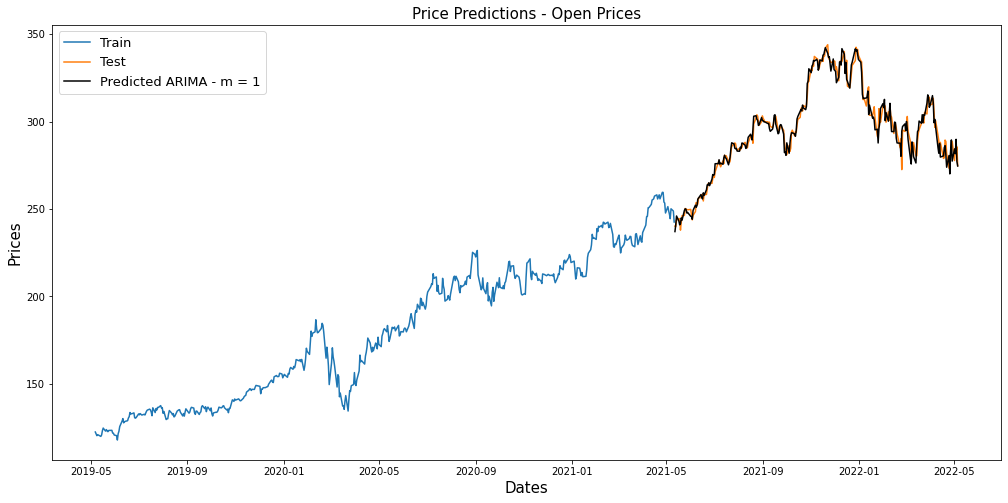


Price forcasted for next 3  days [289.98217809 277.200887   274.58230054]
----------------------------------------------------------------------------------------------------


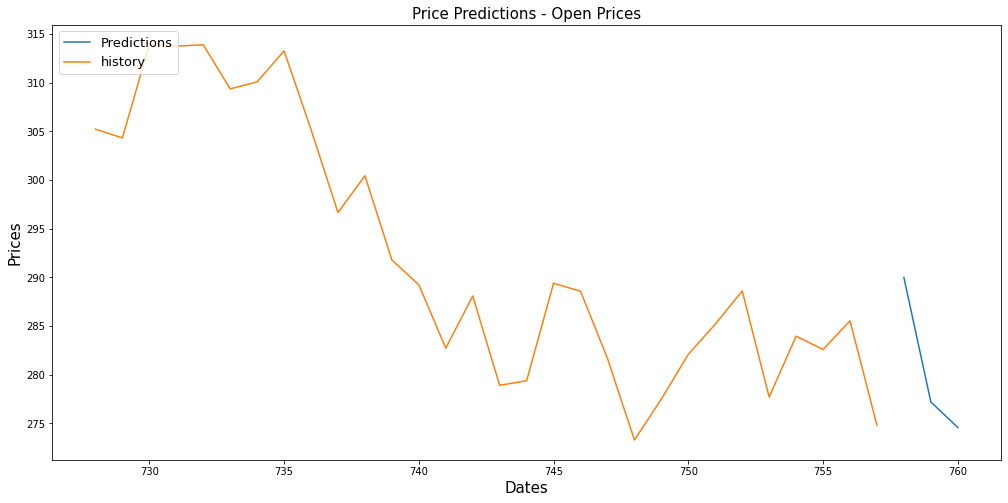

In [6]:
df = comp_def(list_of_tickers[1])
model, forecast = train_predict_arima(df, prd = -int(len(df)*0.33) )
next_day = price_predictions(model, df[['Close']], num_pred = 3)
graph_predict(next_day, num_pred = 3)


Price forcasted for next 3  days [289.98217809 277.200887   274.58230054]
----------------------------------------------------------------------------------------------------


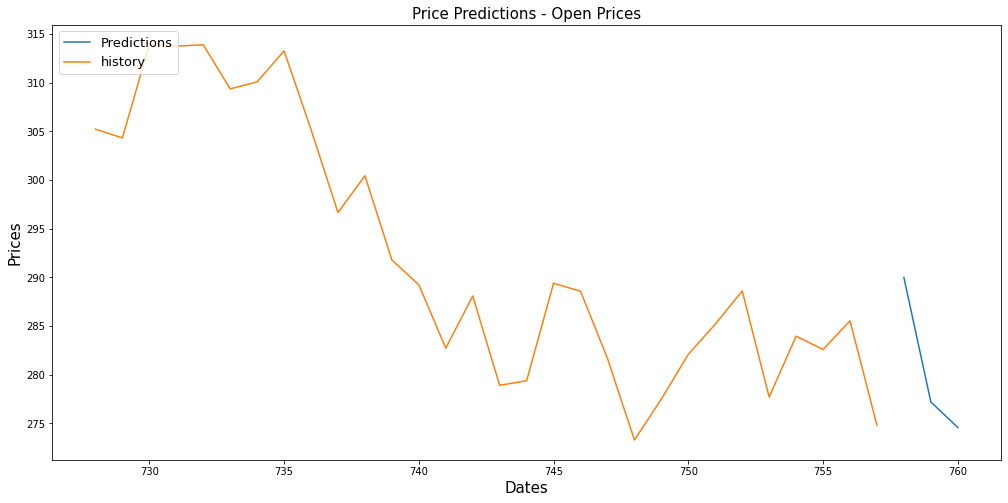

In [7]:
#1 day predictiosn
days = 3
next_day = price_predictions(model, df[['Close']], num_pred =  days)
graph_predict(next_day, num_pred = days)

### Develop Recomentation of hold,sell buy using percent change of stock price withing x day predictions

In [8]:
def changes(df, next_day):
    #calculate % change of stock price  
    df = df.reset_index(inplace=False)
    change = next_day[-1:] - df[-1:]['Open']
    per = (next_day[-1:] - df[-1:]['Open'])/df[-1:]['Open']
    per = per*100
    print(days, "day prediction:")
    print("Change in price \t", change.to_string(index=False))
    print("Percent Change in price ", per.to_string(index=False), "%")
    
    
    #calculate % change of stock price  
    df = df.reset_index(inplace=False)
    change = next_day[:1] - df[-1:]['Open']
    per = (next_day[:1] - df[-1:]['Open'])/df[-1:]['Open']
    per = per*100
    

    print("\n1 day prediction:")
    print("Change in price \t", change.to_string(index=False))
    print("Percent Change in price ", per.to_string(index=False), "%")

In [9]:
changes(df, next_day)

3 day prediction:
Change in price 	 -0.222692
Percent Change in price  -0.081036 %

1 day prediction:
Change in price 	 15.177185
Percent Change in price  5.522893 %


In [10]:
def pct_change_arima(df, prd):
    
    #prd determine variable of percent used for test train. 0.33 one third of data is test.
    #ignore FIRST ROW OF DF AS THERE IS NO CHANGE CALCULATION
    #df = df.iloc[1: , :]
    df = df[df['Open_pct_change'].notnull()]
    
    #split data using variable defined 
    train_data, test_data = df[0:prd],df[prd:]
    
    #external variable for ARIMAX
    exoX   =  df[['Close_pct_change']]
    exotrain, exotest = exoX[0:prd], exoX[prd:]
    
    #ARIMA VARIABLE FOR SEASONALITY
    m=1
    
    ######################## model training ###########################################
    print(f'  SARIMAX m = {str(m)}') 
    model = auto_arima(train_data['Open_pct_change'], exogenous = exotrain , seasonal=True, m = m,
                       d=None,D=None, trace=True, stepwise=True)

    print("-"*100)

    #forcast 
    forecast = model.predict(n_periods=-prd,exogenous = exotest, return_conf_int=False)

    #adjust index of predictions  
    #index shift due to predictions start from 2/3 of data subtract the -1/3 (to add) 
    dif = len(train_data)-prd        #-1 due to train_data starting at 0
    
    forecast  =   pd.DataFrame(forecast, columns=['open_pred'])
    forecast["new_index"] = range(len(train_data), dif)
    forecast  =   forecast.set_index("new_index")
    
    #################### evalutate model ##############
#     print("Testing data")
#     evaluation_func(test_data['Open_pct_change'], forecast)
    
#     plt.figure( figsize = (17,8) )
#     plt.xlabel('Dates'  , fontsize = 15 )
#     plt.ylabel('Percent Change' , fontsize = 15 )
#     plt.title('Change Predictions - Open Price Changes',fontsize = 15 )

#     #plt.plot(train_data['Date'] , train_data['Open_pct_change'],   label = 'Train')
#     plt.plot(test_data['Date']  , test_data['Open_pct_change'],    label = 'Test')
#     plt.plot(test_data['Date']  , forecast,label = f'Predicted ARIMA - m = {str(m)}', color ='k')
#     plt.axhline(y=0, color='r', linestyle='-')

#     plt.legend(loc ='upper left',prop={'size': 13})
#     plt.show()
    ###########################################
    
    return model, forecast

In [11]:
def recmd(df):
    truth_rec = []
    pred_rec = []

    truth_pct_change = list(df['Open_pct_change'])
    pred_pct_change = list(df['pct_pred'])

    for i in range(len(truth_pct_change)):
        if truth_pct_change[i] <= 1 and truth_pct_change[i] >= -1:
            #print(‘hold’)
            truth_rec.append('hold')
        elif truth_pct_change[i] > 1:
            #print(‘sell’)
            truth_rec.append('buy')
        elif truth_pct_change[i] < -1:
            #print(‘buy’)
            truth_rec.append('sell')

        if pred_pct_change[i] <= 1 and pred_pct_change[i] >= -1:
            #print(‘hold’)
            pred_rec.append('hold')
        elif pred_pct_change[i] > 1:
            #print(‘sell’)
            pred_rec.append('buy')
        elif pred_pct_change[i] < -1:
            #print(‘buy’)
            pred_rec.append('sell')
            
    df['truth_rec'] = truth_rec
    df['pred_rec'] = pred_rec
    
    df_test = df[df['pred_rec'] != 'hold']
    
    print("Accuracy: " ,metrics.accuracy_score(truth_rec, pred_rec))

    return(df_test)

### Backtesting

In [12]:
def backtesting(df, prd):
    
    df_ = df.copy()
    df_['Open_pct_change'] = df_['Open'].pct_change(periods=1)*100
    df_['Close_pct_change'] = df_['Close'].pct_change(periods=1)*100
    
    model_, forecast_ = pct_change_arima(df_, prd = -int(len(df)*0.33) )
    #write true data to file
#     df_.to_csv( index=False)

#     os.makedirs('Data/', exist_ok=True)  
#     df_.to_csv('data_recommender_truth.csv')  

    #print(forecast_)
###################################################
    #get recomendations
    recs = [None]*(len(df_)+prd+1) + list(forecast_['open_pred'])
    recs.pop()
    df_['pct_pred'] = recs
    df_ = df_[df_['pct_pred'].notnull()]
    df_test = recmd(df_)
    return df_test

In [13]:
df_test = backtesting(df, prd = -int(len(df)*0.33))

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1875.100, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2015.134, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1963.084, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1881.230, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2014.885, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1873.204, Time=0.22 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=1871.421, Time=0.11 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=1873.171, Time=0.16 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1872.509, Time=0.12 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=1875.144, Time=0.14 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1870.439, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1881.650, Time=0.06 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1872.216, Time=0.16 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=1872.188, Time=0.10 sec
 ARIMA(1,0,1)(0,0

In [14]:
df_test.head()

Date        Open        High         Low       Close    Volume  \
509 2021-05-13  239.846348  243.615649  239.469414  241.066406  29624300   
510 2021-05-14  243.595838  247.166742  243.506568  246.145065  23901100   
511 2021-05-17  244.557977  244.597647  241.552459  243.199036  24970200   
512 2021-05-18  244.280241  244.419109  240.937459  241.116013  20168000   
515 2021-05-21  246.136802  246.892397  243.323183  243.750687  21863100   

     Open_pct_change  Close_pct_change  pct_pred truth_rec pred_rec  
509        -0.152784          1.686191 -1.617033      hold     sell  
510         1.563288          2.106747  1.412416       buy      buy  
511         0.394974         -1.196867  1.950012      hold      buy  
512        -0.113566         -0.856510 -1.107824      hold     sell  
515         1.479764         -0.531470  1.279208       buy      buy

### Obtain average accuracy of recomendation system

In [15]:
def find_average(arr):
    return sum(arr) / len(arr)

def acc_recmd():

    accuracy = []
    
    for c in list_of_tickers:
        
        print( " ", list_of_tickers.index(c) +1 ," from ", len(list_of_tickers))

        df = comp_def(c) 
        if df.empty:
            print(f" No data for company: {str(c)}" )
        else: 
            df_ = backtesting(df, prd = -int(len(df)*0.33))

            print(f"{str(c)}" )
            print('Evaluation:\n')

            accuracy.append(metrics.accuracy_score(df_['truth_rec'], df_['pred_rec'] ))
          
        
    av_Ac = find_average(accuracy)
    print("Average Accuracy: " , av_Ac)

In [16]:
acc_recmd()

  1  from  62

----------------------------------------------------------------------------------------------------
Company:  SNDL 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3521.658, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4074.960, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3900.264, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4072.969, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3517.428, Time=0.49 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.48 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.59 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.57 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time

 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=2501.603, Time=0.33 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=2500.270, Time=0.16 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=2551.207, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2501.041, Time=0.14 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0] intercept
Total fit time: 1.785 seconds
----------------------------------------------------------------------------------------------------
Accuracy:  0.7361111111111112
PTON
Evaluation:

  7  from  62

----------------------------------------------------------------------------------------------------
Company:  RYCEY 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=2463.018, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2675.460, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2561.096, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2459.266, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2673.461, T

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3588.749, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=3360.842, Time=0.12 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=3360.559, Time=0.12 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=3359.745, Time=0.20 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=3361.539, Time=0.40 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=3360.794, Time=0.18 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=3361.308, Time=0.15 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=3361.061, Time=0.51 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=3361.184, Time=0.14 sec

Best model:  ARIMA(1,0,2)(0,0,0)[0] intercept
Total fit time: 2.347 seconds
----------------------------------------------------------------------------------------------------
Accuracy:  0.7630522088353414
AMC
Evaluation:

  14  from  62

----------------------------------------------------------------------------------------------------
Company:  F 

  SARIMAX m = 1
Performing stepwise search to mini

 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1792.651, Time=0.20 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 1.936 seconds
----------------------------------------------------------------------------------------------------
Accuracy:  0.6827309236947792
PFE
Evaluation:

  20  from  62

----------------------------------------------------------------------------------------------------
Company:  FB 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=2017.116, Time=0.39 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2195.819, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2117.149, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2019.144, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2194.332, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=2016.793, Time=0.32 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=2015.592, Time=0.14 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=2016.871, Time

 ARIMA(4,0,3)(0,0,0)[0]             : AIC=2991.914, Time=0.55 sec

Best model:  ARIMA(4,0,3)(0,0,0)[0] intercept
Total fit time: 8.296 seconds
----------------------------------------------------------------------------------------------------
Accuracy:  0.7028112449799196
PLUG
Evaluation:

  25  from  62

----------------------------------------------------------------------------------------------------
Company:  GPRO 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=2911.888, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=3003.138, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2953.456, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2906.344, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3001.604, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2907.948, Time=0.10 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=2907.984, Time=0.11 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=2909.859, T

 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1482.797, Time=0.06 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=1479.882, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1480.514, Time=0.12 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=1473.480, Time=0.33 sec

Best model:  ARIMA(1,0,2)(0,0,0)[0]          
Total fit time: 3.655 seconds
----------------------------------------------------------------------------------------------------
Accuracy:  0.7791164658634538
VOO
Evaluation:

  31  from  62

----------------------------------------------------------------------------------------------------
Company:  NOK 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=2202.111, Time=0.35 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2374.667, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2295.386, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2232.403, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2372.678, Tim

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1660.024, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1731.049, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1691.552, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1656.246, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1730.449, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1656.032, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1657.646, Time=0.12 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1657.874, Time=0.16 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=1656.245, Time=0.09 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1674.091, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1656.126, Time=0.05 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0] intercept
Total fit time: 0.851 seconds
----------------------------------------------------------------------------------------------------
Accuracy:  0.7121212121212122
PLTR
Ev

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=953.032, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=983.647, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=972.218, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=952.573, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=981.788, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=949.824, Time=0.10 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=951.050, Time=0.13 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=951.612, Time=0.12 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=949.678, Time=0.08 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=951.273, Time=0.09 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=951.832, Time=0.16 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=947.678, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=950.576, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=949.612, Time=0.08 sec
 ARIMA(0,0,3)(0,0,0)[0]        

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.67 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1903.592, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1776.563, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1901.800, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1745.243, Time=0.07 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=1745.290, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.49 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1743.596, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1774.868, Time=0.04 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=1743.669, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1687.969, Time=0.19 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=

 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2146.140, Time=0.12 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=2146.158, Time=0.11 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=2148.085, Time=0.25 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2144.643, Time=0.06 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 0.909 seconds
----------------------------------------------------------------------------------------------------
Accuracy:  0.714859437751004
ZNGA
Evaluation:

  52  from  62

----------------------------------------------------------------------------------------------------
Company:  GM 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=2228.458, Time=0.33 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2491.488, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2385.586, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2489.792, Time=0.05

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=2642.336, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2810.807, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2732.139, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2639.270, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2811.083, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2640.526, Time=0.11 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=2640.425, Time=0.11 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=2637.911, Time=0.30 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=2642.988, Time=0.28 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=2641.395, Time=0.13 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=2640.868, Time=0.14 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=2633.517, Time=0.45 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=2636.454, Time=0.44 sec
 ARIMA(2,0,4)(0,0,0)[0] intercept   : AIC=2637.446, Time=0.44 sec
 ARIMA(1,0,4)(0,0

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1457.838, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1690.319, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1590.142, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1452.523, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1689.052, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1453.844, Time=0.13 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=1453.831, Time=0.20 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1455.858, Time=0.33 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1453.173, Time=0.06 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 1.150 seconds
----------------------------------------------------------------------------------------------------
Accuracy:  0.4979919678714859
SONY
Evaluation:

Average Accuracy:  0.7212381520772279


________________________
## Find evaluations for bucket of companies

In [17]:
def find_average(arr):
    return sum(arr) / len(arr)

def eval_multiple_comp():

    eval_rmse = []
    eval_mape = []
    
    for c in list_of_tickers:
        
        print( " ", list_of_tickers.index(c) +1 ," from ", len(list_of_tickers))


        df = comp_def(c) 
        if df.empty:
            print(f" No data for company: {str(c)}" )
        else: 
            prd  = - int(len(df)*0.33)
            model, forecast = train_predict_arima(df, prd)

            print(f"{str(c)}" )
            print('Evaluation:\n')

            eval_rmse.append(np.sqrt(metrics.mean_squared_error(df[prd:]['Open'] , forecast)))
            eval_mape.append(mean_absolute_percentage_error(df[prd:]['Open'], forecast))
        
    return eval_rmse,eval_mape

In [18]:
import csv
import os 

def get_data():
    
    for c in list_of_tickers:
        print( " ", list_of_tickers.index(c) + 1 ," from ", len(list_of_tickers))
        df = comp_def(c)
        
        if df.empty:
            print(f" No data for company: {str(c)}" )
        else:    
            prd = - int(len(df)*0.33)

            model, forecast = train_predict_arima(df, prd)

            df['Arima_predictions'] = forecast
            ensemble_Data = df[['Date', 'Arima_predictions','Open']].copy()


            ensemble_Data.to_csv( index=False)

            os.makedirs('arima_Data/', exist_ok=True)  
            ensemble_Data.to_csv('arima_Data/'+c+'.csv')  

In [ ]:
#get_data() # function to obtain data for ensemble model

  1  from  62

----------------------------------------------------------------------------------------------------
Company:  SNDL 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.39 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=232.069, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=223.860, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=220.677, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=230.312, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=200.849, Time=0.24 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=202.277, Time=0.35 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=202.430, Time=0.36 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=214.714, Time=0.20 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=223.520, Time=0.22 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=199.394, Time=0.19 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=218.977, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0]         

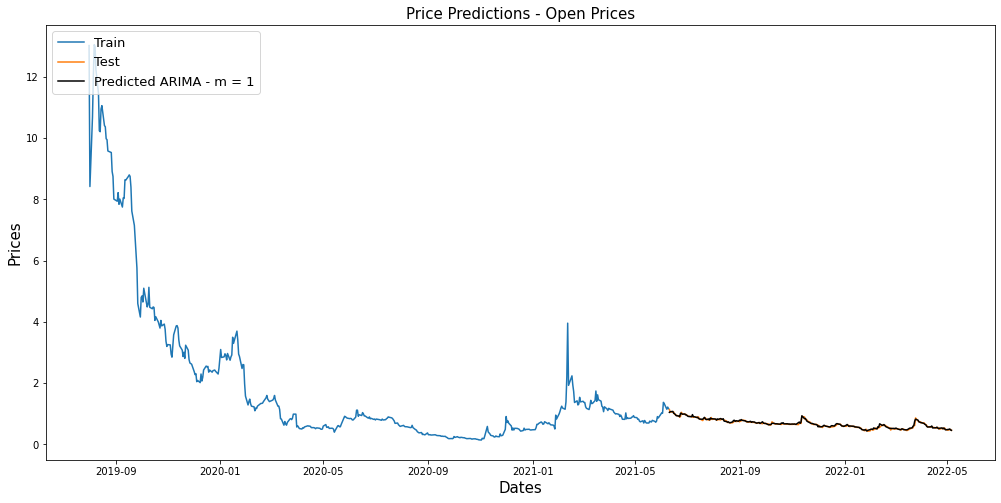

SNDL
Evaluation:

  2  from  62

----------------------------------------------------------------------------------------------------
Company:  MSFT 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=2413.897, Time=0.30 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2435.158, Time=0.22 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2412.174, Time=0.25 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2409.179, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2434.213, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2410.083, Time=0.23 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=2410.654, Time=0.10 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=2412.606, Time=0.26 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2407.291, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2408.898, Time=0.16 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=2408.798, Time=0.12 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2410.971, Time=0.05 se

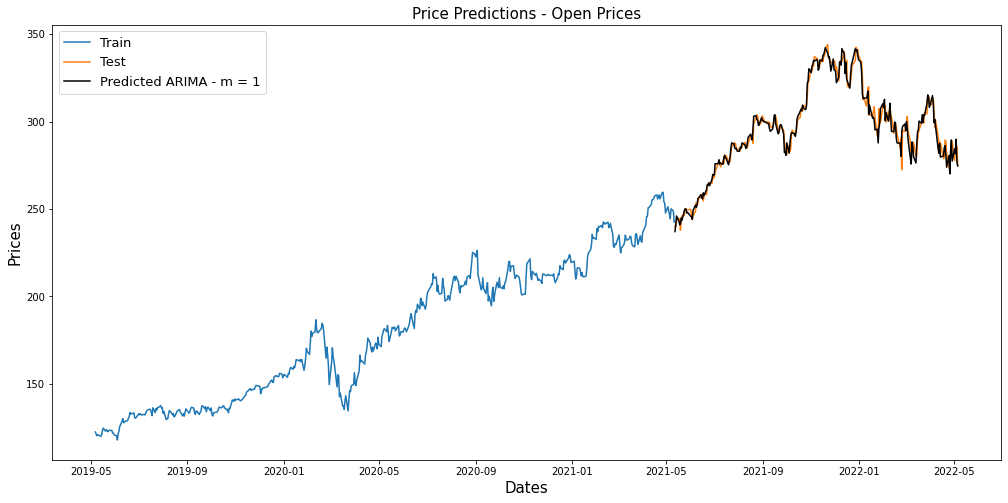

MSFT
Evaluation:

  3  from  62

----------------------------------------------------------------------------------------------------
Company:  SNAP 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1639.307, Time=0.51 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1639.933, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1641.853, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1641.837, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1637.972, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1643.719, Time=0.24 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 1.256 seconds
----------------------------------------------------------------------------------------------------
Testing data
Evaluation:

RMSE : 1.648764589321696
MAPE : 0.39251735360604356


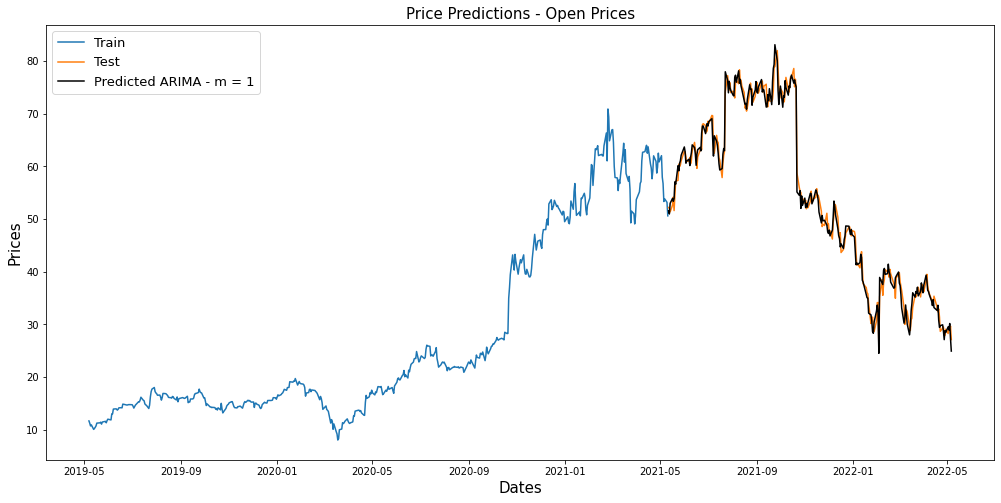

SNAP
Evaluation:

  4  from  62

----------------------------------------------------------------------------------------------------
Company:  BB 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=588.122, Time=0.37 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=641.590, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=632.631, Time=0.13 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=626.738, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=640.592, Time=0.06 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=597.191, Time=0.34 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=588.296, Time=0.32 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=575.418, Time=0.45 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=588.191, Time=0.28 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=563.535, Time=0.55 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=569.194, Time=0.54 sec
 ARIMA(5,0,2)(0,0,0)[0] intercept   : AIC=565.107, Time=0.65 sec
 ARIMA(4,0,3

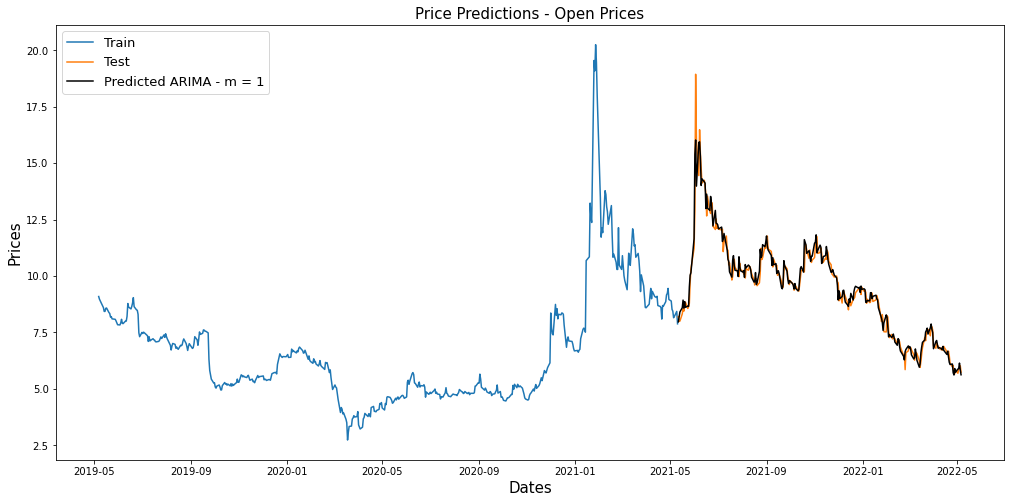

BB
Evaluation:

  5  from  62

----------------------------------------------------------------------------------------------------
Company:  WMT 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1893.170, Time=0.31 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1891.043, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1892.848, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1892.848, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1889.052, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1894.842, Time=0.08 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.736 seconds
----------------------------------------------------------------------------------------------------
Testing data
Evaluation:

RMSE : 1.3789956160915209
MAPE : 0.04418279885031709


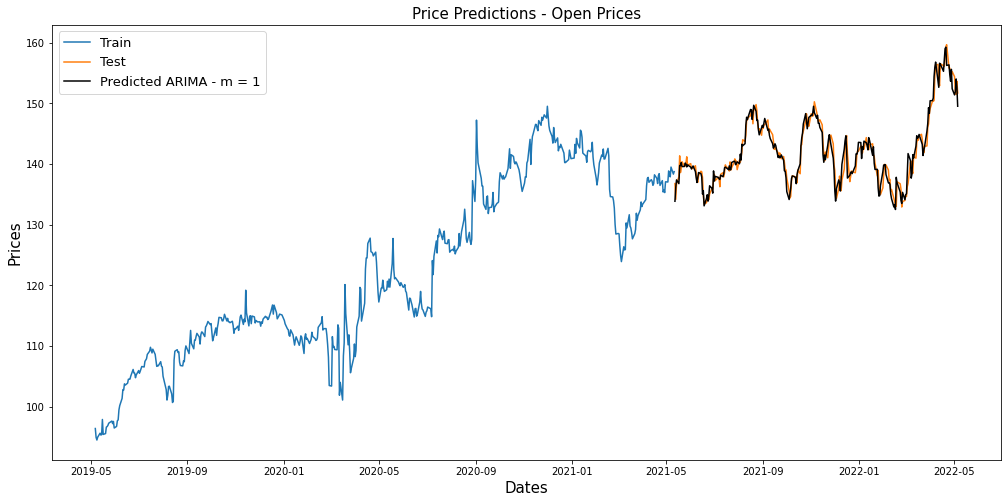

WMT
Evaluation:

  6  from  62

----------------------------------------------------------------------------------------------------
Company:  PTON 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=2303.977, Time=0.50 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2310.841, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2310.299, Time=0.21 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2310.132, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2308.922, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=2314.103, Time=0.21 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=2310.192, Time=0.24 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=2313.955, Time=0.46 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=2305.987, Time=0.43 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2311.968, Time=0.19 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=2307.809, Time=0.36 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=2312.297, Time=0.42 sec

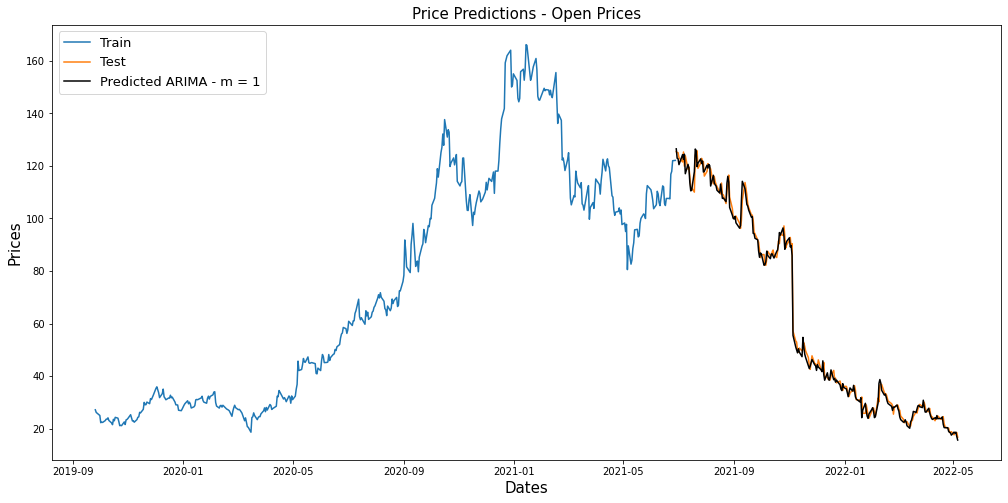

PTON
Evaluation:

  7  from  62

----------------------------------------------------------------------------------------------------
Company:  RYCEY 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-978.267, Time=0.46 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-978.138, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-979.711, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-979.311, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-980.138, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-974.370, Time=0.20 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.970 seconds
----------------------------------------------------------------------------------------------------
Testing data
Evaluation:

RMSE : 0.03108731443841853
MAPE : 0.16410786719281586


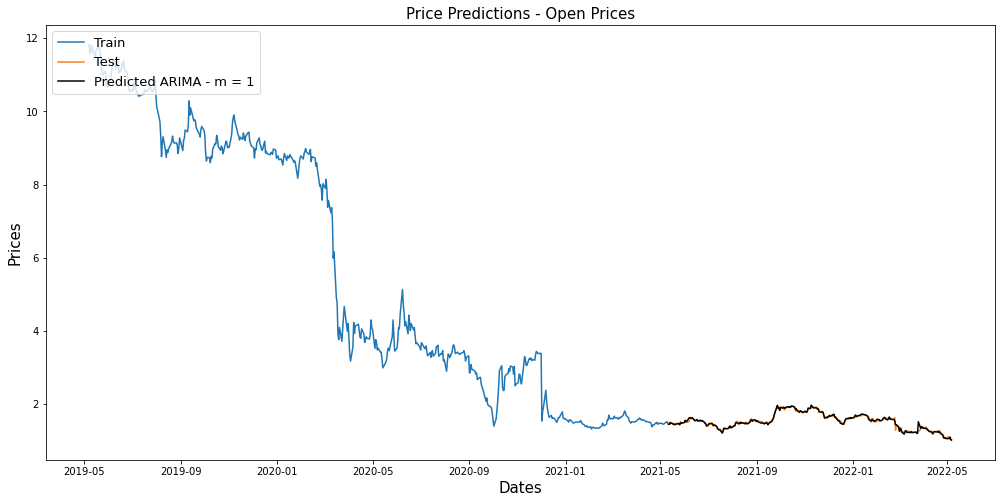

RYCEY
Evaluation:

  8  from  62

----------------------------------------------------------------------------------------------------
Company:  CPRX 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-421.373, Time=0.41 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-412.278, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-412.265, Time=0.15 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-412.680, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-403.418, Time=0.06 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-412.469, Time=0.33 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-413.277, Time=0.35 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-418.222, Time=0.47 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-409.891, Time=0.45 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-411.469, Time=0.11 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-411.199, Time=0.39 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-411.998, Time=0.54 s

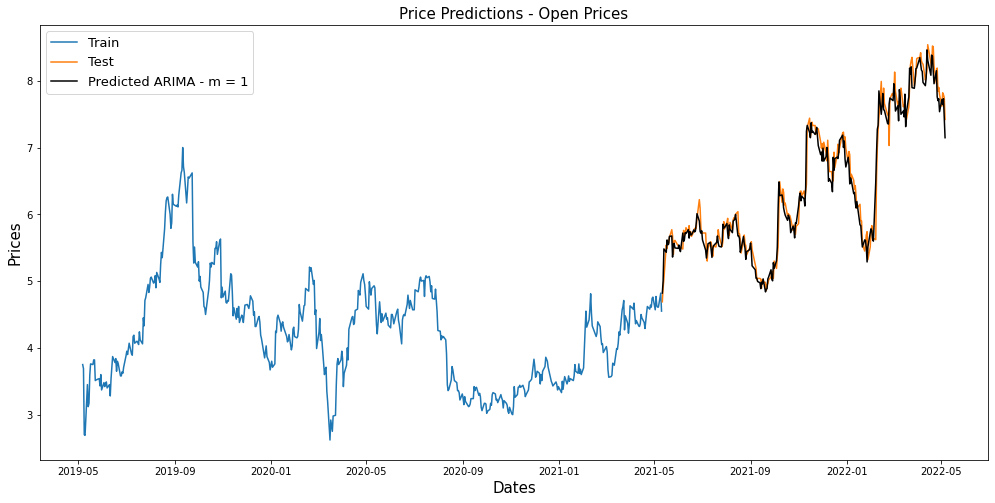

CPRX
Evaluation:

  9  from  62

----------------------------------------------------------------------------------------------------
Company:  AAPL 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1897.658, Time=0.40 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1907.050, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1901.018, Time=0.17 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1899.557, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1906.887, Time=0.11 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1901.297, Time=0.44 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1903.081, Time=0.35 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=1896.482, Time=0.49 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=1899.458, Time=0.60 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=1897.538, Time=0.56 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=1899.403, Time=0.49 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=1897.585, Time=0.46 se

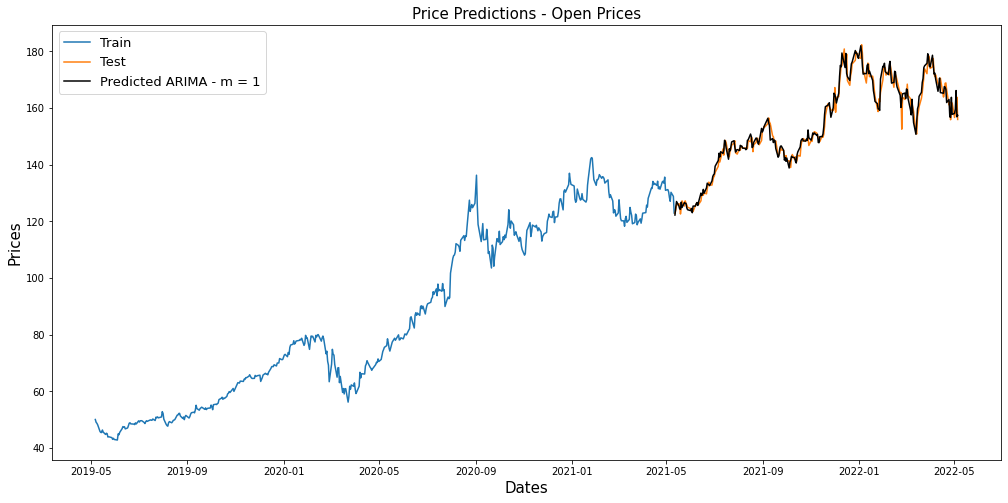

AAPL
Evaluation:

  10  from  62

----------------------------------------------------------------------------------------------------
Company:  HOOD 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=593.969, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=595.448, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=595.261, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=593.711, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=593.950, Time=0.15 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.572 seconds
----------------------------------------------------------------------------------------------------
Testing data
Evaluation:

RMSE : 0.6702761065006828
MAPE : 0.1359077771984698


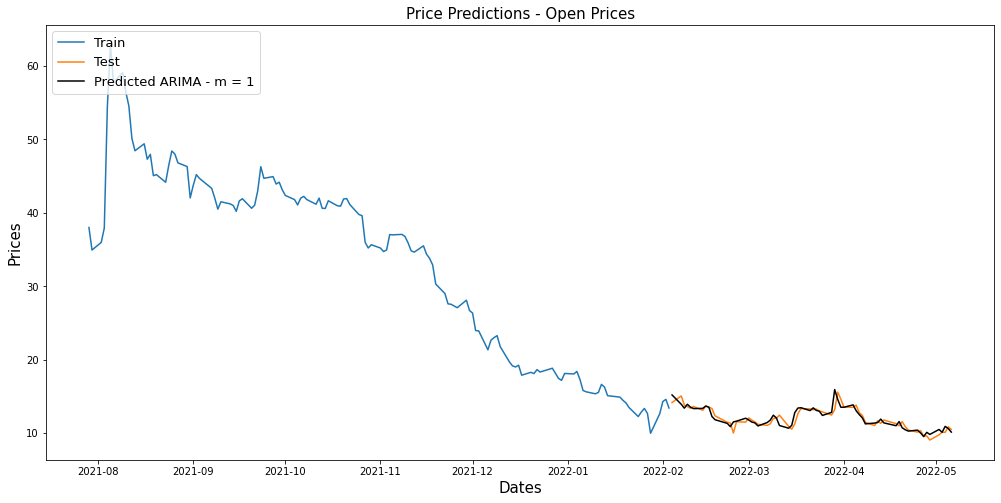

HOOD
Evaluation:

  11  from  62

----------------------------------------------------------------------------------------------------
Company:  RIVN 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=512.986, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=512.352, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=513.591, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=513.522, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=513.088, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=512.334, Time=0.12 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=511.828, Time=0.15 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=515.226, Time=0.09 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=512.639, Time=0.16 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=513.907, Time=0.12 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=512.978, Time=0.18 sec
 ARIMA(2,0,1)

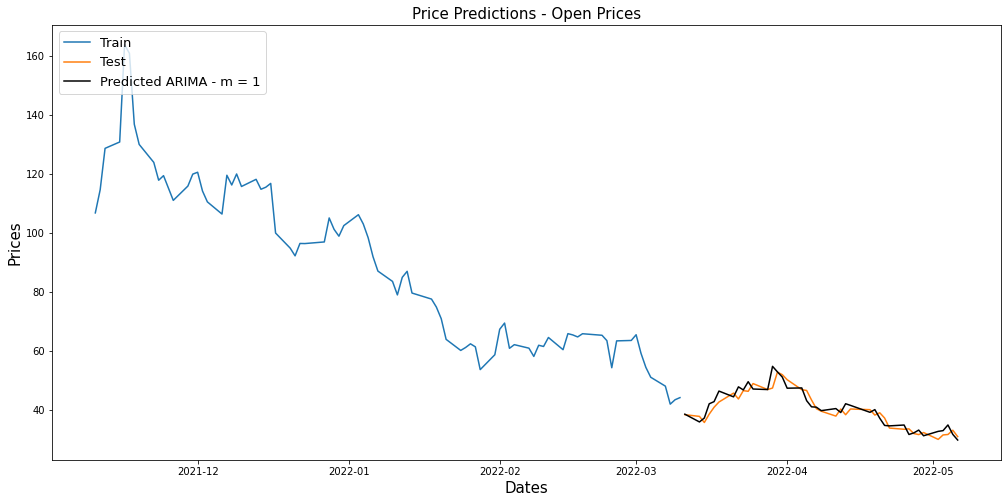

RIVN
Evaluation:

  12  from  62

----------------------------------------------------------------------------------------------------
Company:  WISHTSLA 

- WISHTSLA: No data found, symbol may be delisted
 No data for company: Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []
 No data for company: WISHTSLA
  13  from  62

----------------------------------------------------------------------------------------------------
Company:  AMC 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=577.528, Time=0.38 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=588.072, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=586.253, Time=0.14 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=587.033, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=587.362, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=576.430, Time=0.25 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=581.859, Time=0.11 sec
 ARIMA(1,0,1)(0

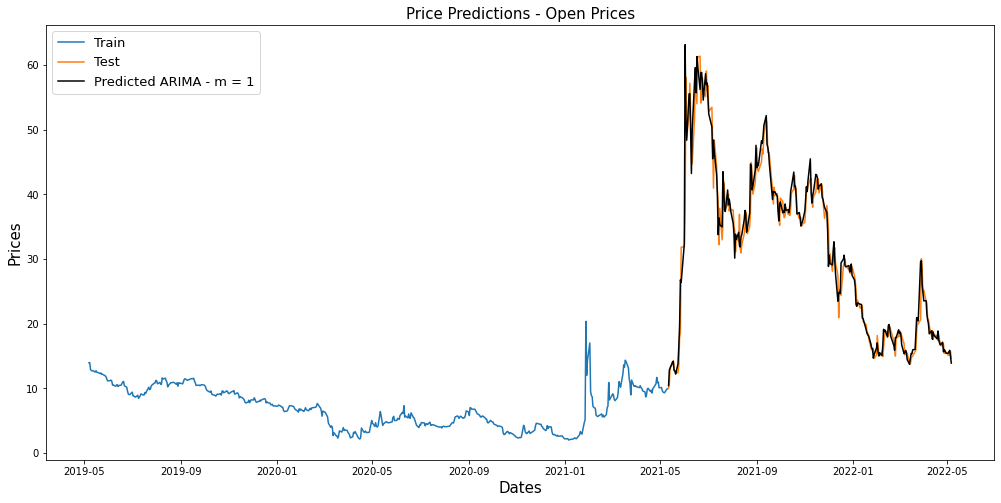

AMC
Evaluation:

  14  from  62

----------------------------------------------------------------------------------------------------
Company:  F 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-423.353, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-416.012, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-421.605, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-423.156, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-412.799, Time=0.07 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-422.743, Time=0.25 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-424.016, Time=0.38 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-422.050, Time=0.46 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-425.057, Time=0.21 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-424.785, Time=0.19 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-423.193, Time=0.42 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-420.869, Time=0.13 sec



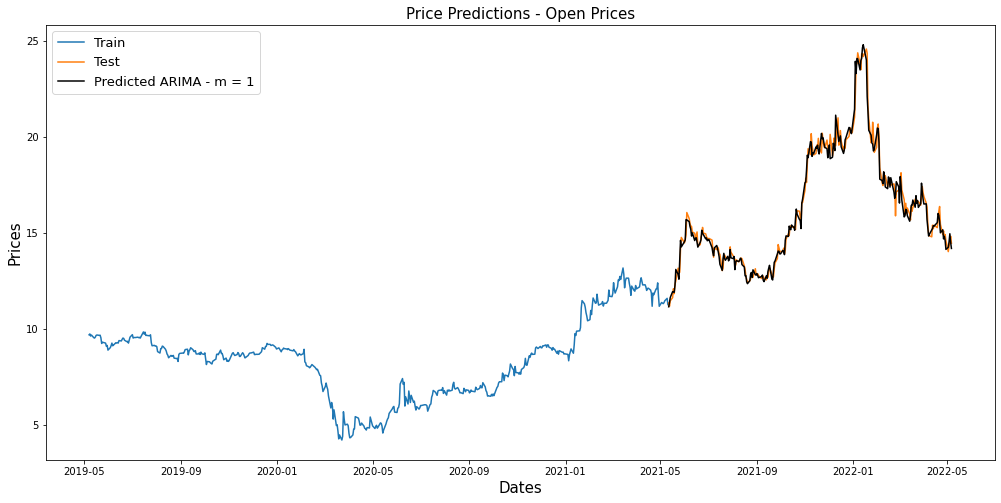

F
Evaluation:

  15  from  62

----------------------------------------------------------------------------------------------------
Company:  AMZN 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=5229.841, Time=0.35 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=5232.031, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=5230.755, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=5230.599, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=5230.093, Time=0.10 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=5229.111, Time=0.23 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=5232.369, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=5232.138, Time=0.07 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=5226.801, Time=0.47 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=5233.407, Time=0.11 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=5228.916, Time=0.32 sec
 ARIMA(1,0,4)(0,0,0)[0] intercept   : AIC=5228.886, Time=0.13 sec


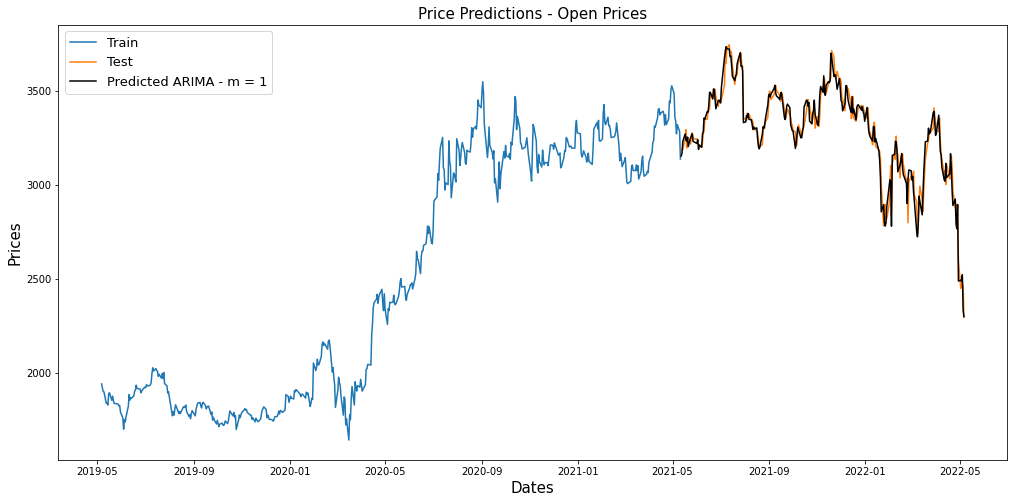

AMZN
Evaluation:

  16  from  62

----------------------------------------------------------------------------------------------------
Company:  DIS 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=2200.760, Time=0.43 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2215.558, Time=0.13 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2199.455, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2196.425, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2213.566, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2197.148, Time=0.17 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=2197.017, Time=0.21 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=2198.352, Time=0.14 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2194.431, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2195.161, Time=0.07 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=2195.041, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2197.463, Time=0.03 se

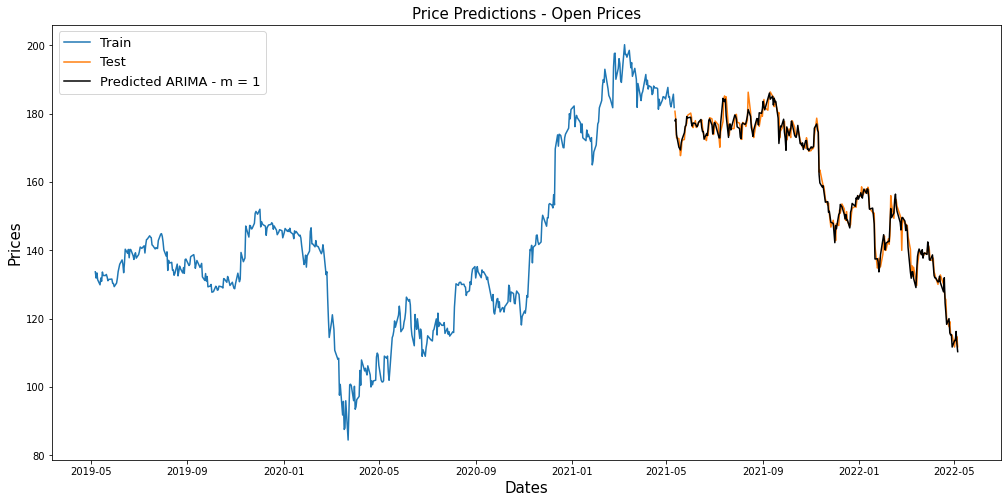

DIS
Evaluation:

  17  from  62

----------------------------------------------------------------------------------------------------
Company:  NIO 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1619.151, Time=0.43 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1677.367, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1642.823, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1638.600, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1675.381, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1640.583, Time=0.35 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1642.697, Time=0.32 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=1621.700, Time=0.50 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=1619.707, Time=0.47 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1640.402, Time=0.28 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=1633.145, Time=0.43 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=1630.742, Time=0.31 sec

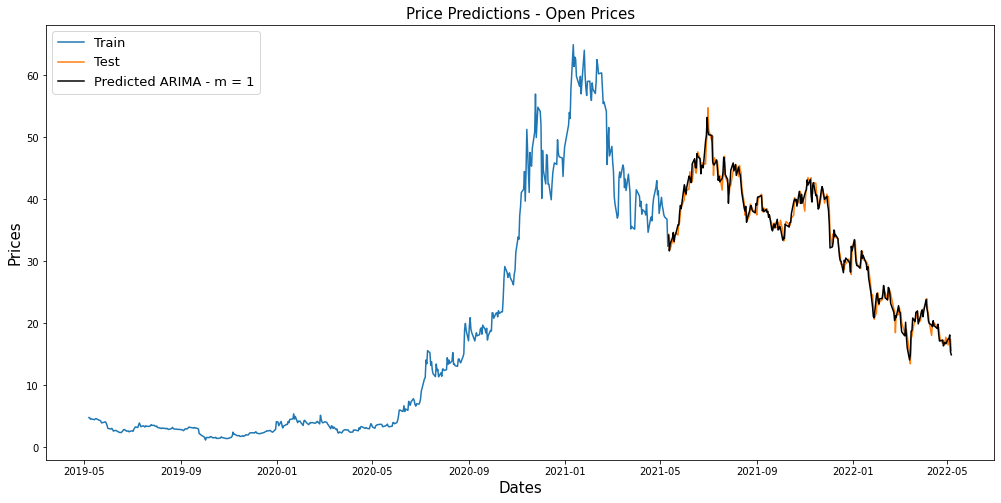

NIO
Evaluation:

  18  from  62

----------------------------------------------------------------------------------------------------
Company:  LCID 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1021.271, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1026.204, Time=0.13 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1019.987, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1021.227, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1025.645, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1020.167, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1020.732, Time=0.18 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1022.163, Time=0.14 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1019.717, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1020.066, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1020.594, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1020.865, Time=0.04 se

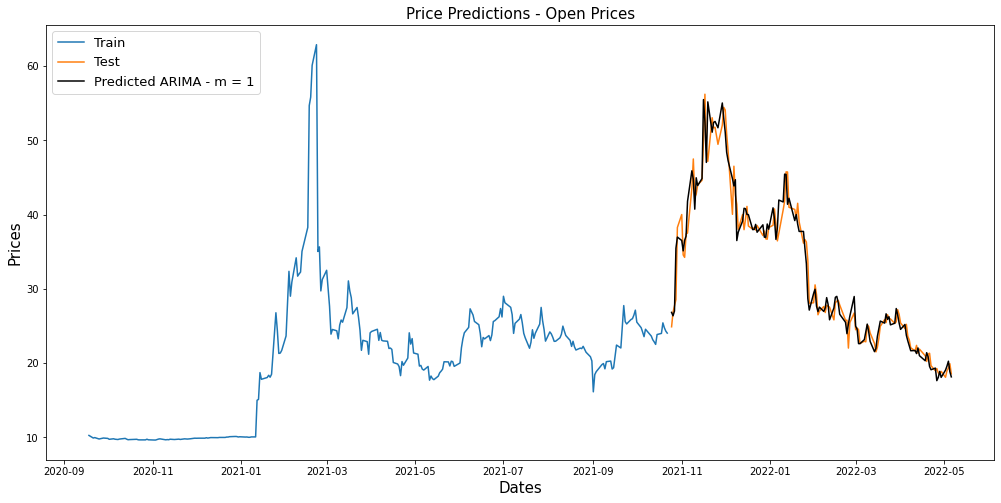

LCID
Evaluation:

  19  from  62

----------------------------------------------------------------------------------------------------
Company:  PFE 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=629.084, Time=0.72 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=627.439, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=629.389, Time=0.23 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=631.627, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=627.652, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=631.396, Time=0.27 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 1.443 seconds
----------------------------------------------------------------------------------------------------
Testing data
Evaluation:

RMSE : 0.7798428566440506
MAPE : 0.150296121357204


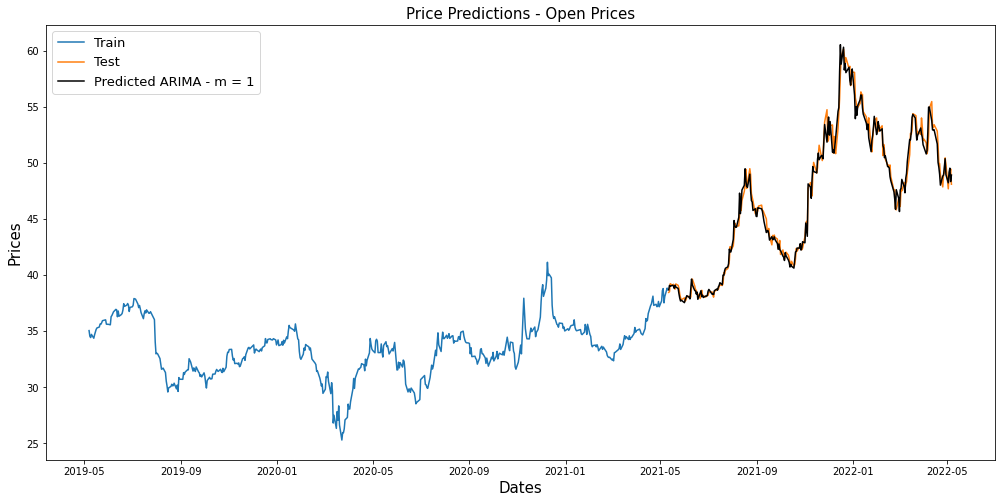

PFE
Evaluation:

  20  from  62

----------------------------------------------------------------------------------------------------
Company:  FB 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=2826.126, Time=0.48 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2830.310, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2827.300, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2826.894, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2828.628, Time=0.12 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=2825.420, Time=0.52 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=2827.892, Time=0.29 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2826.222, Time=0.09 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=2823.059, Time=0.33 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=2825.401, Time=0.12 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=2824.319, Time=0.14 sec
 ARIMA(1,0,4)(0,0,0)[0] intercept   : AIC=2825.020, Time=0.30 sec


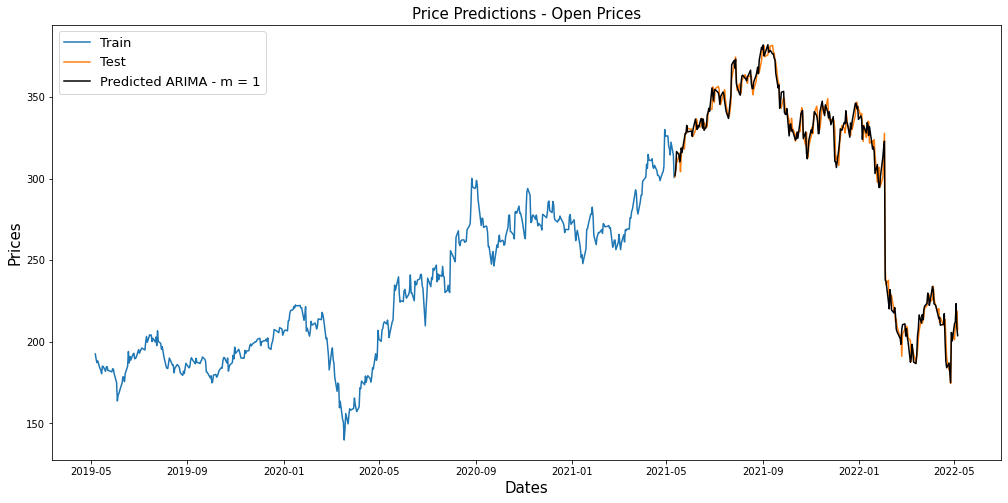

FB
Evaluation:

  21  from  62

----------------------------------------------------------------------------------------------------
Company:  NFLX 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=3646.591, Time=0.33 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=3655.158, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=3649.929, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=3649.339, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3653.269, Time=0.10 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=3647.170, Time=0.41 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=3650.195, Time=0.36 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=3646.431, Time=0.39 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=3642.659, Time=0.41 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=3650.086, Time=0.24 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=3644.399, Time=0.49 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=3651.216, Time=0.12 sec

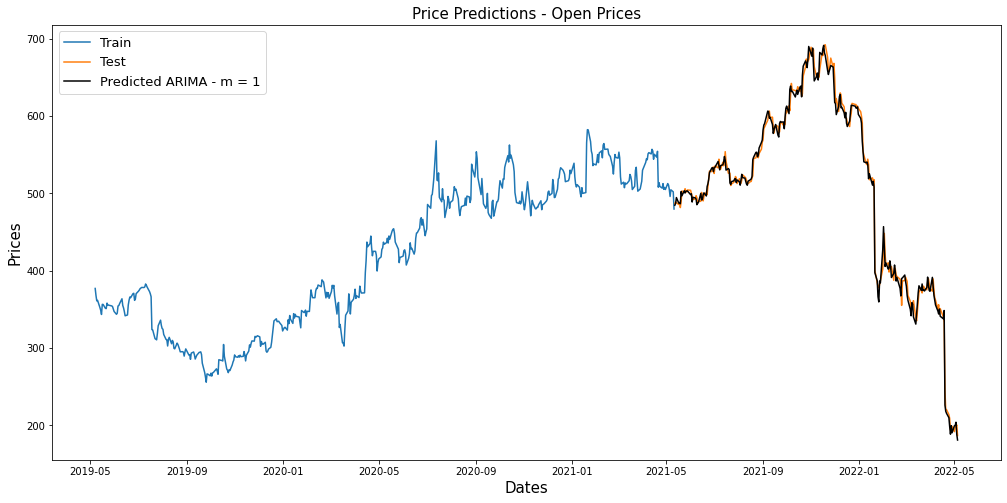

NFLX
Evaluation:

  22  from  62

----------------------------------------------------------------------------------------------------
Company:  AAL 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1013.050, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1010.676, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1008.773, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1008.281, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1013.269, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1009.391, Time=0.24 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=1008.980, Time=0.22 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1010.950, Time=0.35 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1011.326, Time=0.12 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 1.496 seconds
----------------------------------------------------------------------------------------------------
Testing data
Evalu

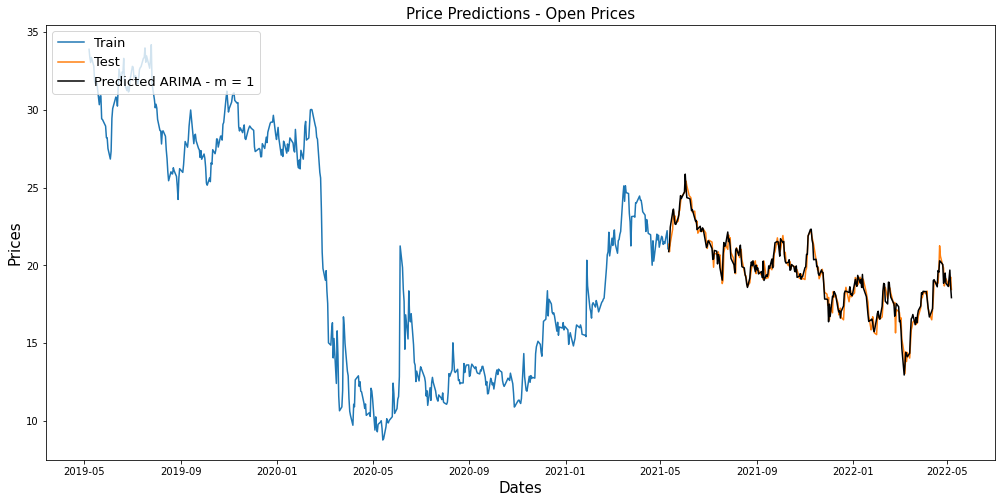

AAL
Evaluation:

  23  from  62

----------------------------------------------------------------------------------------------------
Company:  NVDA 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=2259.654, Time=0.45 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2264.000, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2259.145, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2259.216, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2262.098, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=2261.082, Time=0.22 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2261.242, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=2263.095, Time=0.17 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2257.351, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=2259.346, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2259.347, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2257.484, Time=0.09 se

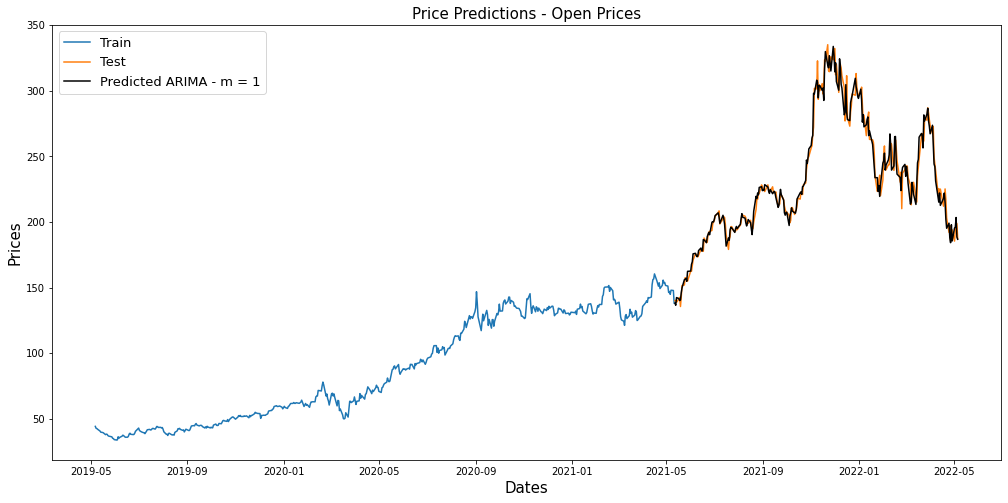

NVDA
Evaluation:

  24  from  62

----------------------------------------------------------------------------------------------------
Company:  PLUG 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1527.735, Time=0.43 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1560.427, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1555.818, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1557.260, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1558.459, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1537.351, Time=0.38 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1547.648, Time=0.17 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=1527.118, Time=0.45 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=1541.109, Time=0.41 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=1525.507, Time=0.52 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=1539.230, Time=0.48 sec
 ARIMA(5,0,2)(0,0,0)[0] intercept   : AIC=1529.031, Time=0.68 s

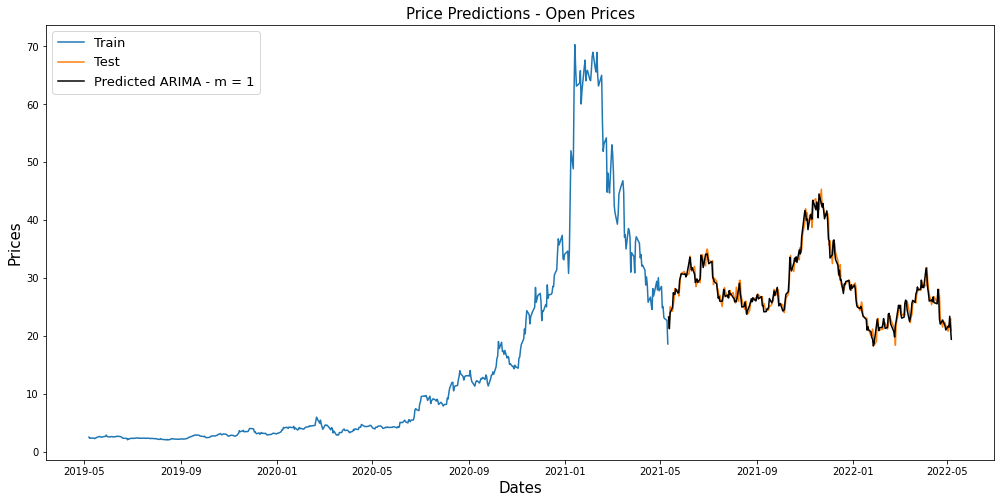

PLUG
Evaluation:

  25  from  62

----------------------------------------------------------------------------------------------------
Company:  GPRO 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=118.452, Time=0.39 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=126.693, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=123.418, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=123.415, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=126.853, Time=0.07 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=119.444, Time=0.42 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=124.751, Time=0.37 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=113.631, Time=0.47 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=112.577, Time=0.40 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=113.963, Time=0.18 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=113.709, Time=0.42 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=125.347, Time=0.21 sec
 ARIMA(4,

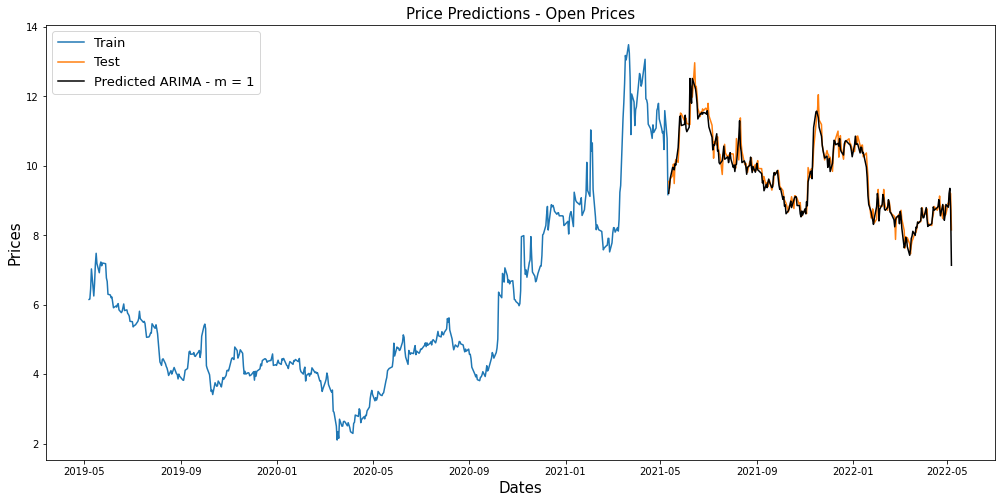

GPRO
Evaluation:

  26  from  62

----------------------------------------------------------------------------------------------------
Company:  BABA 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=2699.283, Time=0.45 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2695.443, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2693.485, Time=0.19 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2694.603, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2694.899, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=2695.343, Time=0.29 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2695.311, Time=0.22 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=2698.547, Time=0.21 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2692.826, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=2694.674, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2694.646, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2692.704, Time=0.03 s

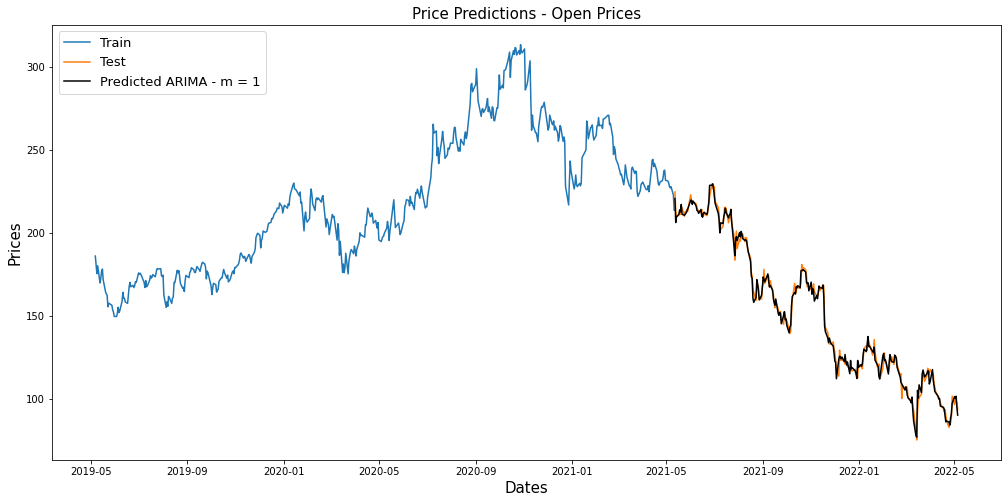

BABA
Evaluation:

  27  from  62

----------------------------------------------------------------------------------------------------
Company:  CCL 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1179.811, Time=0.52 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1182.456, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1183.765, Time=0.13 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1183.764, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1186.031, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1187.761, Time=0.22 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1187.764, Time=0.20 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=1187.106, Time=0.46 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=1189.532, Time=0.58 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1185.767, Time=0.18 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=1189.373, Time=0.31 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=1189.395, Time=0.25 se

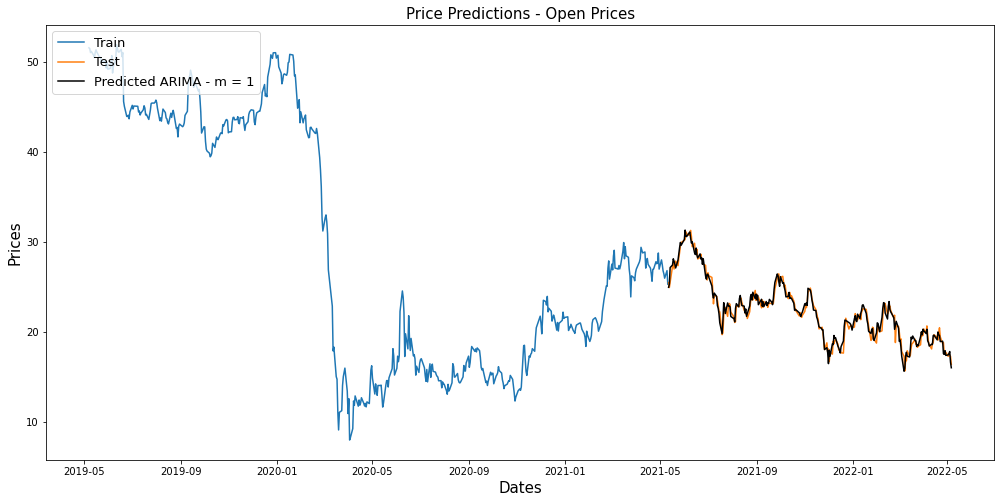

CCL
Evaluation:

  28  from  62

----------------------------------------------------------------------------------------------------
Company:  ACB 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1722.416, Time=0.44 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1736.071, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1731.776, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1728.915, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1734.967, Time=0.06 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1720.546, Time=0.31 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=1719.208, Time=0.14 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=1720.378, Time=0.29 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1719.130, Time=0.26 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1720.428, Time=0.38 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1721.566, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1718.931, Time=0.29 sec

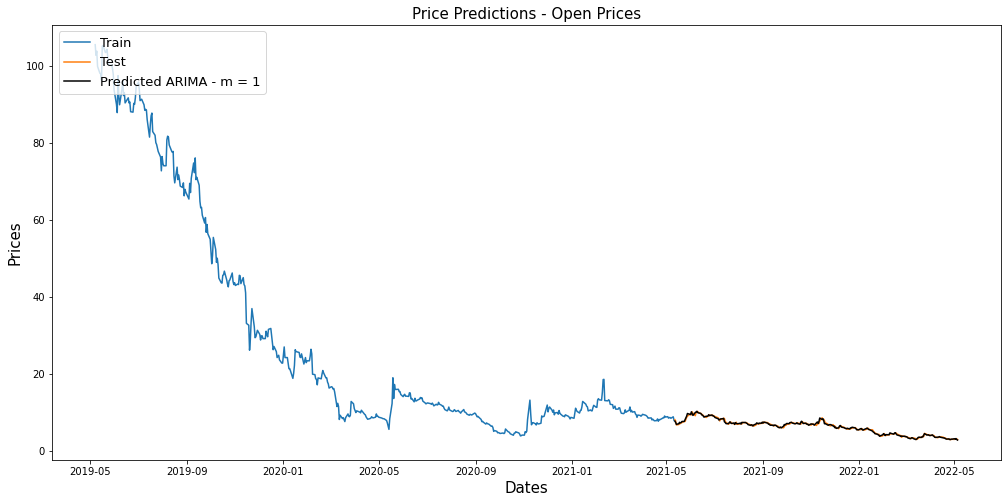

ACB
Evaluation:

  29  from  62

----------------------------------------------------------------------------------------------------
Company:  ZOM 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-1465.197, Time=0.44 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-1440.889, Time=0.14 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-1446.247, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-1445.509, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-1440.694, Time=0.07 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-1444.224, Time=0.34 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-1443.030, Time=0.39 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-1449.582, Time=0.54 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-1443.012, Time=0.55 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-1444.850, Time=0.06 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-1442.427, Time=0.43 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-1442.476, T

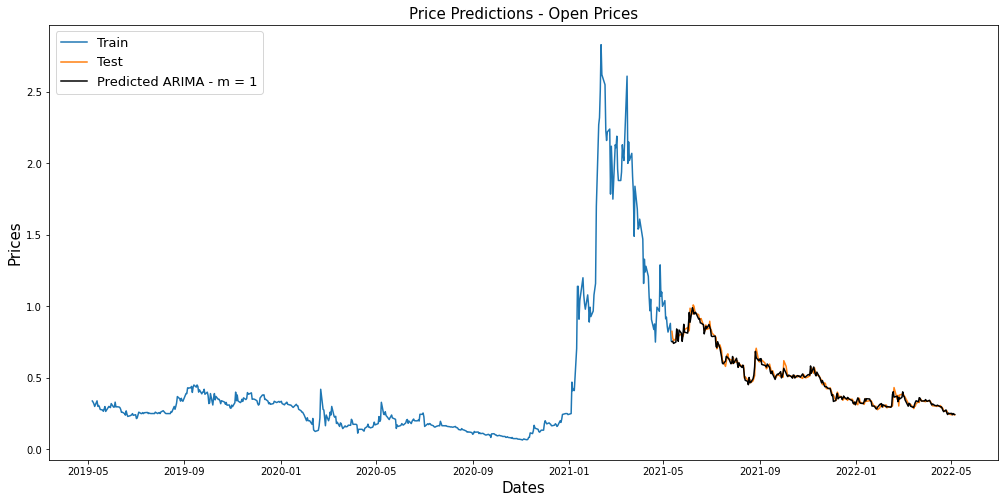

ZOM
Evaluation:

  30  from  62

----------------------------------------------------------------------------------------------------
Company:  VOO 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=2424.270, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2429.938, Time=0.14 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2419.008, Time=0.17 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2418.258, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2428.459, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2419.506, Time=0.10 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=2419.669, Time=0.12 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=2421.632, Time=0.26 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2416.256, Time=0.14 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2417.501, Time=0.11 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=2417.637, Time=0.15 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2417.297, Time=0.09 sec

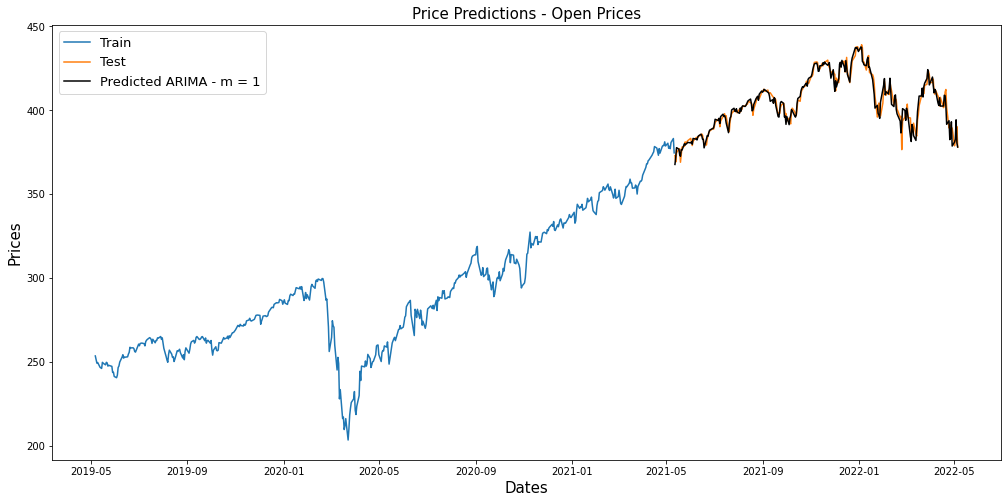

VOO
Evaluation:

  31  from  62

----------------------------------------------------------------------------------------------------
Company:  NOK 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-921.294, Time=0.44 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-900.653, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-925.782, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-926.863, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-895.472, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-924.941, Time=0.22 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-925.000, Time=0.21 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-922.947, Time=0.25 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-925.080, Time=0.10 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 1.811 seconds
----------------------------------------------------------------------------------------------------
Testing data
Evalua

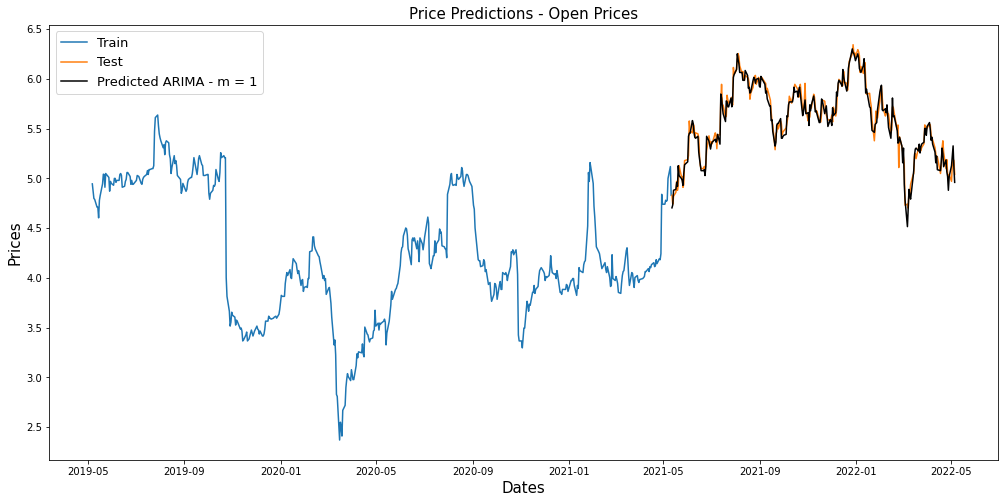

NOK
Evaluation:

  32  from  62

----------------------------------------------------------------------------------------------------
Company:  SPY 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=2503.480, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2507.342, Time=0.16 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2498.795, Time=0.22 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2498.096, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2505.896, Time=0.15 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2498.647, Time=0.09 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=2499.114, Time=0.10 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=2500.963, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2496.093, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2496.634, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=2497.093, Time=0.18 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2497.151, Time=0.04 sec

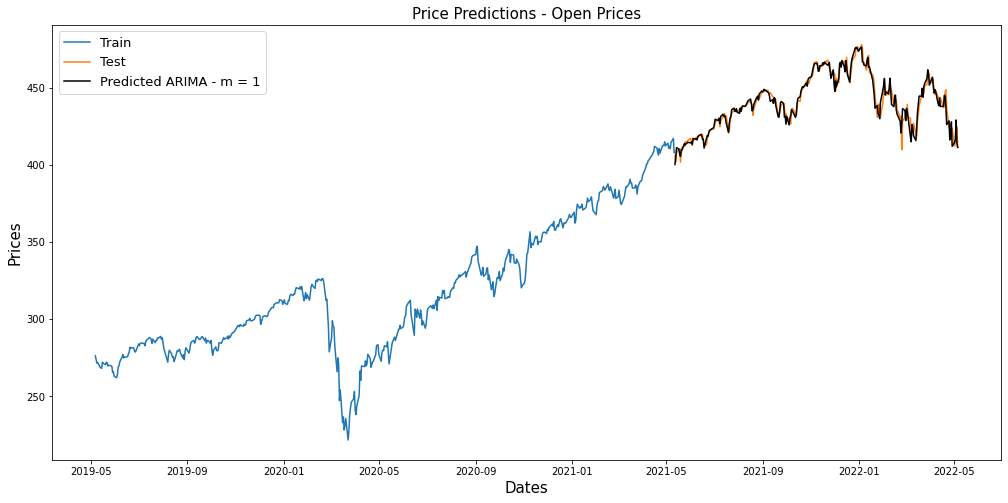

SPY
Evaluation:

  33  from  62

----------------------------------------------------------------------------------------------------
Company:  DAL 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1381.234, Time=0.38 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1373.963, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1375.514, Time=0.26 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1375.442, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1377.615, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1377.719, Time=0.13 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 1.048 seconds
----------------------------------------------------------------------------------------------------
Testing data
Evaluation:

RMSE : 0.8387031851569708
MAPE : 0.08806666900977829


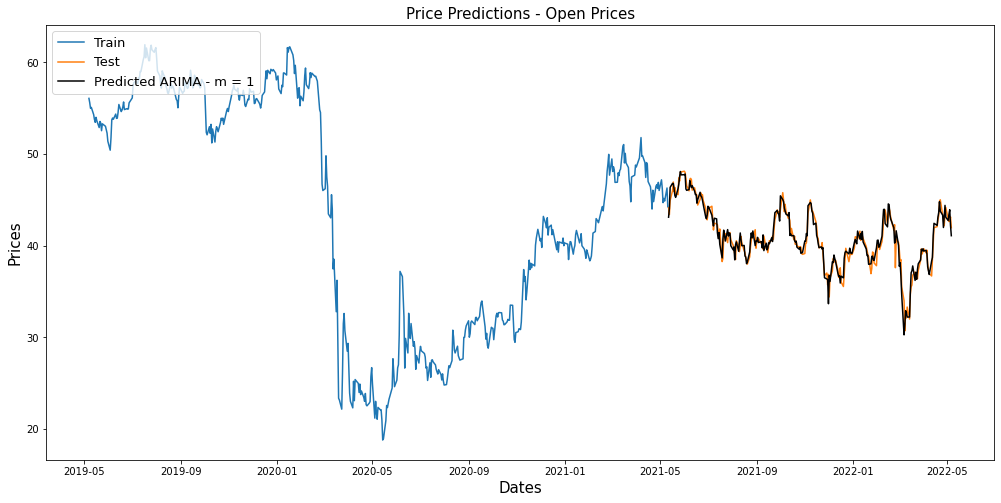

DAL
Evaluation:

  34  from  62

----------------------------------------------------------------------------------------------------
Company:  BAC 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=633.863, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=634.084, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=631.663, Time=0.21 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=631.199, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=635.896, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=630.159, Time=0.35 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=624.725, Time=0.37 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=632.530, Time=0.27 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=635.444, Time=0.34 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=633.021, Time=0.43 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=633.669, Time=0.40 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=634.864, Time=0.51 sec
 ARIMA(2,0,

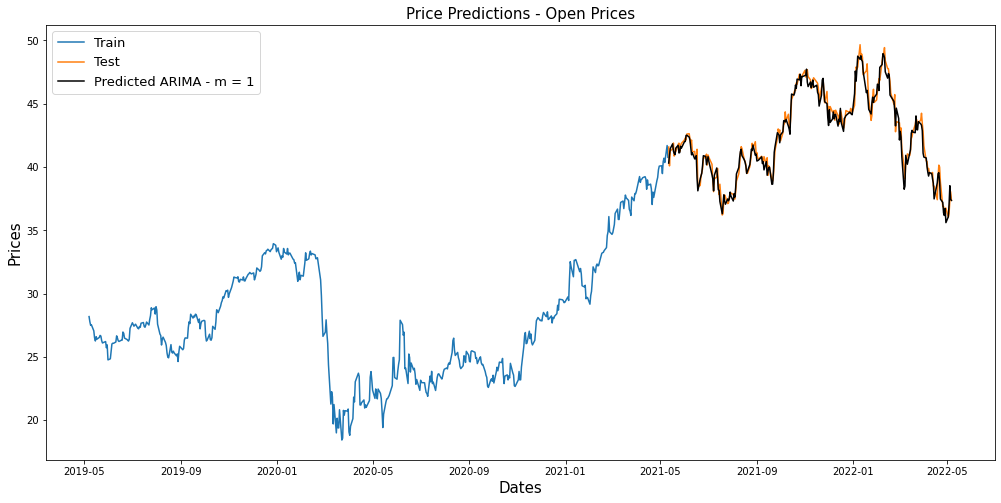

BAC
Evaluation:

  35  from  62

----------------------------------------------------------------------------------------------------
Company:  PLTR 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=846.205, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=859.609, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=860.569, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=860.700, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=857.821, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=861.358, Time=0.18 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=863.109, Time=0.22 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=847.806, Time=0.28 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=847.410, Time=0.29 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=862.315, Time=0.14 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=857.460, Time=0.25 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=861.419, Time=0.26 sec
 ARIMA(3,0

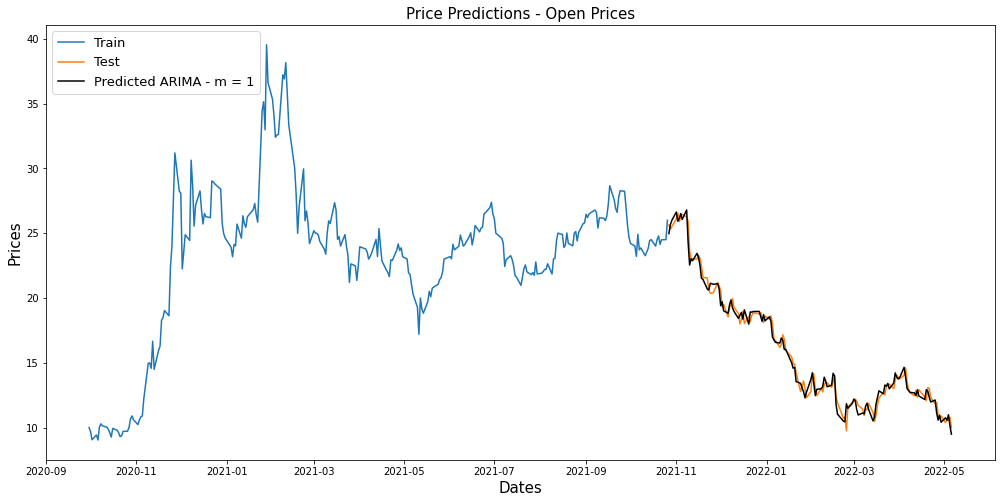

PLTR
Evaluation:

  36  from  62

----------------------------------------------------------------------------------------------------
Company:  GME 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=3733.030, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=3719.706, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=3722.747, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3731.281, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=3712.276, Time=0.13 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=3703.493, Time=0.17 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=3681.402, Time=0.19 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=3682.954, Time=0.25 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=3682.973, Time=0.19 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=3692.699, Time=0.33 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=3684.952, Time=0.28 sec
 AR

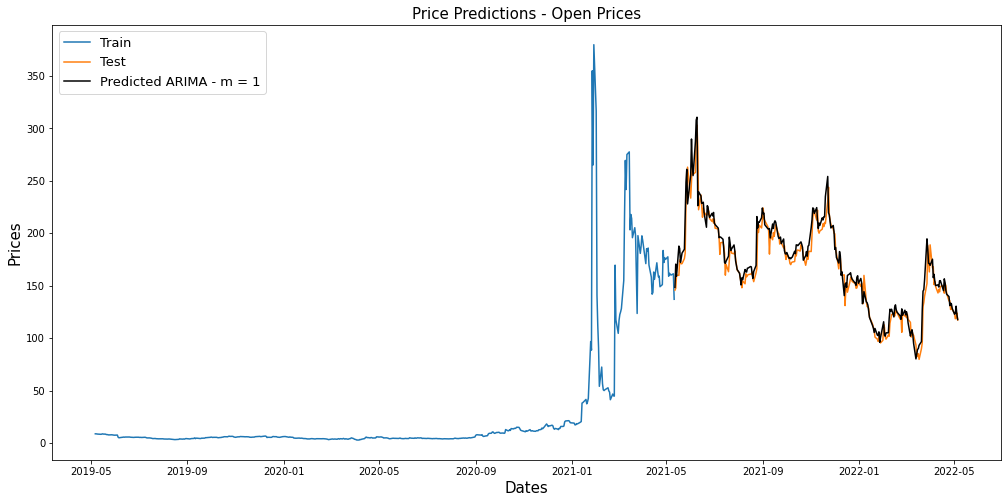

GME
Evaluation:

  37  from  62

----------------------------------------------------------------------------------------------------
Company:  SBUX 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1600.943, Time=0.59 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1608.584, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1600.686, Time=0.14 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1601.047, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1609.412, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1600.893, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1598.999, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1601.210, Time=0.11 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1601.198, Time=0.12 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=1599.695, Time=0.20 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1597.390, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1599.167, Time=0.07 se

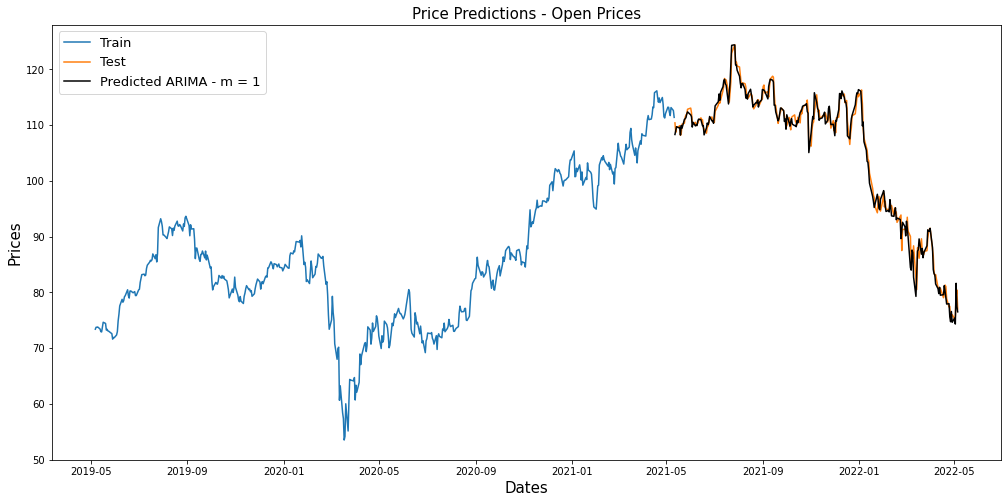

SBUX
Evaluation:

  38  from  62

----------------------------------------------------------------------------------------------------
Company:  AMD 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1899.870, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1900.853, Time=0.12 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1894.209, Time=0.19 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1893.988, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1898.956, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1895.957, Time=0.25 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=1895.966, Time=0.22 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1897.976, Time=0.25 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1892.356, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1894.348, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1894.346, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1892.533, Time=0.02 se

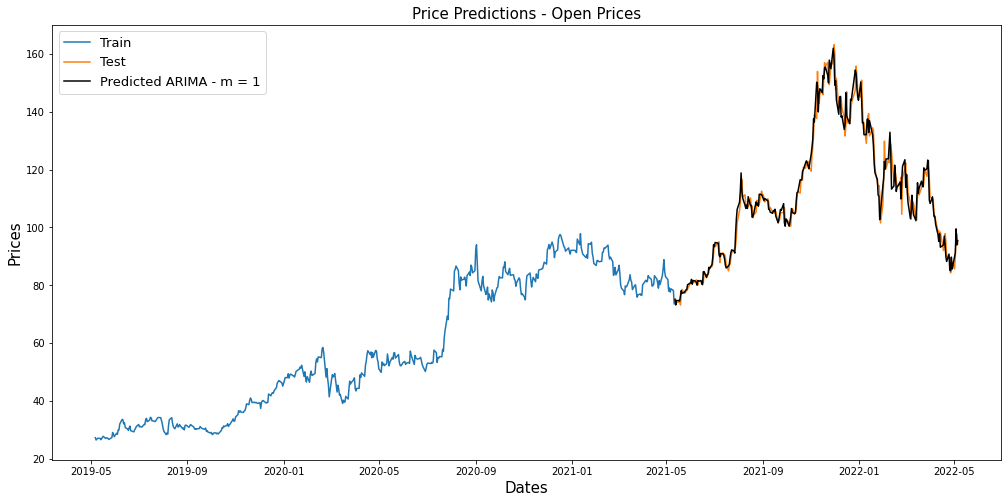

AMD
Evaluation:

  39  from  62

----------------------------------------------------------------------------------------------------
Company:  OGI 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-241.249, Time=0.48 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-205.858, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-206.742, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-208.922, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-207.356, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-243.076, Time=0.33 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-233.613, Time=0.16 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-242.168, Time=0.44 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=-242.864, Time=0.48 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-242.509, Time=0.35 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-240.347, Time=0.48 sec
 ARI

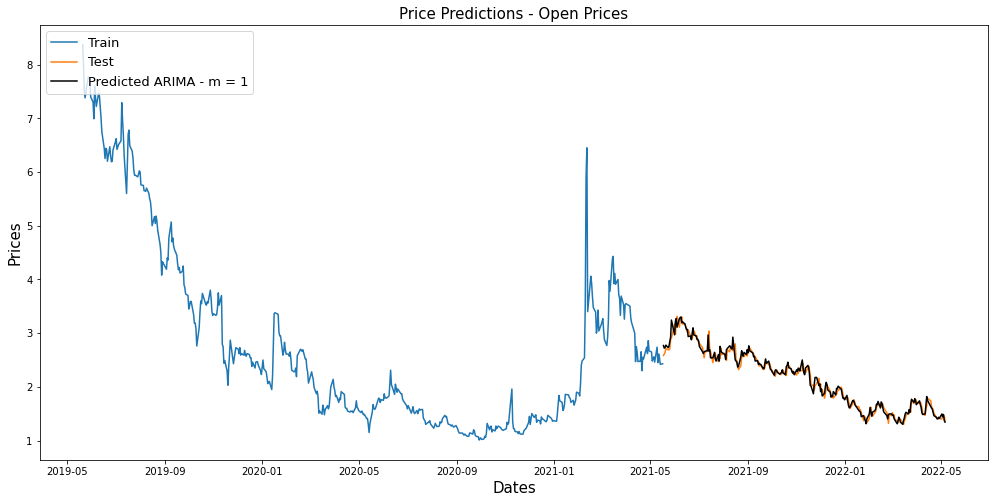

OGI
Evaluation:

  40  from  62

----------------------------------------------------------------------------------------------------
Company:  TLRY 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1853.189, Time=0.37 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1878.954, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1880.843, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1880.752, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1877.247, Time=0.11 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1859.769, Time=0.34 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1856.733, Time=0.20 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=1847.923, Time=0.48 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=1846.115, Time=0.44 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=1855.651, Time=0.22 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=1847.379, Time=0.49 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1856.369, Time=0.11 se

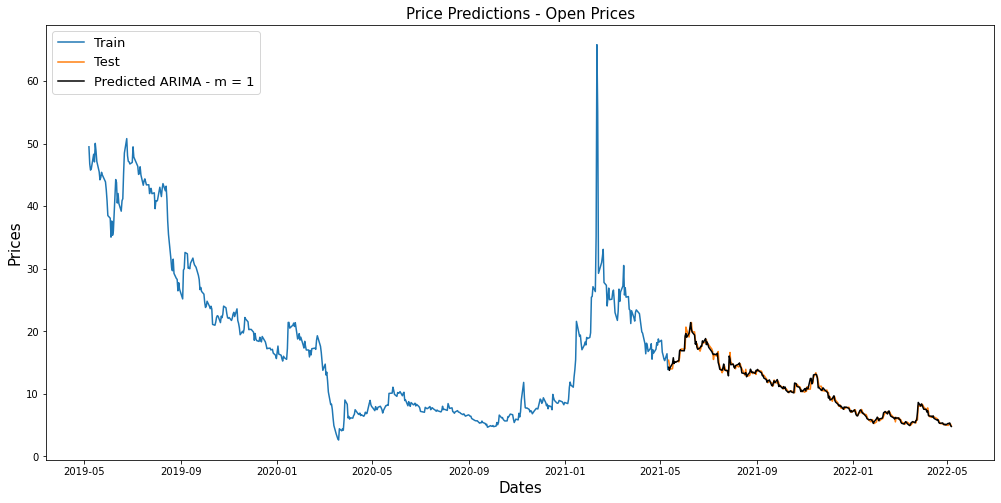

TLRY
Evaluation:

  41  from  62

----------------------------------------------------------------------------------------------------
Company:  COIN 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1325.453, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1332.932, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1329.248, Time=0.13 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1329.312, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1330.972, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1332.369, Time=0.12 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1330.060, Time=0.15 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=1327.758, Time=0.24 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=1327.451, Time=0.26 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1336.390, Time=0.12 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=1330.982, Time=0.22 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=1328.402, Time=0.22 s

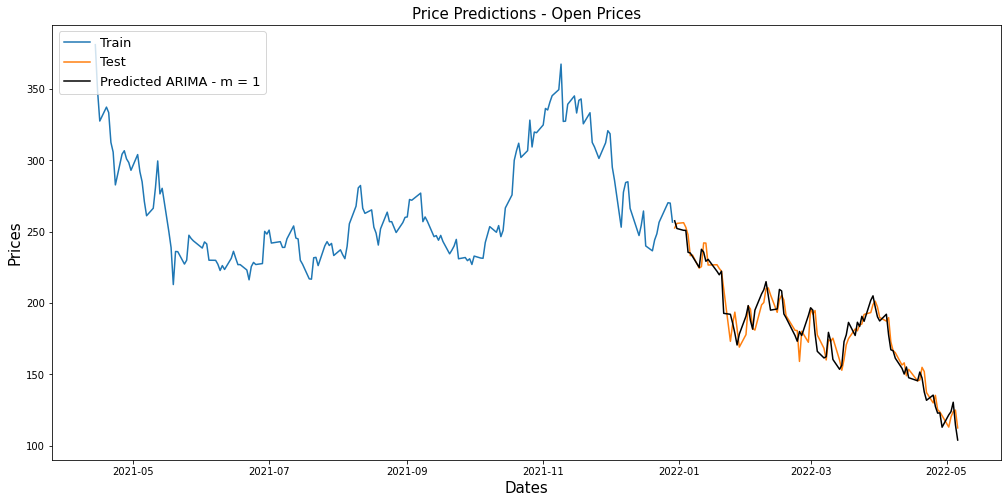

COIN
Evaluation:

  42  from  62

----------------------------------------------------------------------------------------------------
Company:  TWTR 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1464.642, Time=0.46 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1479.499, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1479.796, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1480.270, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1477.597, Time=0.06 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1463.332, Time=0.39 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=1464.851, Time=0.22 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1466.818, Time=0.34 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=1468.851, Time=0.28 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=1465.554, Time=0.20 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1462.527, Time=0.32 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1463.917, Time=0.11 s

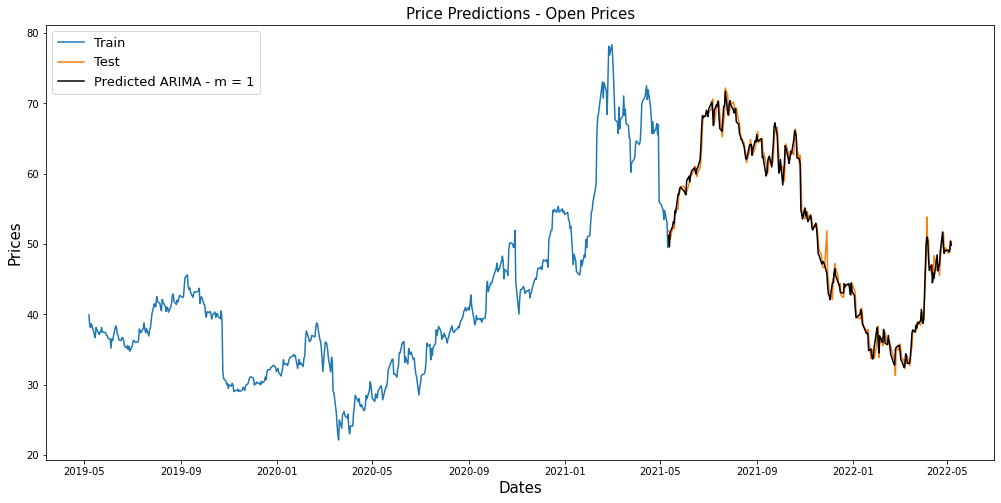

TWTR
Evaluation:

  43  from  62

----------------------------------------------------------------------------------------------------
Company:  T 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=29.624, Time=0.33 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=26.600, Time=0.19 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=28.377, Time=0.16 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=28.364, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=32.705, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=30.362, Time=0.29 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 1.214 seconds
----------------------------------------------------------------------------------------------------
Testing data
Evaluation:

RMSE : 0.2625274467115137
MAPE : 0.06931000402950618


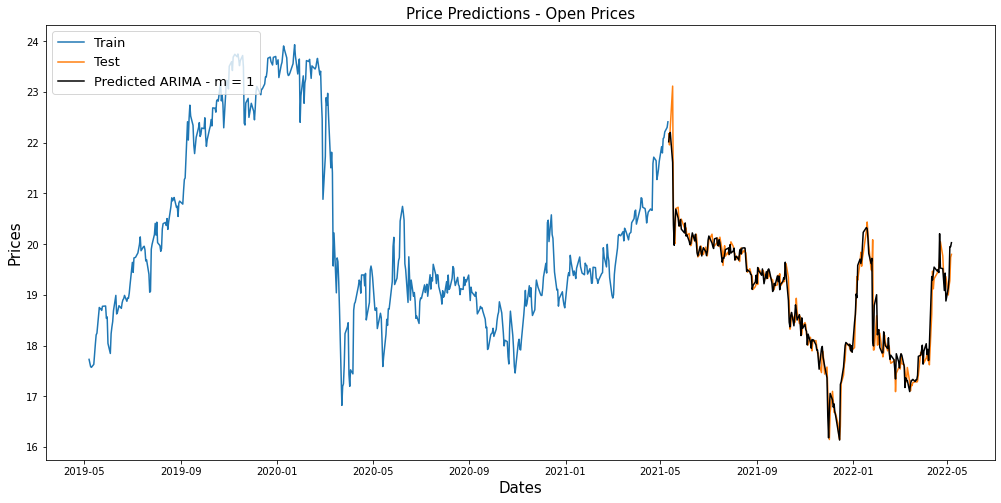

T
Evaluation:

  44  from  62

----------------------------------------------------------------------------------------------------
Company:  MRNA 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=2804.797, Time=0.44 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2829.969, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2828.458, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2826.352, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2828.708, Time=0.06 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=2808.552, Time=0.31 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=2803.481, Time=0.23 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2824.663, Time=0.24 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=2807.781, Time=0.12 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=2804.489, Time=0.35 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=2802.482, Time=0.25 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=2804.482, Time=0.49 sec


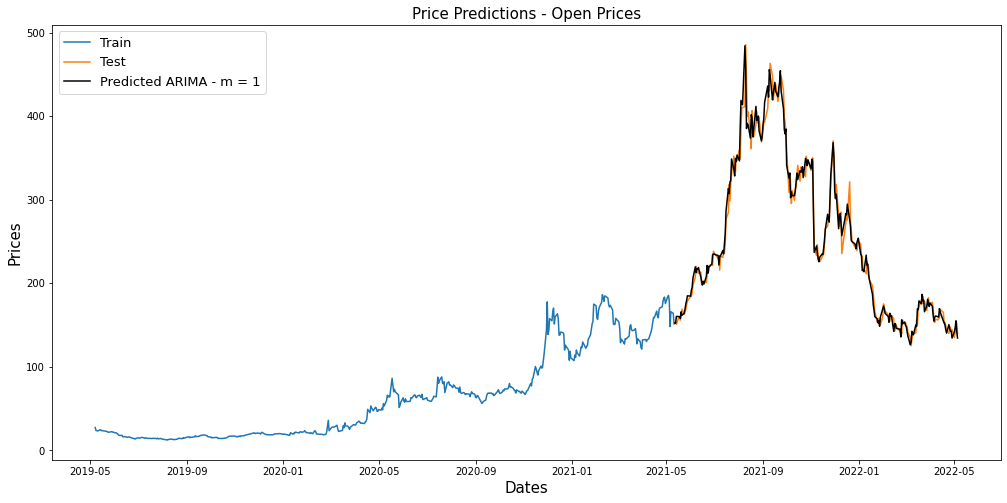

MRNA
Evaluation:

  45  from  62

----------------------------------------------------------------------------------------------------
Company:  CGC 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1393.729, Time=0.44 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1436.569, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1432.317, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1430.887, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1434.738, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1432.649, Time=0.34 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1430.360, Time=0.31 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=1394.619, Time=0.53 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=1400.565, Time=0.48 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1431.870, Time=0.23 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=1427.973, Time=0.54 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=1428.229, Time=0.43 se

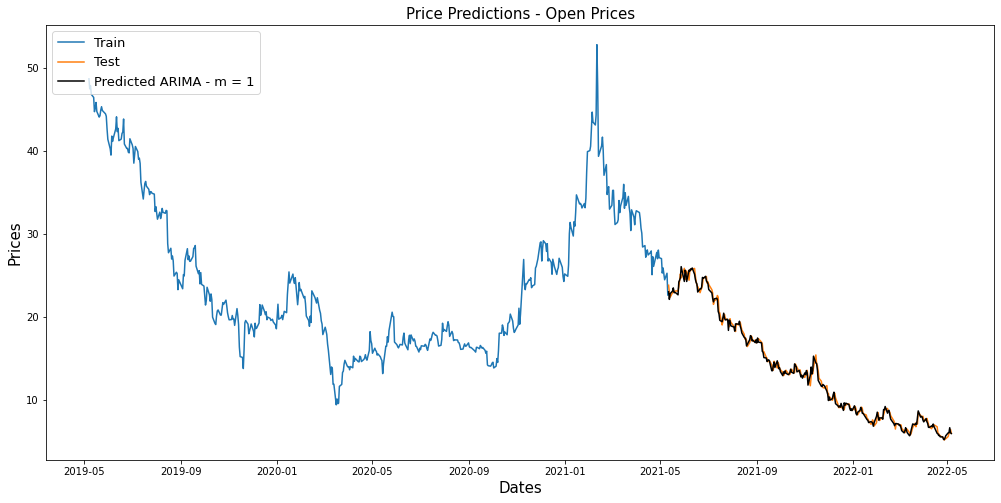

CGC
Evaluation:

  46  from  62

----------------------------------------------------------------------------------------------------
Company:  KO 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=885.227, Time=0.56 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=883.315, Time=0.16 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=882.736, Time=0.18 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=882.743, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=898.358, Time=0.09 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=884.735, Time=0.25 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=884.736, Time=0.19 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=887.184, Time=0.35 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=898.184, Time=0.06 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 2.040 seconds
----------------------------------------------------------------------------------------------------
Testing data
Evaluation:

RMS

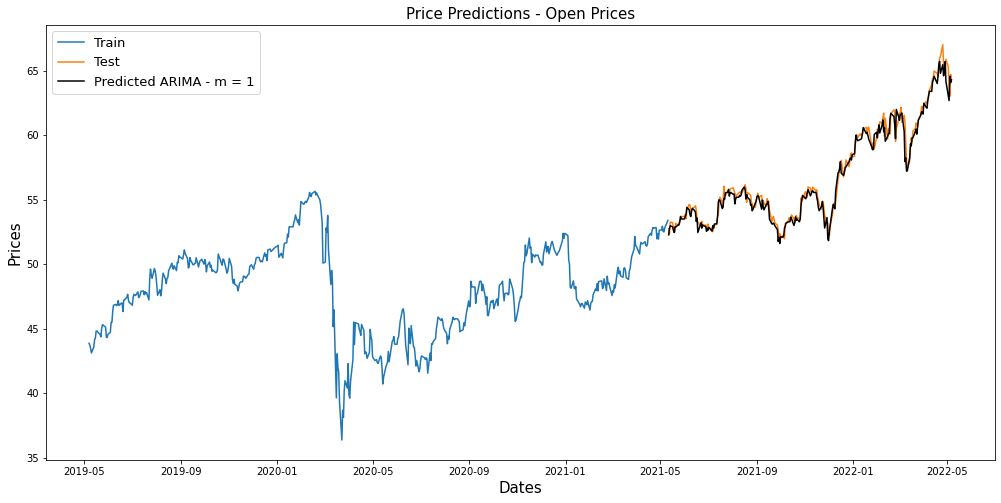

KO
Evaluation:

  47  from  62

----------------------------------------------------------------------------------------------------
Company:  SPCE 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1606.442, Time=0.42 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1660.504, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1615.900, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1612.696, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1661.092, Time=0.10 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1610.002, Time=0.33 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1612.029, Time=0.21 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=1607.683, Time=0.51 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=1609.081, Time=0.47 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1613.713, Time=0.15 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=1607.681, Time=0.40 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=1609.107, Time=0.25 sec

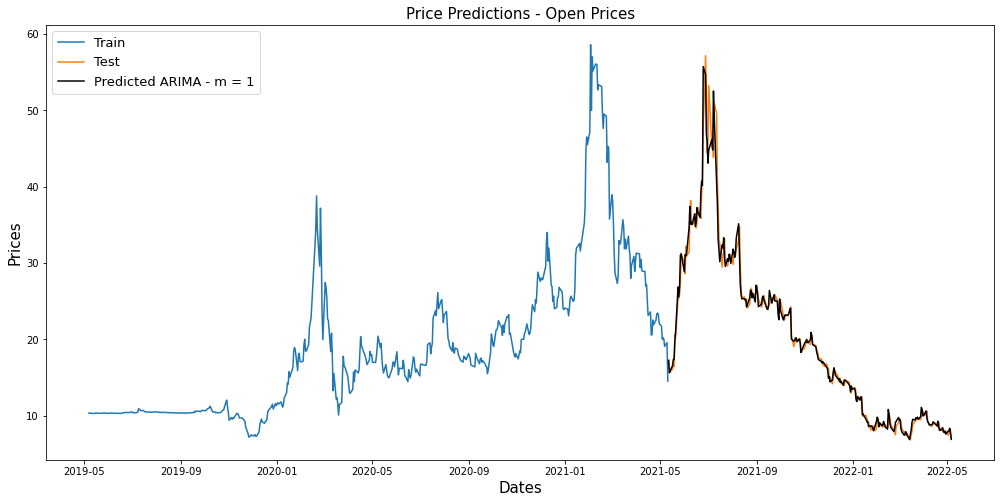

SPCE
Evaluation:

  48  from  62

----------------------------------------------------------------------------------------------------
Company:  FCEL 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=745.708, Time=0.49 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=786.226, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=783.764, Time=0.17 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=783.894, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=784.266, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=783.719, Time=0.34 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=786.574, Time=0.23 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=746.496, Time=0.47 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=746.478, Time=0.39 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=785.762, Time=0.17 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=766.932, Time=0.18 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=776.940, Time=0.29 sec
 ARIMA(3,

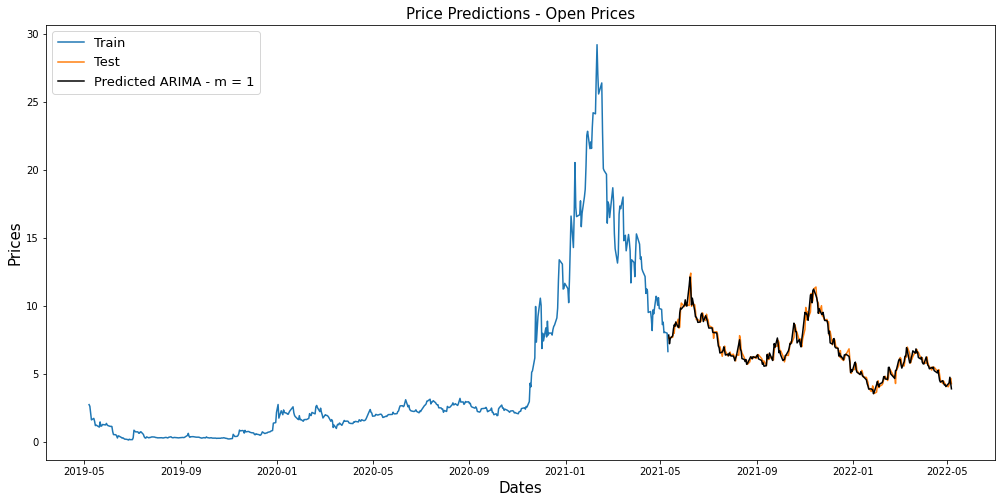

FCEL
Evaluation:

  49  from  62

----------------------------------------------------------------------------------------------------
Company:  GOOGL 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=4501.542, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=4514.735, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=4501.557, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=4499.483, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4512.793, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=4498.979, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=4503.151, Time=0.16 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=4502.598, Time=0.12 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=4499.939, Time=0.12 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=4501.832, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=4497.083, Time=0.15 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=4497.507, Time=0.06 

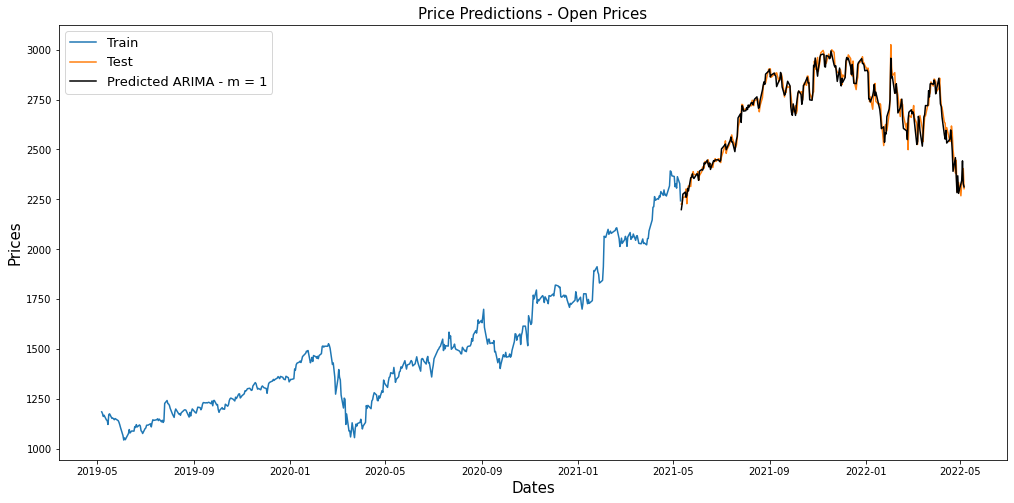

GOOGL
Evaluation:

  50  from  62

----------------------------------------------------------------------------------------------------
Company:  UBER 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1525.977, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1521.540, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1521.374, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1521.588, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1519.542, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1522.353, Time=0.11 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.683 seconds
----------------------------------------------------------------------------------------------------
Testing data
Evaluation:

RMSE : 1.1144239284934834
MAPE : 0.18058511505721464


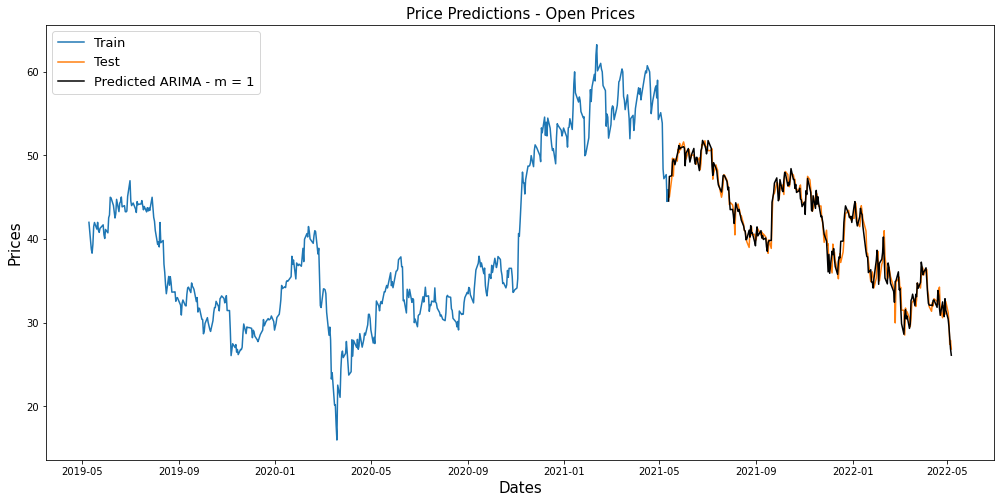

UBER
Evaluation:

  51  from  62

----------------------------------------------------------------------------------------------------
Company:  ZNGA 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-371.237, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-378.946, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-377.070, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-377.067, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-380.937, Time=0.14 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-375.069, Time=0.13 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.699 seconds
----------------------------------------------------------------------------------------------------
Testing data
Evaluation:

RMSE : 0.1437446906782361
MAPE : 0.18782931900641017


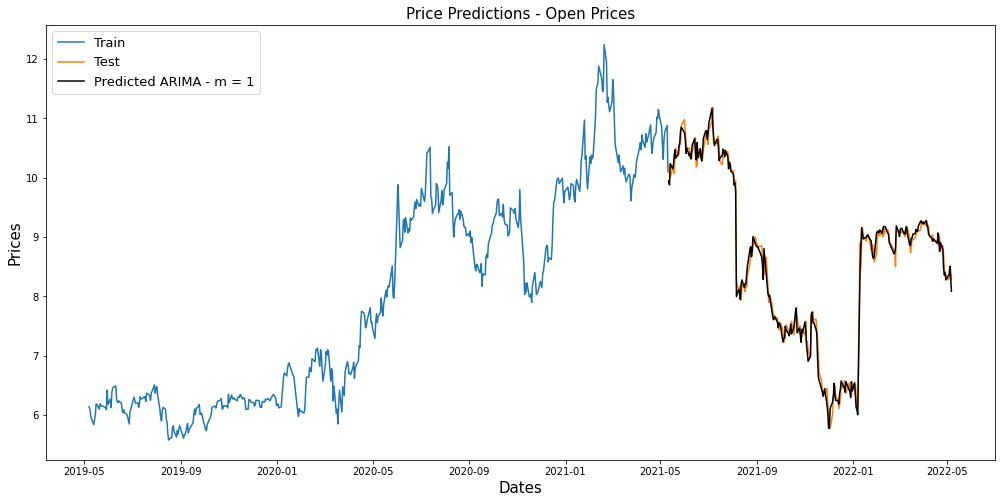

ZNGA
Evaluation:

  52  from  62

----------------------------------------------------------------------------------------------------
Company:  GM 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1095.970, Time=0.41 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1108.964, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1096.021, Time=0.16 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1093.392, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1110.694, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1094.454, Time=0.21 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=1094.038, Time=0.27 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1094.983, Time=0.46 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1095.840, Time=0.12 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 1.918 seconds
----------------------------------------------------------------------------------------------------
Testing data
Evalua

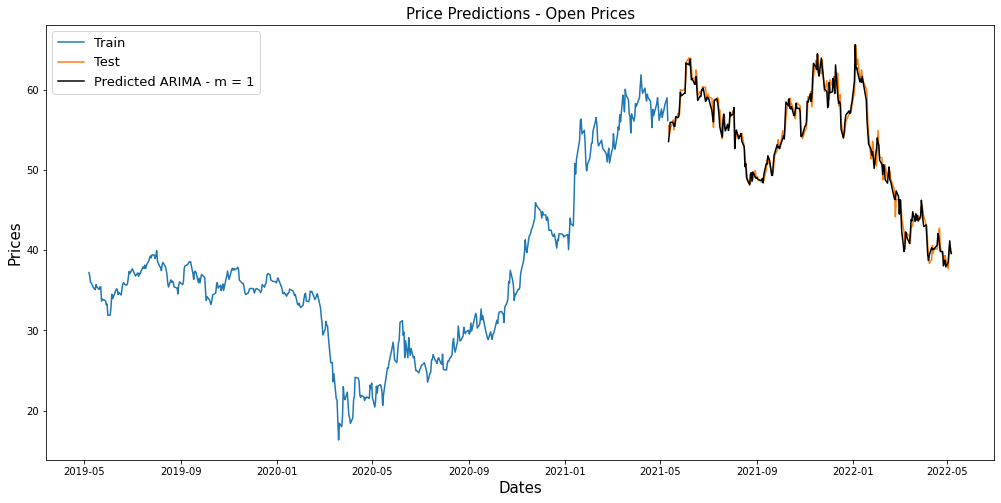

GM
Evaluation:

  53  from  62

----------------------------------------------------------------------------------------------------
Company:  GE 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=2001.854, Time=0.41 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1994.331, Time=0.13 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1995.985, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1995.996, Time=0.30 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1996.666, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1997.632, Time=0.28 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 1.302 seconds
----------------------------------------------------------------------------------------------------
Testing data
Evaluation:

RMSE : 1.6591799557937965
MAPE : 0.08028692758315148


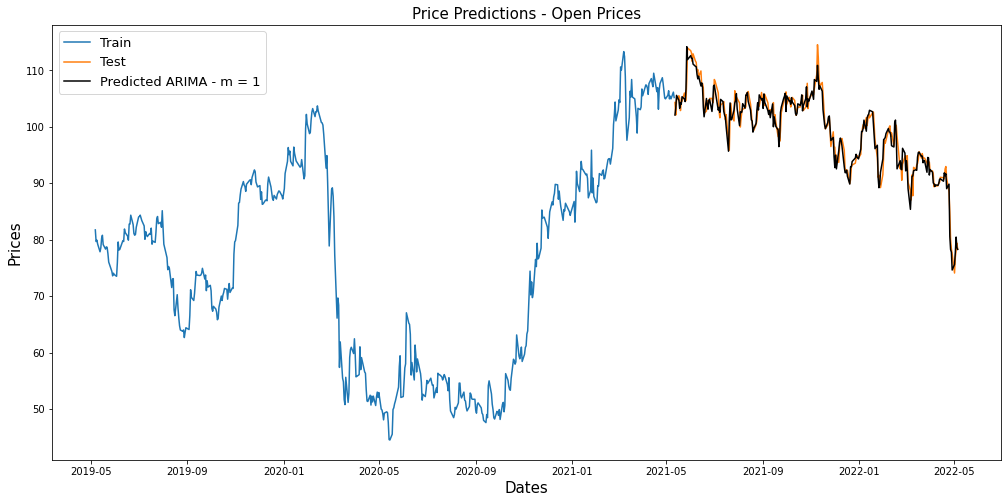

GE
Evaluation:

  54  from  62

----------------------------------------------------------------------------------------------------
Company:  PYPL 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=2688.253, Time=0.39 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2685.123, Time=0.14 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2685.501, Time=0.18 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2685.551, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2683.522, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2687.516, Time=0.29 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 1.324 seconds
----------------------------------------------------------------------------------------------------
Testing data
Evaluation:

RMSE : 4.134209829324938
MAPE : 0.48768025432727613


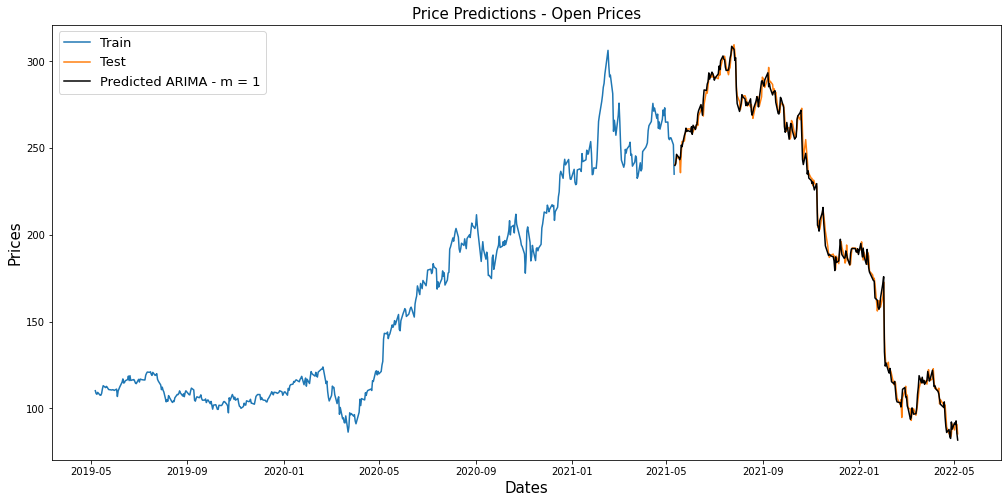

PYPL
Evaluation:

  55  from  62

----------------------------------------------------------------------------------------------------
Company:  ABNB 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1494.737, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1491.450, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1493.032, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1488.832, Time=0.07 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1488.504, Time=0.10 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1487.106, Time=0.13 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=1482.172, Time=0.16 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=1480.517, Time=0.10 sec
 ARIMA(4,1,0)(0,0

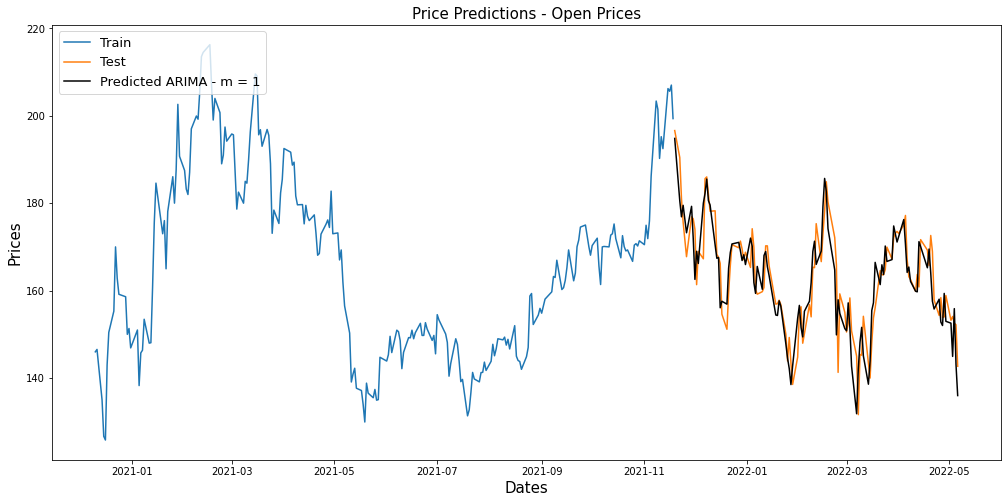

ABNB
Evaluation:

  56  from  62

----------------------------------------------------------------------------------------------------
Company:  UAL 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1814.298, Time=0.44 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2086.647, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1993.748, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1826.939, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2084.880, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1812.341, Time=0.44 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1813.432, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1816.426, Time=0.16 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1813.388, Time=0.49 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1812.110, Time=0.24 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=1814.035, Time=0.29 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=1814.014, Time=0.59 se

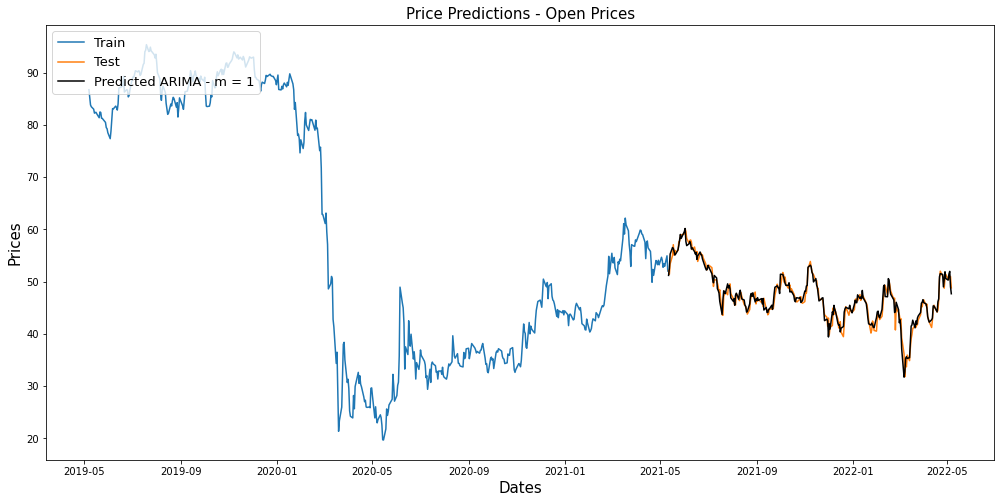

UAL
Evaluation:

  57  from  62

----------------------------------------------------------------------------------------------------
Company:  DKNG 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1756.869, Time=0.41 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1755.343, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1757.134, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1757.125, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1753.397, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1757.251, Time=0.23 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.958 seconds
----------------------------------------------------------------------------------------------------
Testing data
Evaluation:

RMSE : 1.2413491209073533
MAPE : 0.5939186960306048


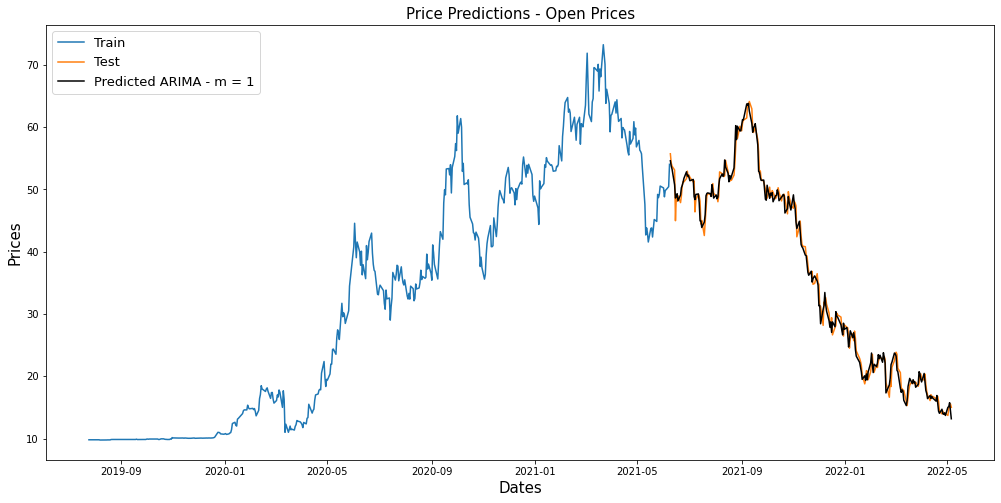

DKNG
Evaluation:

  58  from  62

----------------------------------------------------------------------------------------------------
Company:  JNJ 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1911.790, Time=0.39 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1913.501, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1912.614, Time=0.20 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1913.107, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1917.540, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1907.054, Time=0.36 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=1906.788, Time=0.29 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=1903.740, Time=0.45 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=1904.044, Time=0.42 sec
 ARIMA(0,0,4)(0,0,0)[0] intercept   : AIC=1908.874, Time=0.23 sec
 ARIMA(1,0,4)(0,0,0)[0] intercept   : AIC=1904.302, Time=0.66 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=1907.765, Time=0.13 se

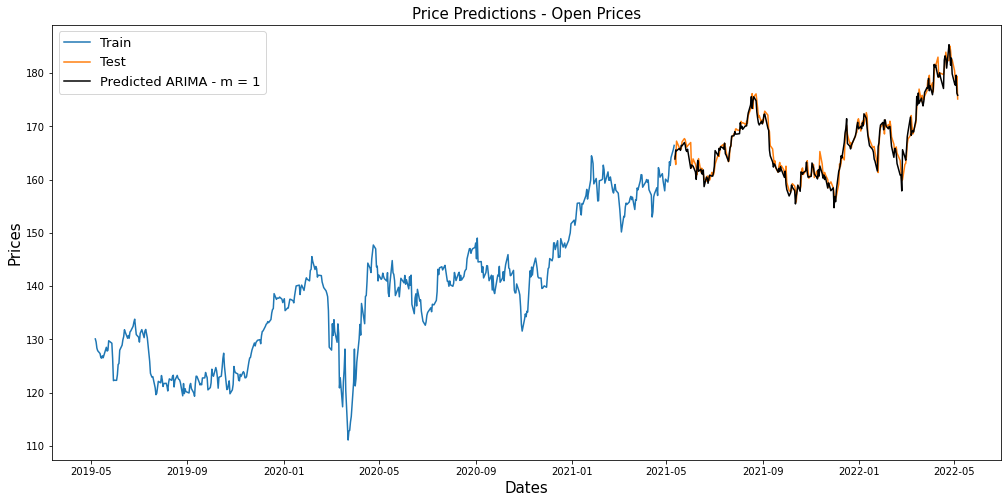

JNJ
Evaluation:

  59  from  62

----------------------------------------------------------------------------------------------------
Company:  LUV 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1387.973, Time=0.45 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1384.907, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1384.044, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1383.695, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1390.067, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1383.974, Time=0.26 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=1384.068, Time=0.31 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1385.555, Time=0.32 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1389.318, Time=0.10 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 1.915 seconds
----------------------------------------------------------------------------------------------------
Testing data
Evalua

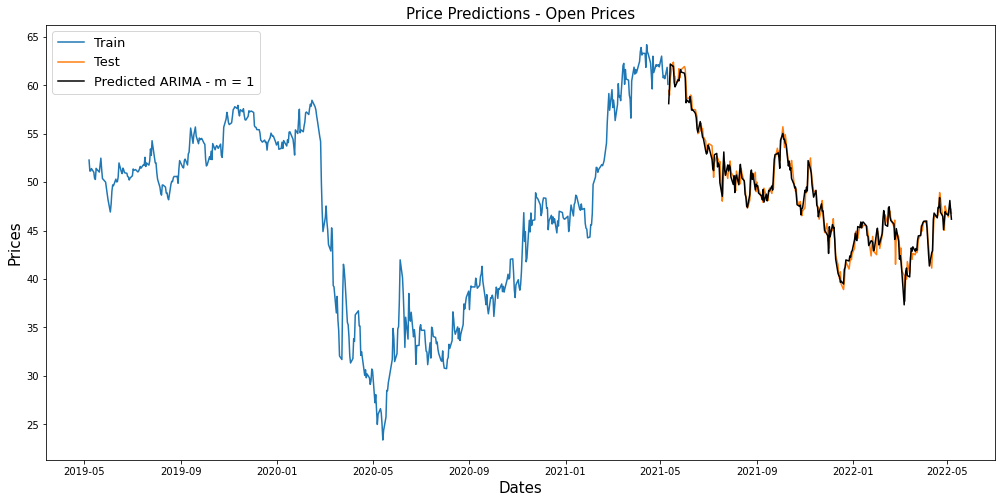

LUV
Evaluation:

  60  from  62

----------------------------------------------------------------------------------------------------
Company:  NKE 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1841.633, Time=0.48 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1844.615, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1845.754, Time=0.26 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1845.501, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1843.501, Time=0.07 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1841.485, Time=0.41 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=1841.132, Time=0.10 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=1841.403, Time=0.40 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1840.933, Time=0.37 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1842.912, Time=0.39 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1841.118, Time=0.28 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1841.810, Time=0.16 sec

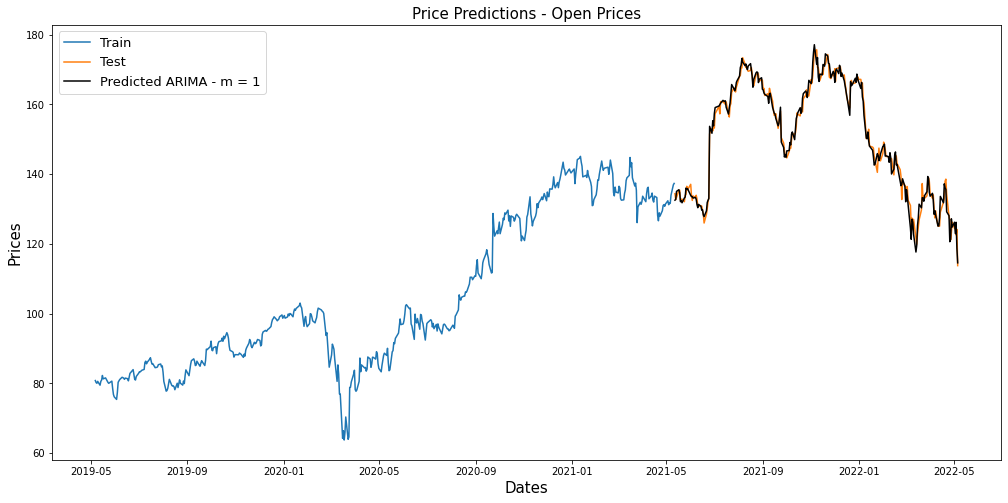

NKE
Evaluation:

  61  from  62

----------------------------------------------------------------------------------------------------
Company:  XOM 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.70 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1470.890, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1345.133, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1468.900, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1319.666, Time=0.08 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1299.572, Time=0.11 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1275.228, Time=0.12 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=1266.832, Time=0.17 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.56 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.52 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=1264.839, Time=0.14 sec
 ARIMA(4,1,0)(0,0,0

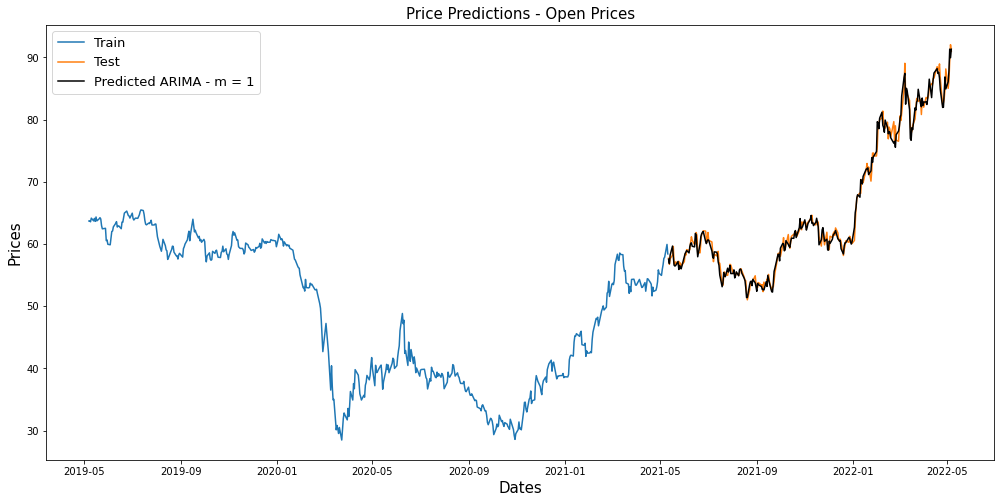

XOM
Evaluation:

  62  from  62

----------------------------------------------------------------------------------------------------
Company:  SONY 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1142.702, Time=0.49 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1135.146, Time=0.14 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1136.832, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1136.822, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1133.180, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1138.681, Time=0.09 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.969 seconds
----------------------------------------------------------------------------------------------------
Testing data
Evaluation:

RMSE : 1.2814031708592029
MAPE : 0.11590437318121398


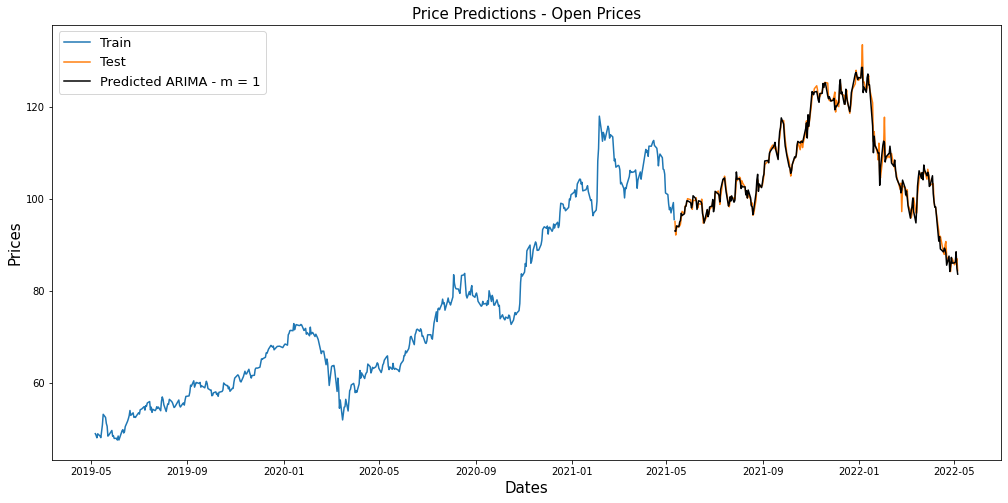

SONY
Evaluation:



In [20]:
#testing data
eval_rmse, eval_mape = eval_multiple_comp()

In [21]:
rmse = find_average(eval_rmse)
print("Average rmse ", rmse)
mape = find_average(eval_mape)
print("Average mape ", mape)

Average rmse  3.668425098697492
Average mape  0.24285333834781767


### Training data to investigate overfitting

In [131]:
def train_predict_arima_trian_data(df, prd):
    
    #prd determine variable of percent used for test train. 0.33 one third of data is trest.
    

    #split data using variable defined 
    train_data, test_data = df[0:prd],df[prd:]
    
    #external variable for ARIMAX
    exoX   =  df[['Close']]
    exotrain, exotest = exoX[0:prd], exoX[prd:]
    
    #ARIMA VARIABLE FOR SEASONALITY
    m=1
    
    ######################## model training ###########################################
    print(f'  SARIMAX m = {str(m)}') 
    model = auto_arima(train_data['Open'], exogenous = exotrain , seasonal=True, m = m,
                       d=None,D=None, trace=True, stepwise=True)

    print("-"*100)
    
    #forcast 
    forecast = model.predict(n_periods=len(train_data),exogenous =exotrain, return_conf_int=False)
    
    #################### evalutate model ##############
    evaluation_func(train_data['Open'], forecast)
    
    return model, forecast

In [132]:
#training data
df = comp_def(list_of_tickers[1])
model, forecast = train_predict_arima_trian_data(df, prd = -int(len(df)*0.33))


----------------------------------------------------------------------------------------------------
Company:  MSFT 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=2405.805, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2425.318, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2402.945, Time=0.23 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2400.589, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2424.807, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2400.934, Time=0.24 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=2402.021, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=2404.117, Time=0.14 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2398.767, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2400.303, Time=0.23 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=2400.241, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2402.246, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[0]       

In [133]:
#training data
def eval_multiple_comp_training():

    eval_rmse = []
    eval_mape = []
    
    for c in list_of_tickers:
        
        print( " ", list_of_tickers.index(c) +1," from ", len(list_of_tickers))

        df = comp_def(c)
        prd  = - int(len(df)*0.66)
        
        if df.empty:
            print(f" No data for company: {str(c)}" )
        else:
            model, forecast = train_predict_arima_trian_data(df, prd)

            print(f"{str(c)}" )
            print('Evaluation:\n')

            eval_rmse.append(np.sqrt(metrics.mean_squared_error(df[:prd]['Open'] , forecast)))
            print()
            eval_mape.append(mean_absolute_percentage_error(df[:prd]['Open'], forecast))
        
    return eval_rmse,eval_mape

In [134]:
#training data
eval_rmse, eval_mape = eval_multiple_comp_training()

rmse = find_average(eval_rmse)
print("Average rmse ", rmse)
mape = find_average(eval_mape)
print("Average mape ", mape)

  1  from  60

----------------------------------------------------------------------------------------------------
Company:  SNDL 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=232.838, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=258.269, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=257.087, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=256.023, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=256.456, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=244.822, Time=0.27 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=240.135, Time=0.30 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=240.449, Time=0.29 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=242.463, Time=0.20 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AI

 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-430.123, Time=0.21 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-428.961, Time=0.21 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-425.464, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-431.838, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-423.919, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-424.904, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-430.666, Time=0.16 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-430.860, Time=0.18 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-424.743, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-427.133, Time=0.06 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-428.002, Time=0.25 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 2.257 seconds
----------------------------------------------------------------------------------------------------
Evaluation:

RMSE : 0.10616404542223491
MAPE : 0.010029532668322563
RYCEY
Evaluation:


  8  fro

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1068.533, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1076.948, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1065.604, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1063.491, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1076.403, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1064.837, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=1064.726, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1062.308, Time=0.08 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=1068.721, Time=0.15 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=1066.061, Time=0.23 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1067.034, Time=0.06 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=1069.688, Time=0.28 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1058.684, Time=0.17 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1062.882, Time=0.11 sec
 ARIMA(1,0,1)(0,0

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=836.109, Time=0.30 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=865.283, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=841.124, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=839.541, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=868.705, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=843.449, Time=0.25 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=843.848, Time=0.16 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=842.158, Time=0.25 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=850.477, Time=0.27 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=836.013, Time=0.17 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=841.304, Time=0.22 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=842.824, Time=0.15 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=846.934, Time=0.04 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0] intercept
Total fit time: 2.108 seconds
-------------------

 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-1195.462, Time=0.26 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-1196.681, Time=0.26 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-1189.735, Time=0.07 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-1190.064, Time=0.21 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-1192.800, Time=0.19 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=-1195.135, Time=0.35 sec

Best model:  ARIMA(2,0,2)(0,0,0)[0]          
Total fit time: 4.119 seconds
----------------------------------------------------------------------------------------------------
Evaluation:

RMSE : 0.023806288597689337
MAPE : 0.05809338904520238
ZOM
Evaluation:


  28  from  60

----------------------------------------------------------------------------------------------------
Company:  VOO 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1220.263, Time=0.28 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1223.324, Time=0.10 sec
 ARIMA(1,0

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-71.335, Time=0.30 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-74.624, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-74.024, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-73.892, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-75.883, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-72.269, Time=0.15 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.638 seconds
----------------------------------------------------------------------------------------------------
Evaluation:

RMSE : 0.2072661939355072
MAPE : 0.032081418561576265
GME
Evaluation:


  35  from  60

----------------------------------------------------------------------------------------------------
Company:  SBUX 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=814.833, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[0] interc

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=554.114, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=551.952, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=548.881, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=548.667, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=552.598, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=550.656, Time=0.17 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=550.655, Time=0.12 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=552.667, Time=0.26 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=548.919, Time=0.04 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 1.145 seconds
----------------------------------------------------------------------------------------------------
Evaluation:

RMSE : 0.6977897072423261
MAPE : 0.015081812326355816
TWTR
Evaluation:


  41  from  60

----------------------------------------------------------------------------

 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-332.551, Time=0.37 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=-333.047, Time=0.38 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-322.658, Time=0.49 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=-315.035, Time=0.48 sec
 ARIMA(4,1,4)(0,0,0)[0] intercept   : AIC=-335.252, Time=0.46 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(5,1,4)(0,0,0)[0] intercept   : AIC=-332.182, Time=0.45 sec
 ARIMA(4,1,5)(0,0,0)[0] intercept   : AIC=inf, Time=0.52 sec
 ARIMA(3,1,5)(0,0,0)[0] intercept   : AIC=-334.221, Time=0.48 sec
 ARIMA(5,1,5)(0,0,0)[0] intercept   : AIC=-331.472, Time=0.53 sec
 ARIMA(4,1,4)(0,0,0)[0]             : AIC=-335.499, Time=0.36 sec
 ARIMA(3,1,4)(0,0,0)[0]             : AIC=-331.470, Time=0.34 sec
 ARIMA(4,1,3)(0,0,0)[0]             : AIC=-334.936, Time=0.34 sec
 ARIMA(5,1,4)(0,0,0)[0]             : AIC=-335.833, Time=0.42 sec
 ARIMA(5,1,3)(0,0,0)[0]             : AIC=-333.452, Time=0.38 sec
 ARIMA(5,1,5)(0,0,0)

 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1078.497, Time=0.22 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1070.108, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1088.335, Time=0.04 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1066.979, Time=0.18 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=1066.980, Time=0.20 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=1050.256, Time=0.29 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=1069.288, Time=0.18 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=1050.437, Time=0.35 sec
 ARIMA(2,1,4)(0,0,0)[0]             : AIC=1050.322, Time=0.33 sec
 ARIMA(1,1,4)(0,0,0)[0]             : AIC=1069.749, Time=0.21 sec
 ARIMA(3,1,4)(0,0,0)[0]             : AIC=1051.675, Time=0.35 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.30 sec

Best model:  ARIMA(2,1,3)(0,0,0)[0]          
Total fit time: 4.806 seconds
----------------------------------------------------------------------------------------------------
Evaluation:

RMSE : 2.0437912981693

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=842.450, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=849.683, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=851.490, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=851.429, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=847.697, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=852.277, Time=0.22 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=852.788, Time=0.24 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=853.636, Time=0.29 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=850.528, Time=0.29 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=851.855, Time=0.21 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=853.528, Time=0.35 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=855.258, Time=0.10 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=859.333, Time=0.14 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=842.626, Time=0.27 sec

Best model:  ARIMA(2,0,2)(0,0,

In [141]:
# print(eval_rmse)

## Evaluation of ARIMA (vanilla) for comparison

In [148]:
def train_predict_arima_(df, prd):
    
    #prd determine variable of percent used for test train. 0.33 one third of data is trest.
    

    #split data using variable defined 
    train_data, test_data = df[0:prd],df[prd:]
    
    #external variable for ARIMAX
    exoX   =  df[['Close']]
    exotrain, exotest = exoX[0:prd], exoX[prd:]
    
    #ARIMA VARIABLE FOR SEASONALITY
    m=1
    
    ######################## model training ###########################################
    print(f'  SARIMAX m = {str(m)}') 

    model = auto_arima(train_data['Open'],start_p=1, d=None, trace=True,error_action='ignore',
                            seasonal=False, stepwise=True)

    print("-"*100)
    #output summary of model
    #model.summary()

    #forcast 
    forecast = model.predict(n_periods=-prd,return_conf_int=False)
    

    #adjust index of predictions  
    #index shift due to predictions start from 2/3 of data subtract the -1/3 (to add) 
    dif = len(train_data)-prd        #-1 due to train_data starting at 0
    
    forecast  =   pd.DataFrame(forecast, columns=['open_pred'])
    forecast["new_index"] = range(len(train_data), dif)
    forecast  =   forecast.set_index("new_index")
    
    #################### evalutate model ##############
    print("Testing data")
    evaluation_func(test_data['Open'], forecast)
    
    plt.figure( figsize = (17,8) )
    plt.xlabel('Dates'  , fontsize = 15 )
    plt.ylabel('Prices' , fontsize = 15 )
    plt.title('Price Predictions - Open Prices',fontsize = 15 )

    plt.plot(train_data['Date'] , train_data['Open'],   label = 'Train')
    plt.plot(test_data['Date']  , test_data['Open'],    label = 'Test')
    plt.plot(test_data['Date']  , forecast,label = f'Predicted ARIMA - m = {str(m)}', color ='k')


    plt.legend(loc ='upper left',prop={'size': 13})
    plt.show()
    #######################
    
    return model, forecast

def eval_multiple_comp_arima():

    eval_rmse = []
    eval_mape = []
    
    for c in list_of_tickers:
        
        print( " ", list_of_tickers.index(c) +1 ," from ", len(list_of_tickers))


        df = comp_def(c) 
        prd  = - int(len(df)*0.33)
        model, forecast = train_predict_arima_(df, prd)
        
        print(f"{str(c)}" )
        print('Evaluation:\n')
        
        eval_rmse.append(np.sqrt(metrics.mean_squared_error(df[prd:]['Open'] , forecast)))
        eval_mape.append(mean_absolute_percentage_error(df[prd:]['Open'], forecast))
        
    return eval_rmse,eval_mape


  1  from  60

----------------------------------------------------------------------------------------------------
Company:  SNDL 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=330.730, Time=0.34 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=602.714, Time=0.05 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=507.446, Time=0.07 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=600.924, Time=0.01 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.53 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=317.306, Time=0.64 sec
 ARIMA(0,2,4)(0,0,0)[0] intercept   : AIC=307.017, Time=0.48 sec
 ARIMA(1,2,4)(0,0,0)[0] intercept   : AIC=325.746, Time=0.58 sec
 ARIMA(0,2,5)(0,0,0)[0] intercept   : AIC=313.63

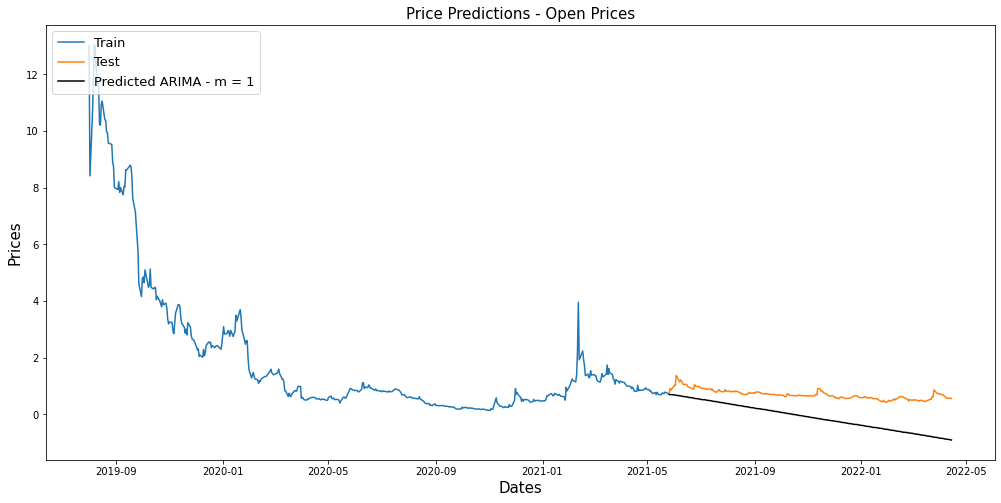

SNDL
Evaluation:

  2  from  60

----------------------------------------------------------------------------------------------------
Company:  MSFT 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2662.666, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2664.878, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2665.927, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2665.617, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2666.265, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2660.666, Time=0.05 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=2662.666, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2664.334, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2664.599, Time=0.17 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=2663.462, Time=0.02 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 0.563 seconds
-----------------------------------------------------

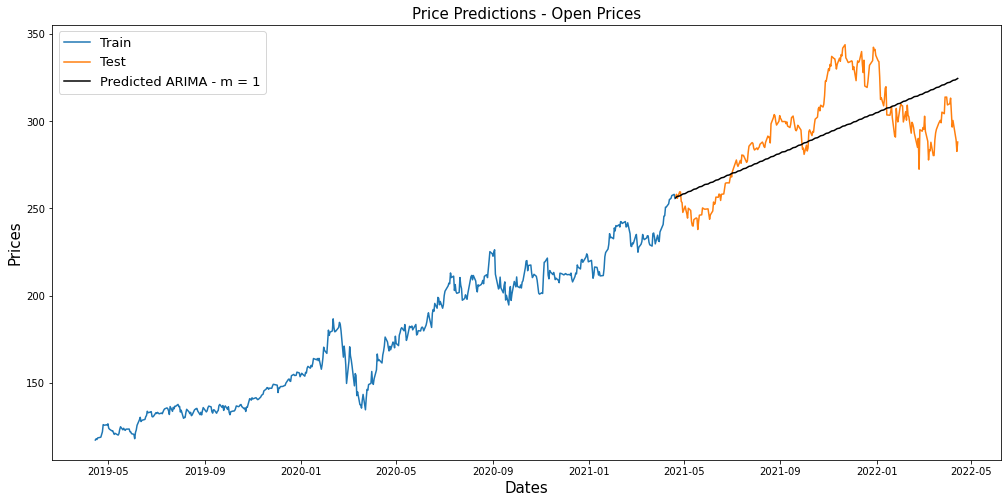

MSFT
Evaluation:

  3  from  60

----------------------------------------------------------------------------------------------------
Company:  SNAP 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1699.102, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1702.080, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1701.054, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1700.694, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1702.775, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1701.897, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1705.702, Time=0.19 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1692.038, Time=0.27 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1694.835, Time=0.11 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1674.421, Time=0.23 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1679.609, Time=0.11 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=1676.395, Time=0.53 se

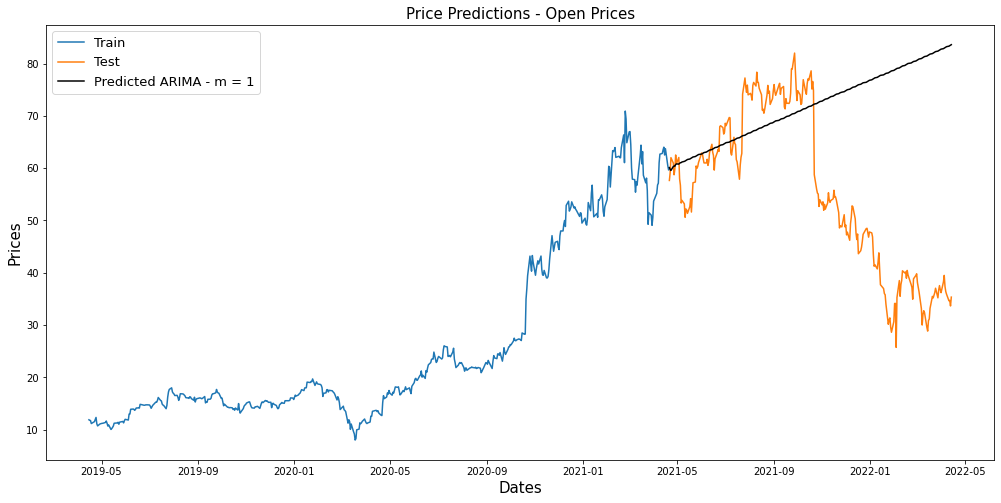

SNAP
Evaluation:

  4  from  60

----------------------------------------------------------------------------------------------------
Company:  BB 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=763.881, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=767.177, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=769.144, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=769.150, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=765.180, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=763.286, Time=0.05 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=763.133, Time=0.07 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=764.967, Time=0.33 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=765.094, Time=0.10 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=760.591, Time=0.47 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=763.238, Time=0.60 sec
 ARIMA(1,1,5)(0,0,0)[0] intercept   : AIC=761.913, Time=0.48 sec
 ARIMA(0,1,5

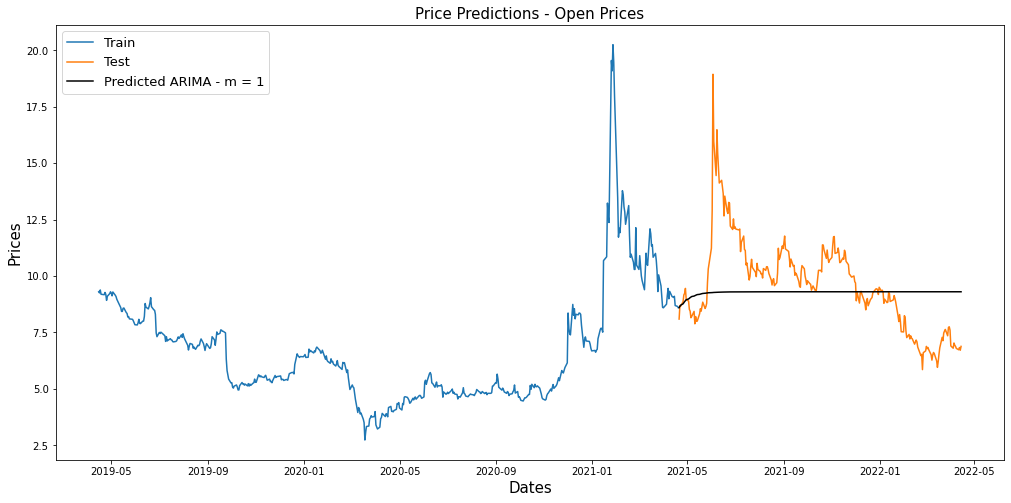

BB
Evaluation:

  5  from  60

----------------------------------------------------------------------------------------------------
Company:  WMT 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2084.114, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2087.753, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2086.609, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2085.989, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2086.682, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2084.526, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2082.474, Time=0.19 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2084.165, Time=0.21 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2084.897, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2082.880, Time=0.05 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.299 sec

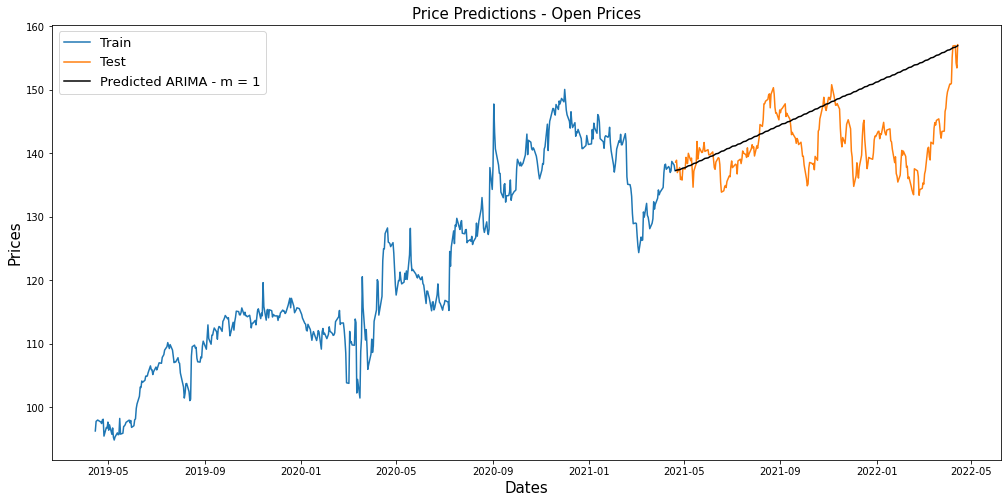

WMT
Evaluation:

  6  from  60

----------------------------------------------------------------------------------------------------
Company:  PTON 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2401.960, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2399.606, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2399.642, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2399.366, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2398.714, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2400.513, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.290 seconds
----------------------------------------------------------------------------------------------------
Testing data
Evaluation:

RMSE : 58.09819195809784
MAPE : 1.3910753442180948


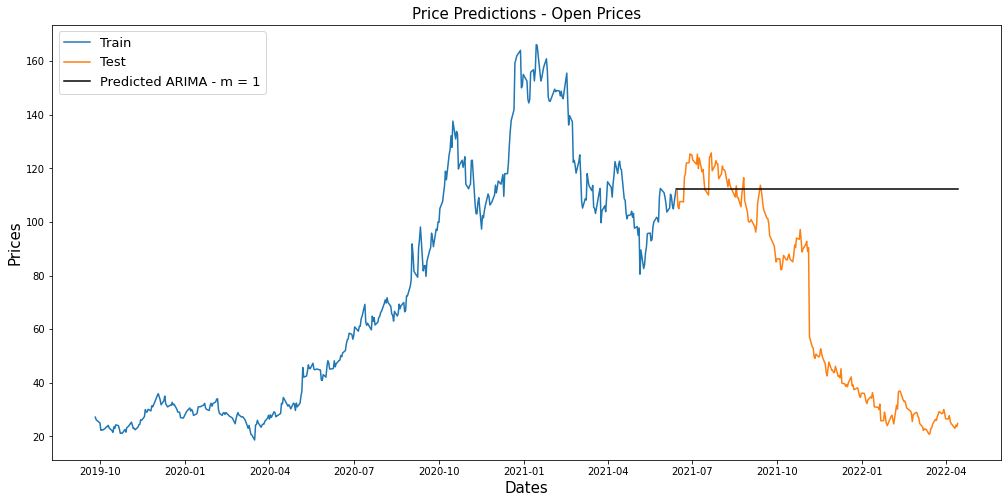

PTON
Evaluation:

  7  from  60

----------------------------------------------------------------------------------------------------
Company:  RYCEY 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-100.431, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-104.689, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-103.350, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-103.305, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-102.754, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-101.653, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.457 seconds
----------------------------------------------------------------------------------------------------
Testing data
Evaluation:

RMSE : 2.8681674649215947
MAPE : 1.6280021517502519


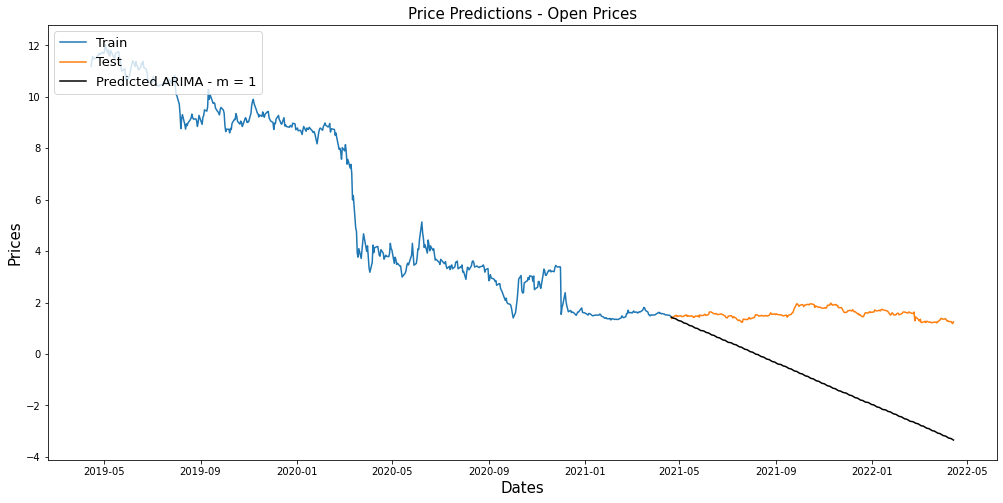

RYCEY
Evaluation:

  8  from  60

----------------------------------------------------------------------------------------------------
Company:  CPRX 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-159.847, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-160.569, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-160.460, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-160.218, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-162.514, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-159.327, Time=0.12 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.397 seconds
----------------------------------------------------------------------------------------------------
Testing data
Evaluation:

RMSE : 2.183005417237707
MAPE : 0.29217106994596664


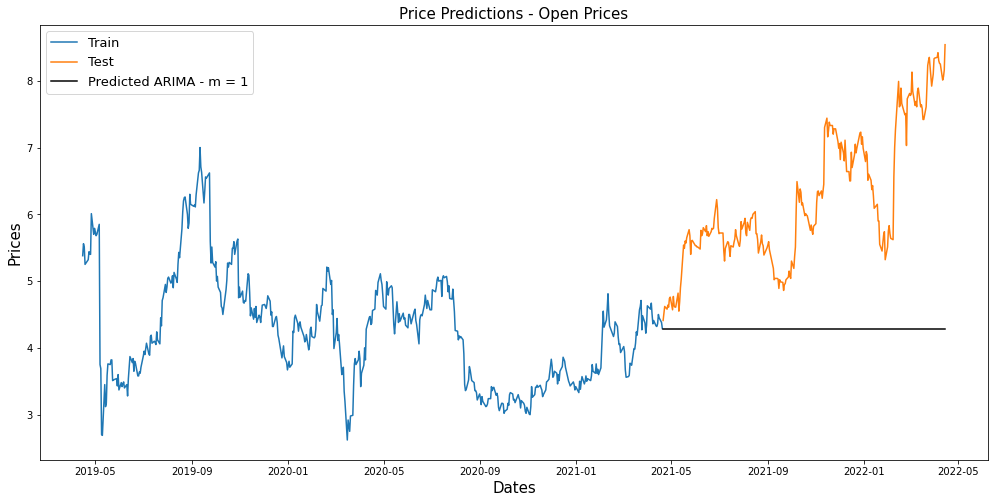

CPRX
Evaluation:

  9  from  60

----------------------------------------------------------------------------------------------------
Company:  AAPL 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2217.415, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2219.043, Time=0.38 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2220.431, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2220.238, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2220.180, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2215.449, Time=0.05 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=2217.392, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2219.175, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2218.588, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=2217.783, Time=0.03 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 0.914 seconds
-----------------------------------------------------

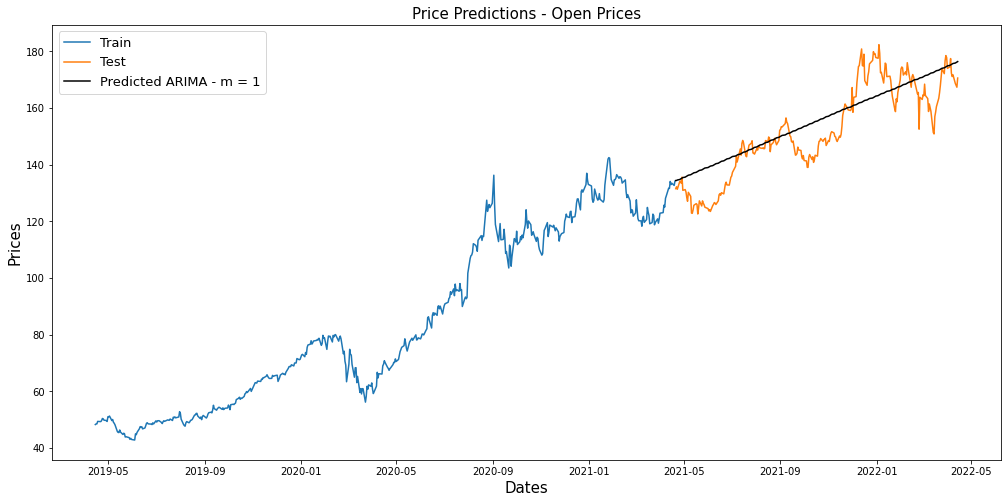

AAPL
Evaluation:

  10  from  60

----------------------------------------------------------------------------------------------------
Company:  TSLA 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4322.817, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4326.151, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4325.787, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4325.069, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4327.087, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4321.215, Time=0.10 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4322.322, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4324.846, Time=0.09 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4317.605, Time=0.30 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=4311.337, Time=0.59 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4312.541, Time=0.35 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=4307.946, Time=0.60 s

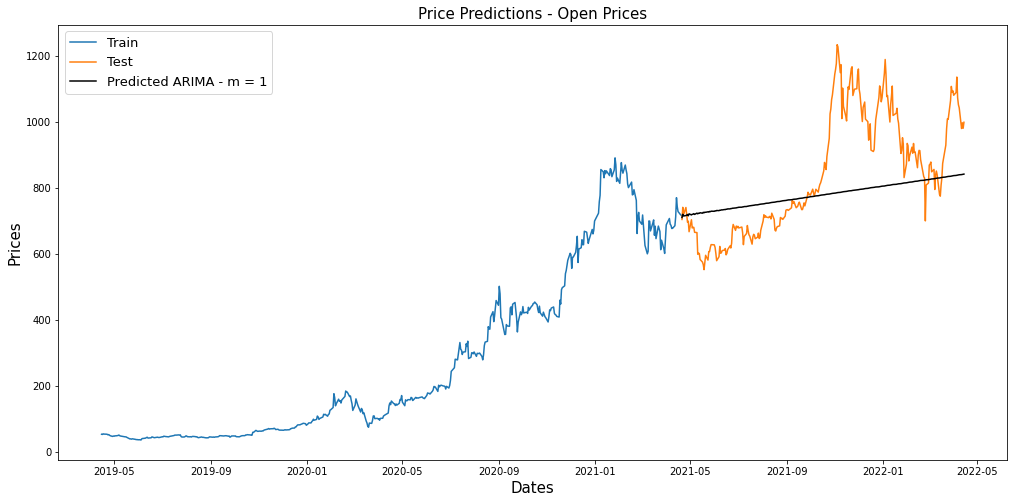

TSLA
Evaluation:

  11  from  60

----------------------------------------------------------------------------------------------------
Company:  AMC 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1362.684, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1427.153, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1370.108, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1374.460, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1425.219, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1361.172, Time=0.06 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1361.142, Time=0.11 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1350.005, Time=0.14 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1342.256, Time=0.19 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1344.264, Time=0.14 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1341.398, Time=0.47 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1344.026, Time=0.17 se

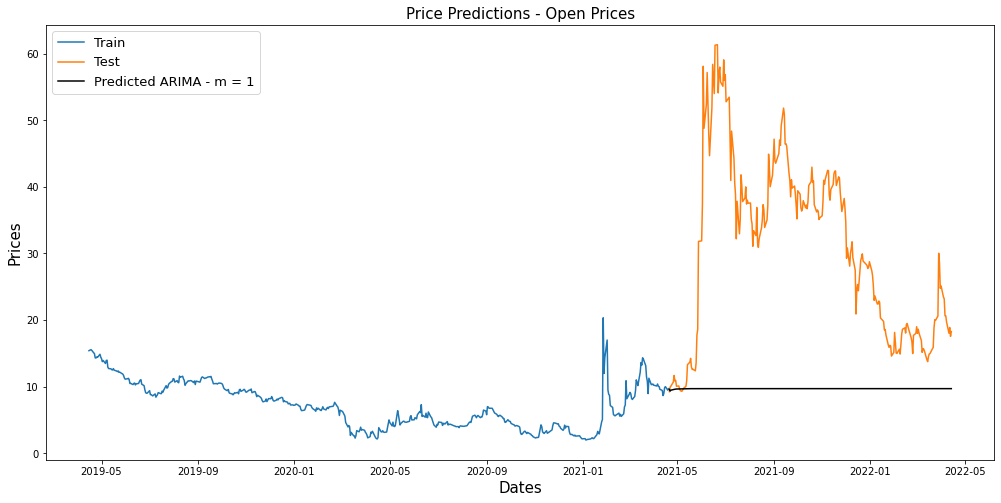

AMC
Evaluation:

  12  from  60

----------------------------------------------------------------------------------------------------
Company:  F 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-74.271, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-73.441, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-77.739, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-77.768, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-75.055, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-75.786, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-75.798, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-79.263, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-77.287, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-77.303, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-79.248, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-75.756, Time=0.08 sec

Best model: 

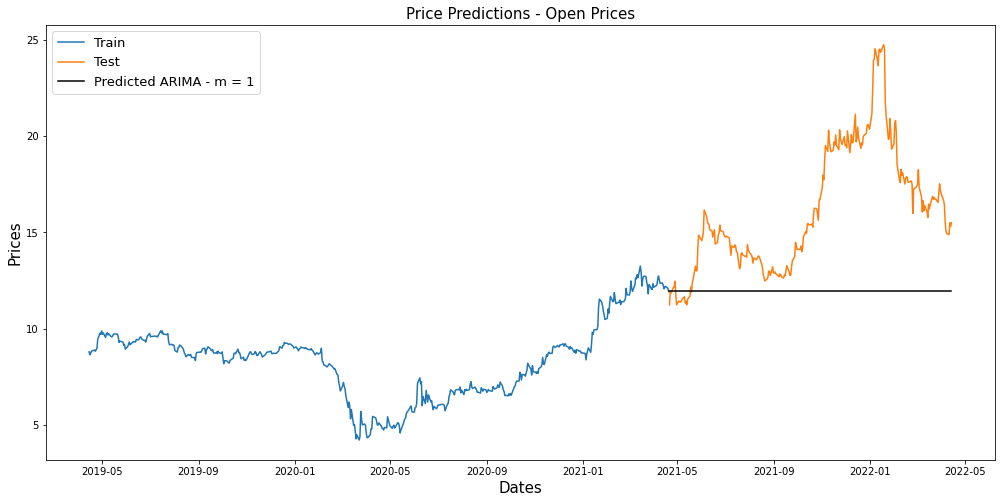

F
Evaluation:

  13  from  60

----------------------------------------------------------------------------------------------------
Company:  AMZN 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5477.394, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5477.440, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5477.679, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5477.417, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5477.056, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5475.974, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5477.235, Time=0.24 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5477.164, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=5477.879, Time=0.03 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5474.165, Time=0.29 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=5471.630, Time=0.35 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=5470.480, Time=0.33 sec


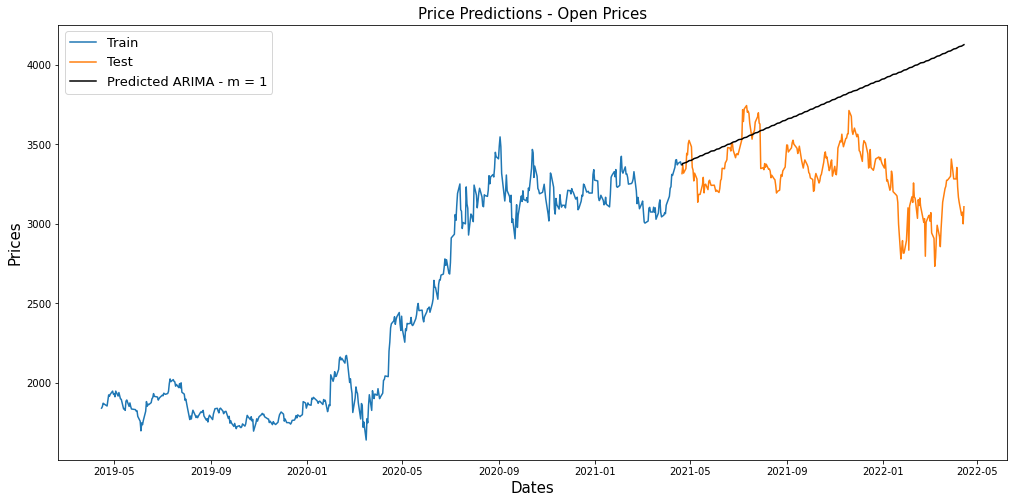

AMZN
Evaluation:

  14  from  60

----------------------------------------------------------------------------------------------------
Company:  DIS 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2557.608, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2561.873, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2553.990, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2554.589, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2560.598, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2555.670, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2555.611, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2557.609, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2552.945, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=2554.576, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2554.522, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2553.564, Time=0.02 se

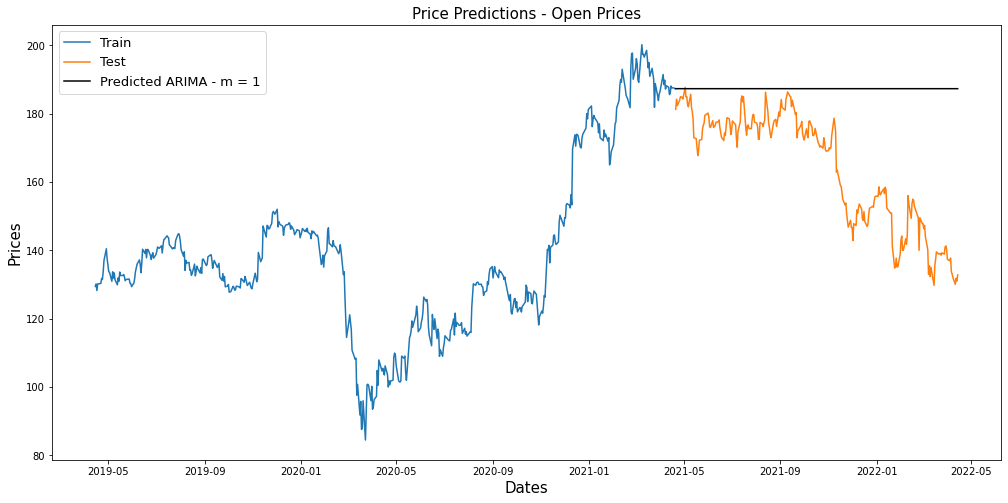

DIS
Evaluation:

  15  from  60

----------------------------------------------------------------------------------------------------
Company:  NIO 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1939.101, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1964.625, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1940.997, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1939.427, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1963.355, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1940.855, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1941.219, Time=0.08 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1920.685, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1937.423, Time=0.13 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1922.463, Time=0.36 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1922.488, Time=0.40 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1933.729, Time=0.12 sec

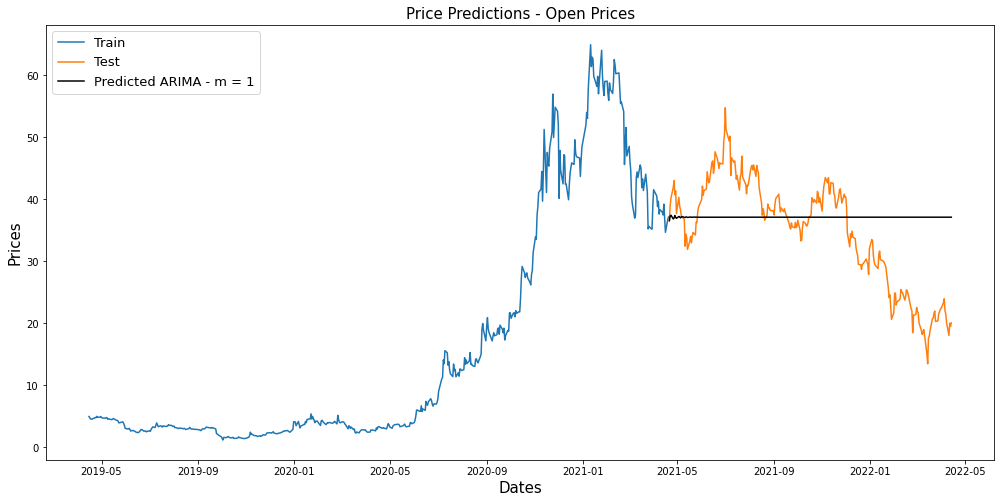

NIO
Evaluation:

  16  from  60

----------------------------------------------------------------------------------------------------
Company:  LCID 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1230.281, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1230.433, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1232.405, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1232.410, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1228.561, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1234.235, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.161 seconds
----------------------------------------------------------------------------------------------------
Testing data
Evaluation:

RMSE : 12.78441069723696
MAPE : 0.23039231924847128


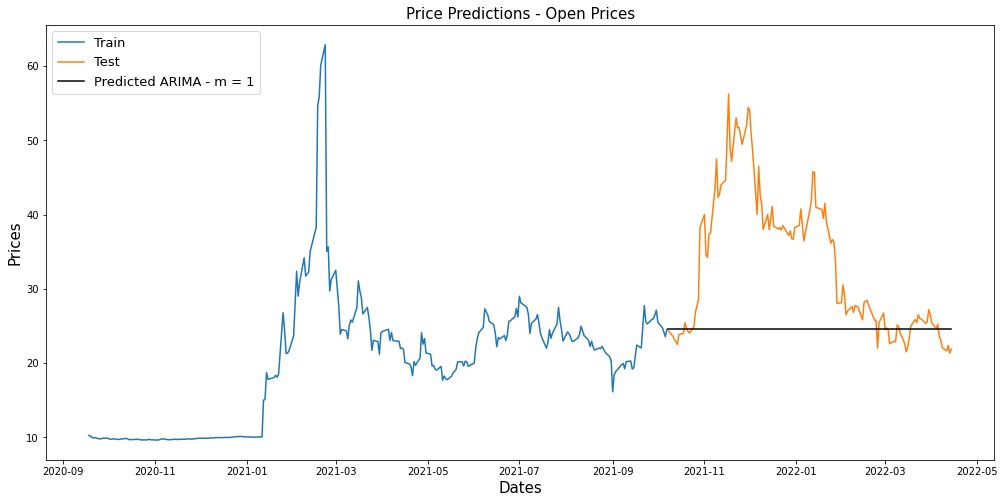

LCID
Evaluation:

  17  from  60

----------------------------------------------------------------------------------------------------
Company:  PFE 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=912.868, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=911.302, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=911.698, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=911.687, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=909.323, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=913.687, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.375 seconds
----------------------------------------------------------------------------------------------------
Testing data
Evaluation:

RMSE : 10.899165718202413
MAPE : 0.17573025775739318


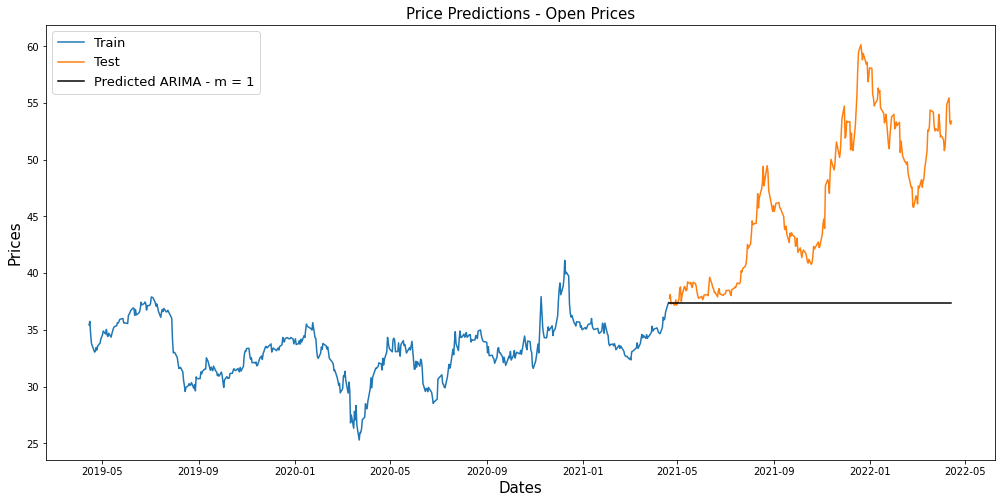

PFE
Evaluation:

  18  from  60

----------------------------------------------------------------------------------------------------
Company:  FB 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3086.937, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3083.358, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3084.449, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3084.385, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3082.540, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.459 seconds
----------------------------------------------------------------------------------------------------
Testing data
Evaluation:

RMSE : 54.1117108928879
MAPE : 0.16642056652794493


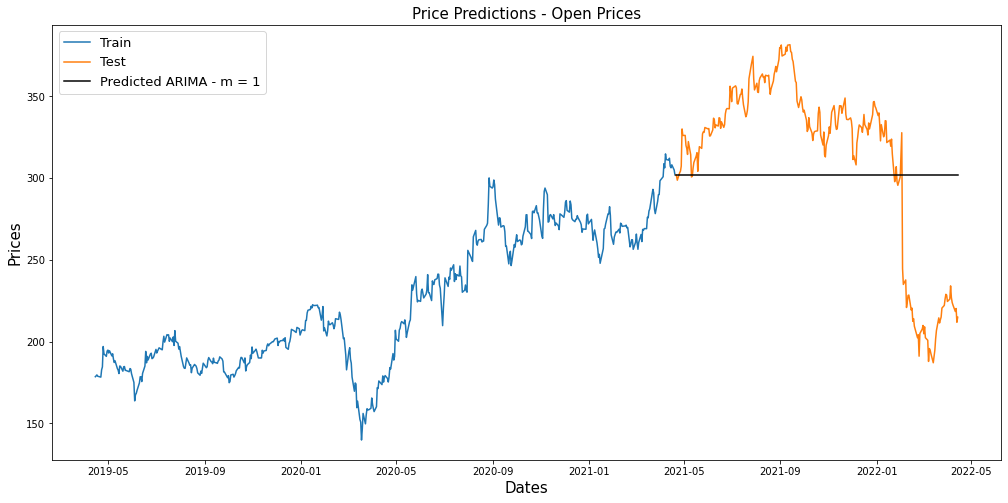

FB
Evaluation:

  19  from  60

----------------------------------------------------------------------------------------------------
Company:  NFLX 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3823.048, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3824.481, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3826.430, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3826.421, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3823.227, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3825.976, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3821.769, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3827.769, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3825.800, Time=0.08 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3824.570, Time=0.18 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3821.825, Time=0.06 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 0.

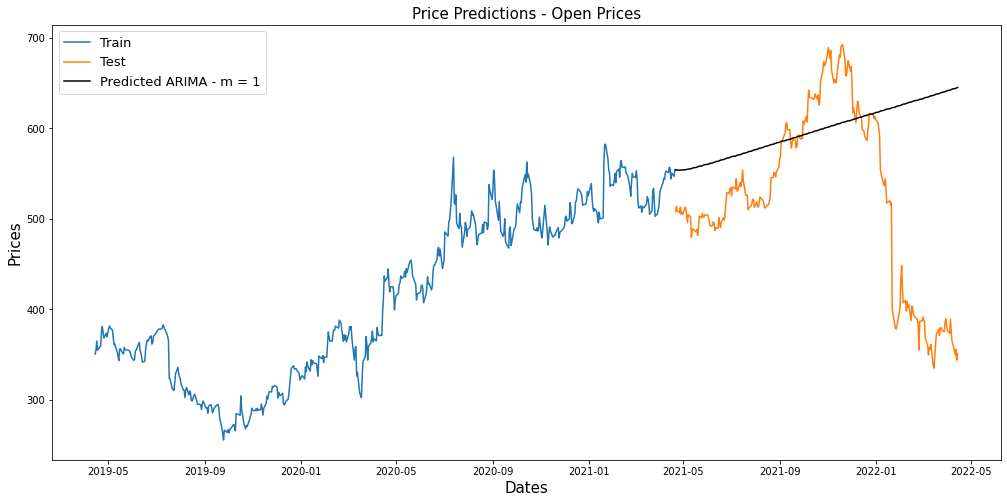

NFLX
Evaluation:

  20  from  60

----------------------------------------------------------------------------------------------------
Company:  AAL 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1388.148, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1385.102, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1384.360, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1384.446, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1383.485, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1386.164, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.292 seconds
----------------------------------------------------------------------------------------------------
Testing data
Evaluation:

RMSE : 2.749510698411589
MAPE : 0.12252826137204


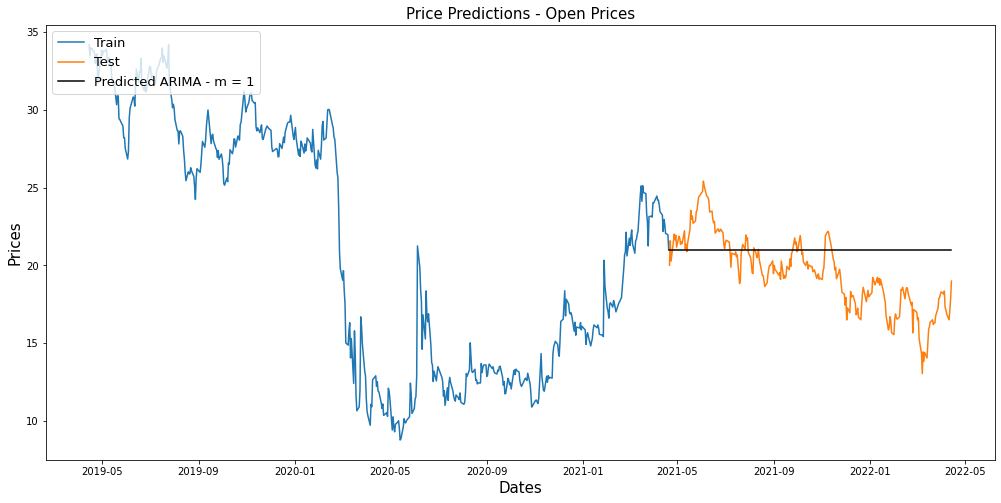

AAL
Evaluation:

  21  from  60

----------------------------------------------------------------------------------------------------
Company:  NVDA 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2447.960, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2447.412, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2448.639, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2448.509, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2448.456, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2445.874, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2447.979, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2447.526, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2447.994, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2449.678, Time=0.33 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2449.435, Time=0.04 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 0

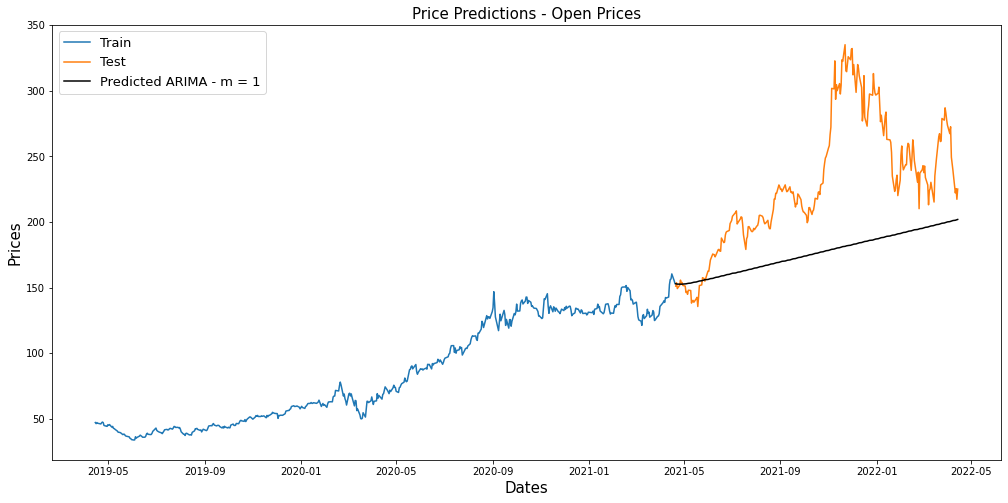

NVDA
Evaluation:

  22  from  60

----------------------------------------------------------------------------------------------------
Company:  PLUG 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1928.729, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1928.260, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1930.111, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1930.080, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1926.651, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1929.368, Time=0.16 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.323 seconds
----------------------------------------------------------------------------------------------------
Testing data
Evaluation:

RMSE : 6.344669297348681
MAPE : 0.14136866570917384


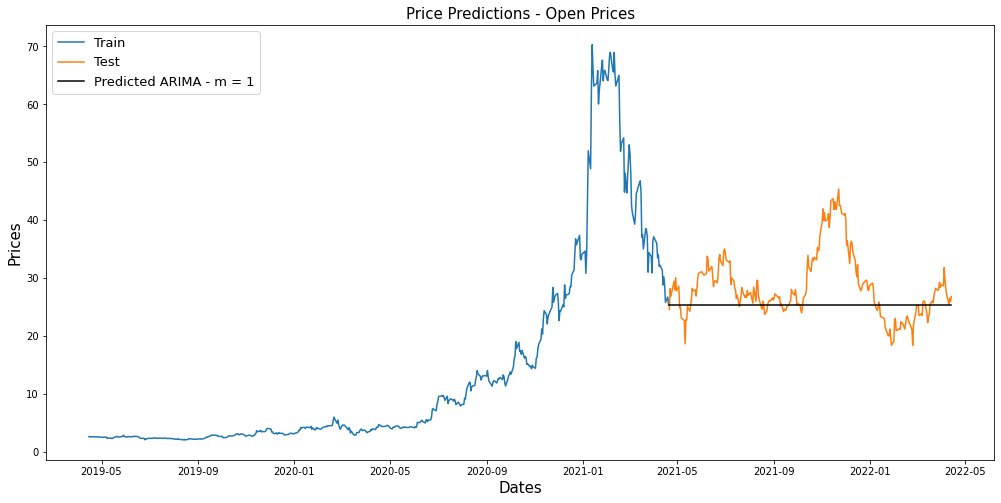

PLUG
Evaluation:

  23  from  60

----------------------------------------------------------------------------------------------------
Company:  GPRO 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=226.425, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=223.894, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=225.873, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=225.873, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=222.273, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=227.873, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.321 seconds
----------------------------------------------------------------------------------------------------
Testing data
Evaluation:

RMSE : 1.5152683335709969
MAPE : 0.13628604006505346


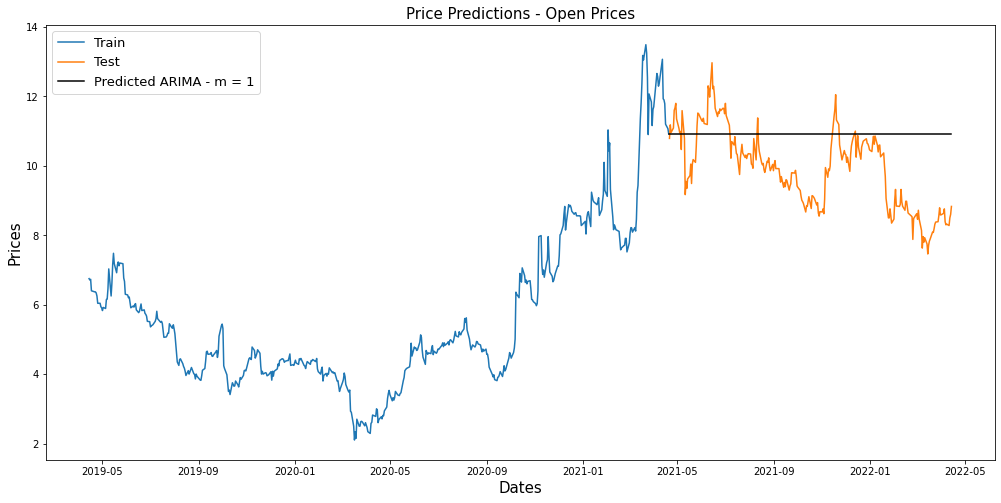

GPRO
Evaluation:

  24  from  60

----------------------------------------------------------------------------------------------------
Company:  BABA 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3168.869, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3168.859, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3170.650, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3170.604, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3166.990, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3170.115, Time=0.11 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.349 seconds
----------------------------------------------------------------------------------------------------
Testing data
Evaluation:

RMSE : 83.74939403361302
MAPE : 0.5597357273490026


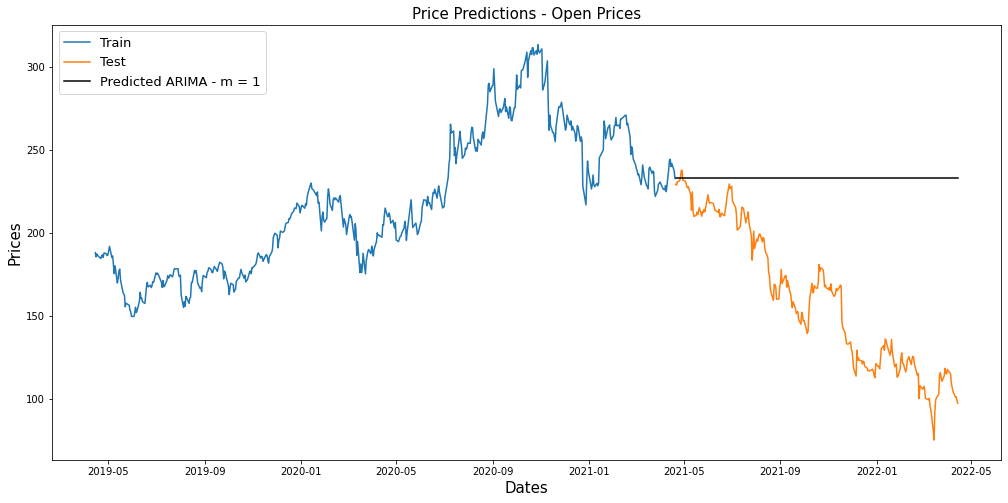

BABA
Evaluation:

  25  from  60

----------------------------------------------------------------------------------------------------
Company:  CCL 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1558.998, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1559.196, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1560.684, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1560.767, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1558.146, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1559.455, Time=0.14 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.313 seconds
----------------------------------------------------------------------------------------------------
Testing data
Evaluation:

RMSE : 4.9959642006886185
MAPE : 0.20858637100588315


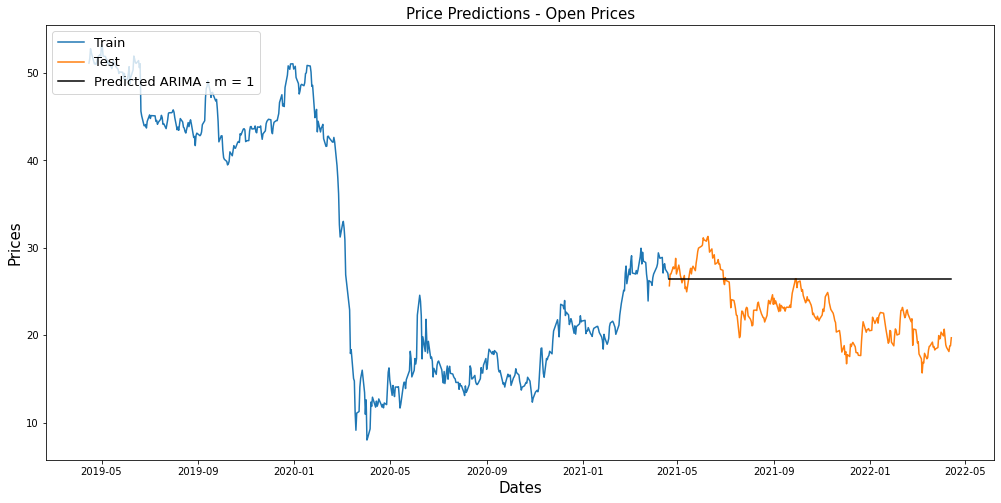

CCL
Evaluation:

  26  from  60

----------------------------------------------------------------------------------------------------
Company:  ACB 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=2441.131, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=2291.775, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2439.135, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=2216.595, Time=0.05 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=2174.931, Time=0.06 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=2148.575, Time=0.08 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=2138.522, Time=0.11 sec
 ARIMA(5,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.68 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.53 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=2136.527, Time=0.05 sec
 ARIMA(4,2,0)(0,0,0

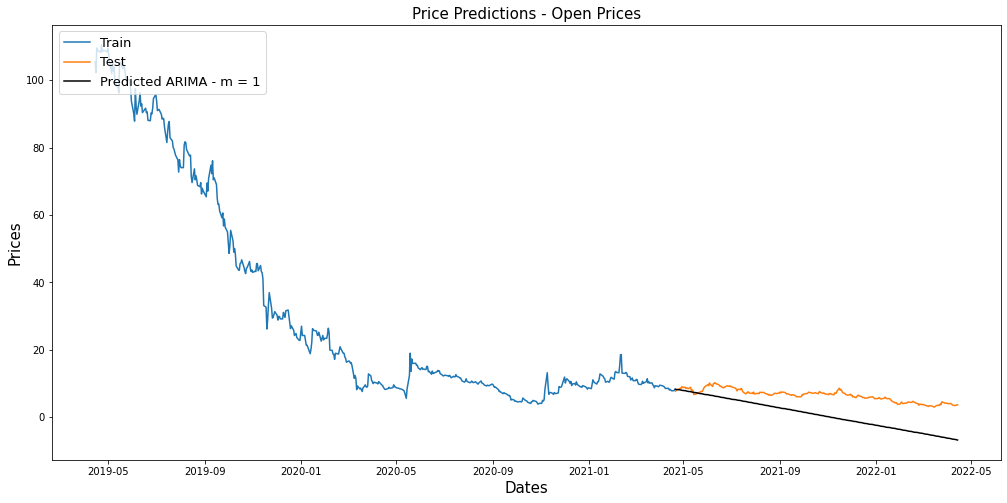

ACB
Evaluation:

  27  from  60

----------------------------------------------------------------------------------------------------
Company:  ZOM 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1079.223, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1080.661, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1079.494, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1079.607, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1082.582, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1077.755, Time=0.12 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.669 seconds
----------------------------------------------------------------------------------------------------
Testing data
Evaluation:

RMSE : 0.3989927006837906
MAPE : 0.8922458833117869


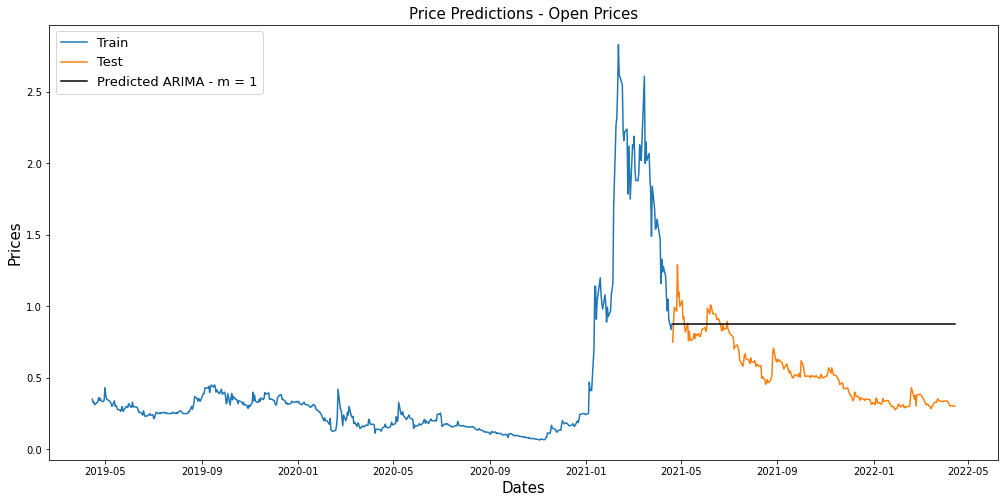

ZOM
Evaluation:

  28  from  60

----------------------------------------------------------------------------------------------------
Company:  VOO 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2776.337, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2774.274, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2773.531, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2773.714, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2774.387, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2775.088, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2775.372, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2776.052, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2773.972, Time=0.01 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 0.523 seconds
----------------------------------------------------------------------------------------------------
Testing data
Evalua

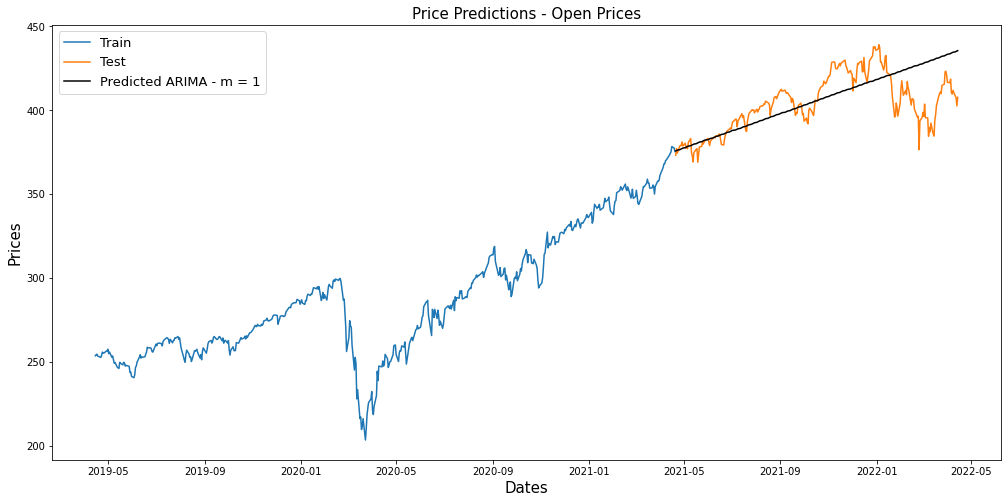

VOO
Evaluation:

  29  from  60

----------------------------------------------------------------------------------------------------
Company:  NOK 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-722.811, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-719.887, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-722.547, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-721.891, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-721.579, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-723.263, Time=0.09 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-724.048, Time=0.12 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-722.062, Time=0.33 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=-722.080, Time=0.19 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-722.156, Time=0.53 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-725.846, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-725.028, Time=0.08 sec

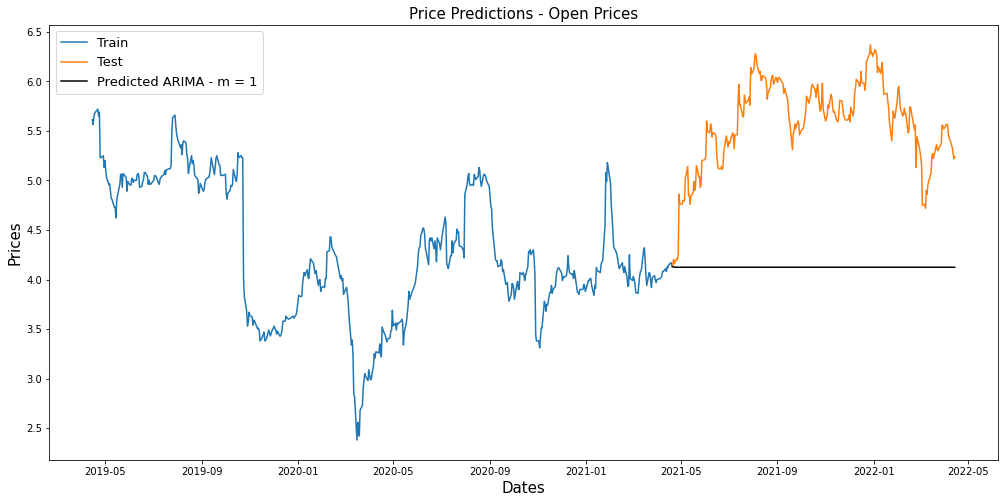

NOK
Evaluation:

  30  from  60

----------------------------------------------------------------------------------------------------
Company:  SPY 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2873.994, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2873.372, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2871.351, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2871.664, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2873.420, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2872.757, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2873.114, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2873.751, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2871.793, Time=0.02 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 0.688 seconds
----------------------------------------------------------------------------------------------------
Testing data
Evalua

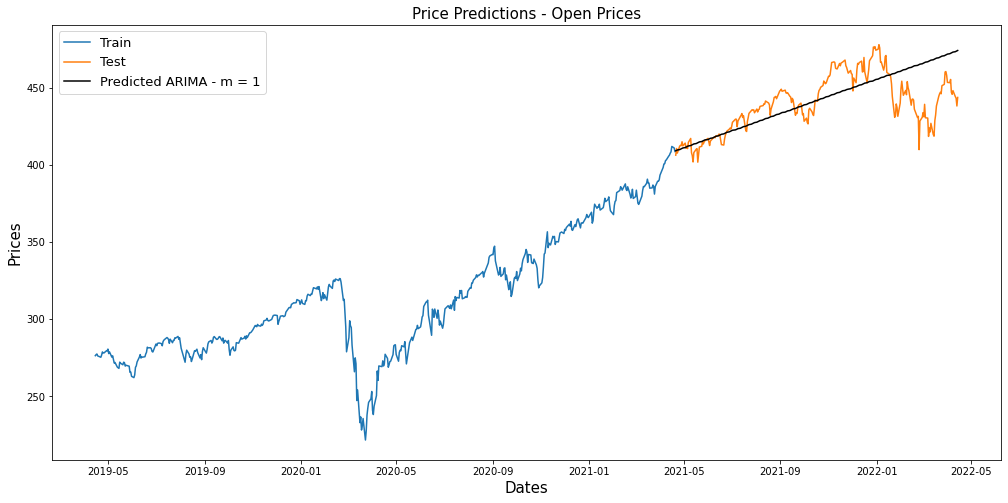

SPY
Evaluation:

  31  from  60

----------------------------------------------------------------------------------------------------
Company:  DAL 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1781.422, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1778.573, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1780.327, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1780.352, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1776.695, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1781.738, Time=0.12 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.300 seconds
----------------------------------------------------------------------------------------------------
Testing data
Evaluation:

RMSE : 5.538387411401944
MAPE : 0.12075538111572069


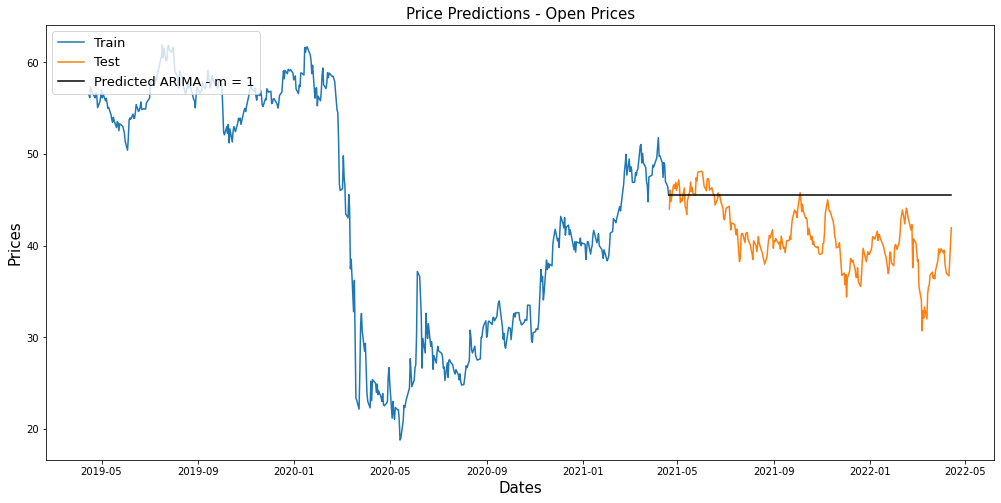

DAL
Evaluation:

  32  from  60

----------------------------------------------------------------------------------------------------
Company:  BAC 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1014.825, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1009.210, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1010.825, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1010.825, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1007.687, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1012.825, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.221 seconds
----------------------------------------------------------------------------------------------------
Testing data
Evaluation:

RMSE : 5.40230316718632
MAPE : 0.10105273655127021


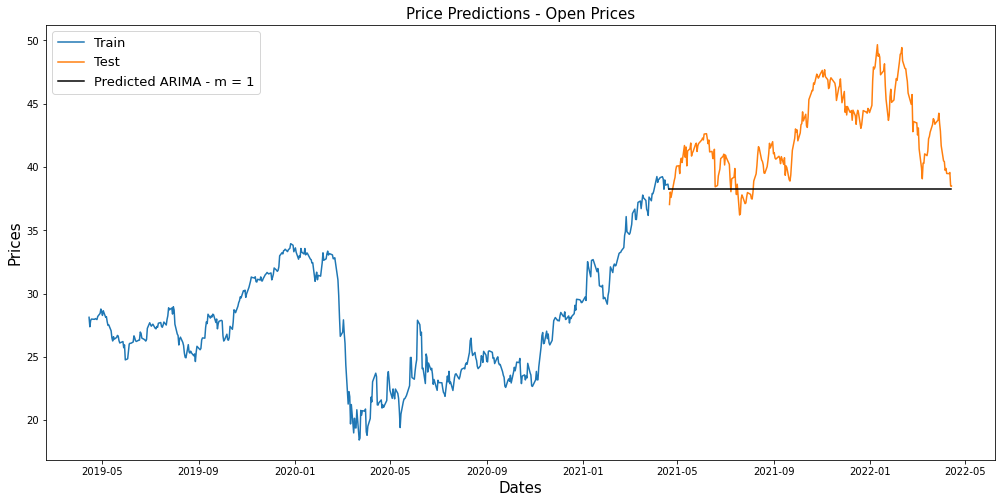

BAC
Evaluation:

  33  from  60

----------------------------------------------------------------------------------------------------
Company:  PLTR 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=947.717, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=944.919, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=943.936, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=944.028, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=943.242, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=945.926, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.219 seconds
----------------------------------------------------------------------------------------------------
Testing data
Evaluation:

RMSE : 8.085183617510486
MAPE : 0.5096638774017032


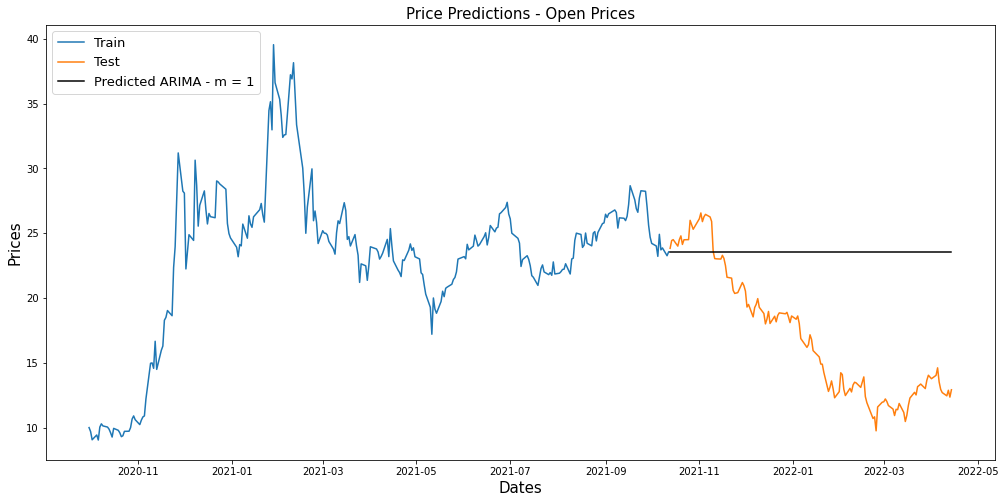

PLTR
Evaluation:

  34  from  60

----------------------------------------------------------------------------------------------------
Company:  GME 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4363.084, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4416.522, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4399.231, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4404.163, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4414.656, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4361.254, Time=0.07 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4362.676, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4396.842, Time=0.12 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4327.318, Time=0.22 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=4314.190, Time=0.38 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4348.770, Time=0.19 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=4310.696, Time=0.39 se

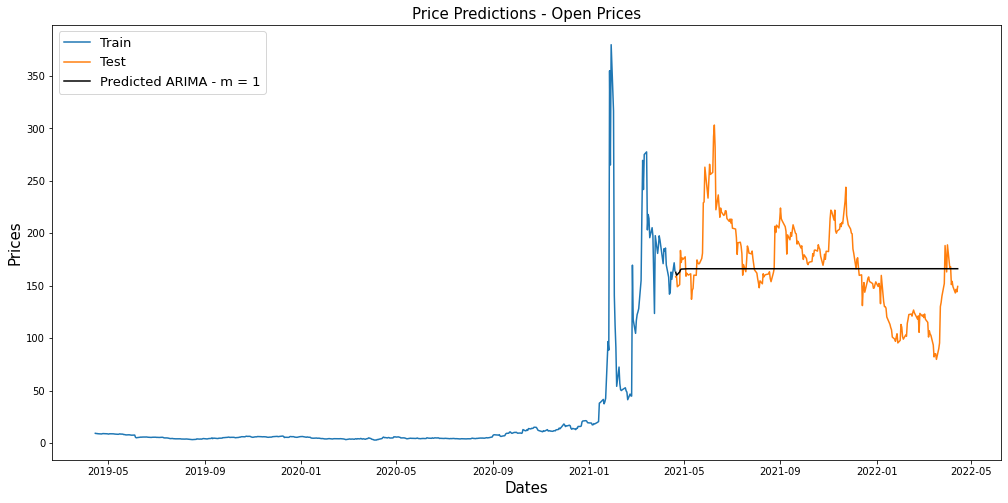

GME
Evaluation:

  35  from  60

----------------------------------------------------------------------------------------------------
Company:  SBUX 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1891.198, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1889.848, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1888.652, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1888.675, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1889.316, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1890.644, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1890.649, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1890.513, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1888.375, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1890.375, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1890.375, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1888.415, Time=0.02 se

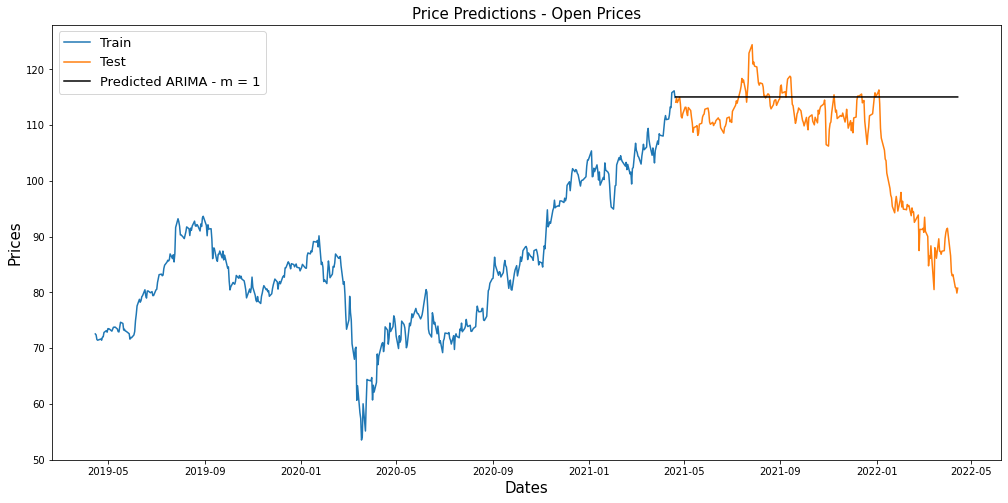

SBUX
Evaluation:

  36  from  60

----------------------------------------------------------------------------------------------------
Company:  AMD 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2075.240, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2072.099, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2072.867, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2072.862, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2071.699, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2073.241, Time=0.11 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.311 seconds
----------------------------------------------------------------------------------------------------
Testing data
Evaluation:

RMSE : 37.118298211824076
MAPE : 0.24661720075116672


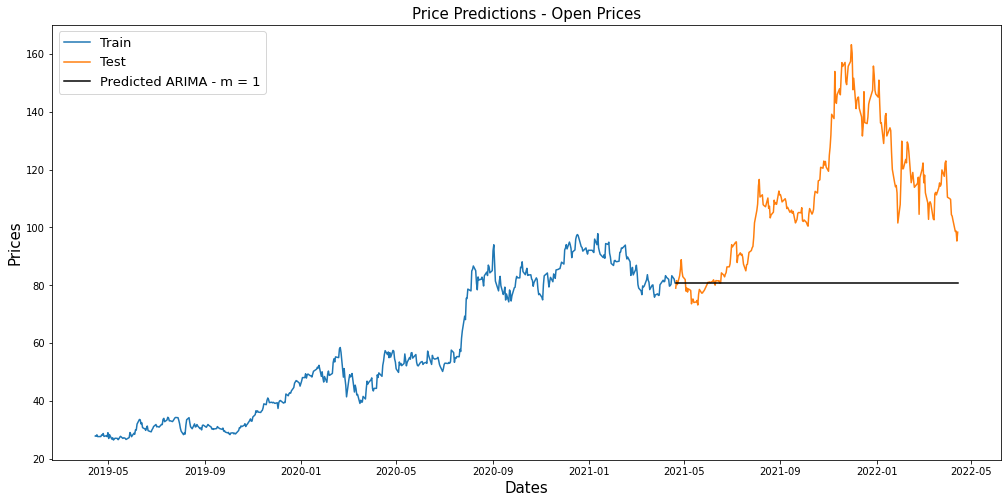

AMD
Evaluation:

  37  from  60

----------------------------------------------------------------------------------------------------
Company:  OGI 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=38.056, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=52.404, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=54.404, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=54.404, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=51.435, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=38.513, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=44.594, Time=0.12 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=39.677, Time=0.27 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=40.296, Time=0.27 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=38.372, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=39.399, Time=0.13 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=41.956, Time=0.55 sec
 ARIMA(1,1,2)(0,0,0)[0]

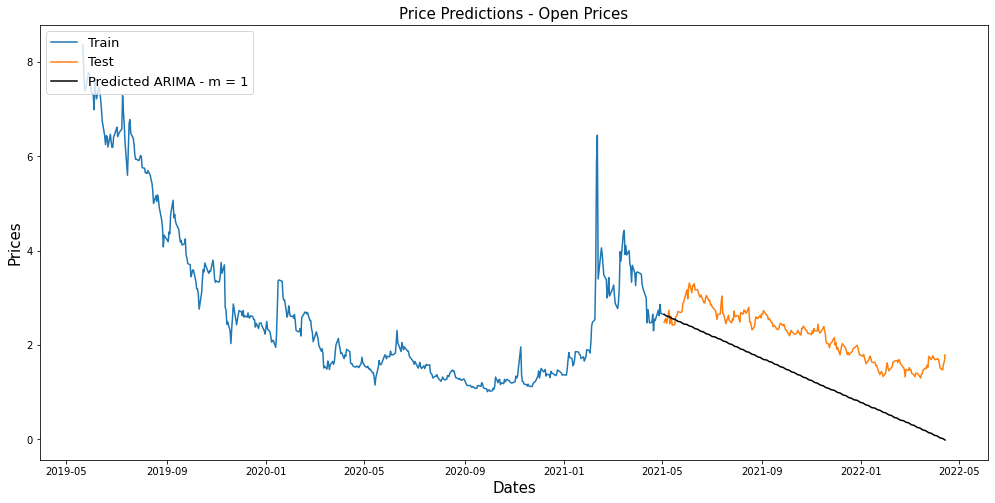

OGI
Evaluation:

  38  from  60

----------------------------------------------------------------------------------------------------
Company:  TLRY 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2210.965, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2275.180, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2275.674, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2272.268, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2273.620, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2209.707, Time=0.04 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=2210.726, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2249.660, Time=0.07 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2201.472, Time=0.30 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=2212.682, Time=0.19 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=2213.435, Time=0.16 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=2211.476, Time=0.06 se

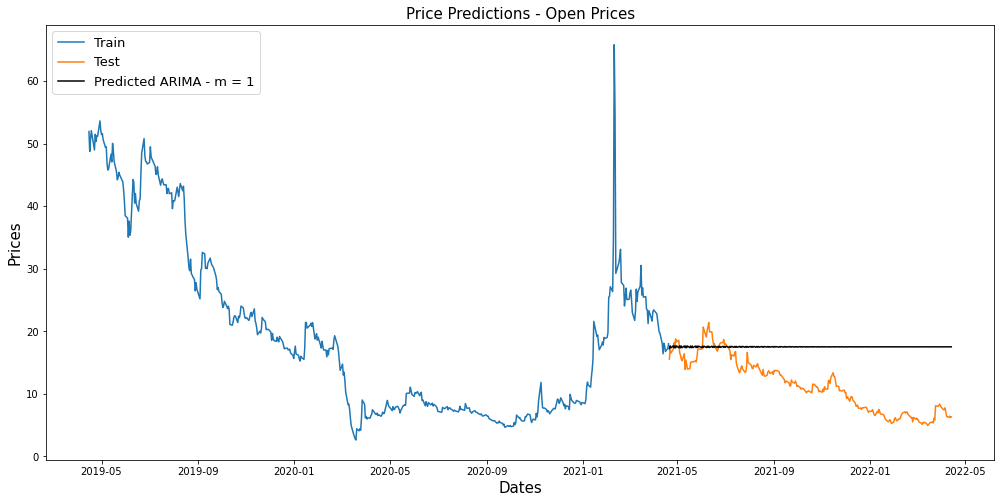

TLRY
Evaluation:

  39  from  60

----------------------------------------------------------------------------------------------------
Company:  COIN 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1312.001, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1307.085, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1309.029, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1309.032, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1305.925, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1310.308, Time=0.07 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.219 seconds
----------------------------------------------------------------------------------------------------
Testing data
Evaluation:

RMSE : 56.35278976939251
MAPE : 0.2714610411344034


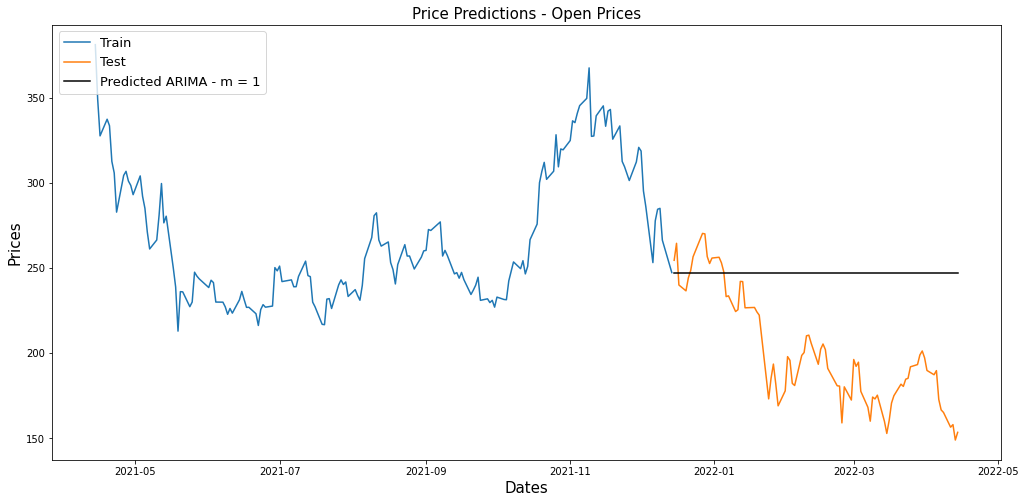

COIN
Evaluation:

  40  from  60

----------------------------------------------------------------------------------------------------
Company:  TWTR 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1726.473, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1724.516, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1725.770, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1725.866, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1723.794, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1725.992, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.263 seconds
----------------------------------------------------------------------------------------------------
Testing data
Evaluation:

RMSE : 19.19982178324212
MAPE : 0.36275026629724433


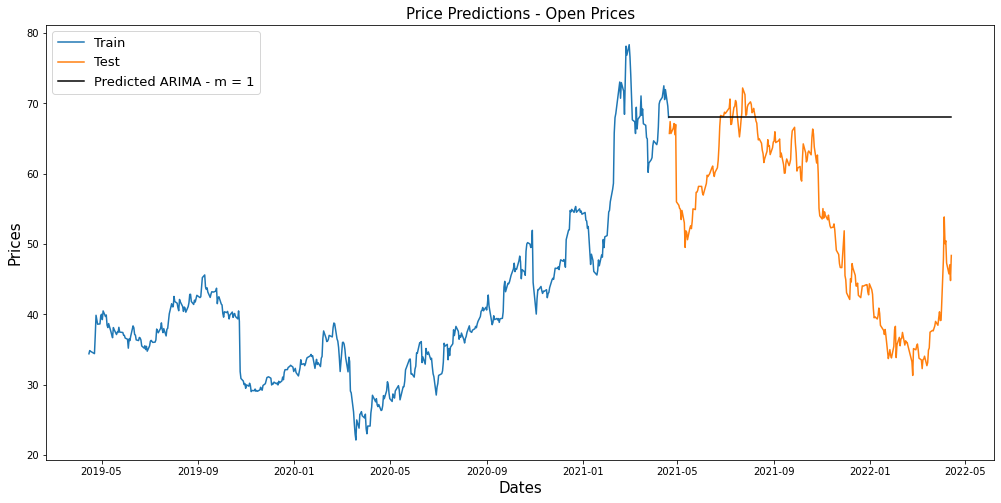

TWTR
Evaluation:

  41  from  60

----------------------------------------------------------------------------------------------------
Company:  T 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=330.909, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=340.317, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=340.908, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=340.847, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=338.341, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=342.536, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=340.848, Time=0.19 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=332.710, Time=0.25 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=332.074, Time=0.25 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=344.513, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=330.402, Time=0.17 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=342.659, Time=0.05 sec
 ARIMA(3,1,1

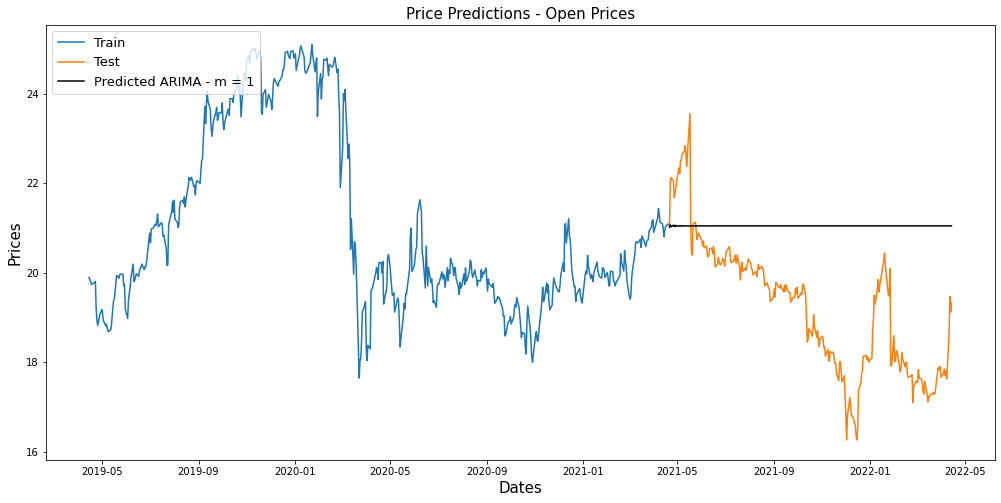

T
Evaluation:

  42  from  60

----------------------------------------------------------------------------------------------------
Company:  MRNA 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3066.193, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3073.702, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3074.393, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3073.914, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3073.148, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3068.009, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3074.214, Time=0.09 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3067.311, Time=0.14 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3061.127, Time=0.12 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=3063.044, Time=0.08 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3063.106, Time=0.22 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=3063.113, Time=0.22 sec


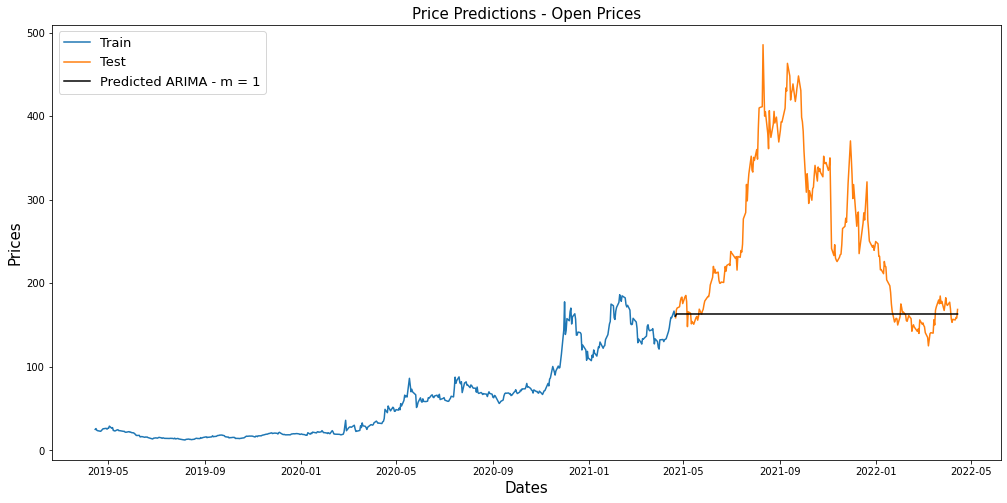

MRNA
Evaluation:

  43  from  60

----------------------------------------------------------------------------------------------------
Company:  CGC 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1692.609, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1693.287, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1694.017, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1693.668, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1691.521, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1693.887, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.265 seconds
----------------------------------------------------------------------------------------------------
Testing data
Evaluation:

RMSE : 14.702710198201816
MAPE : 1.3244032100327516


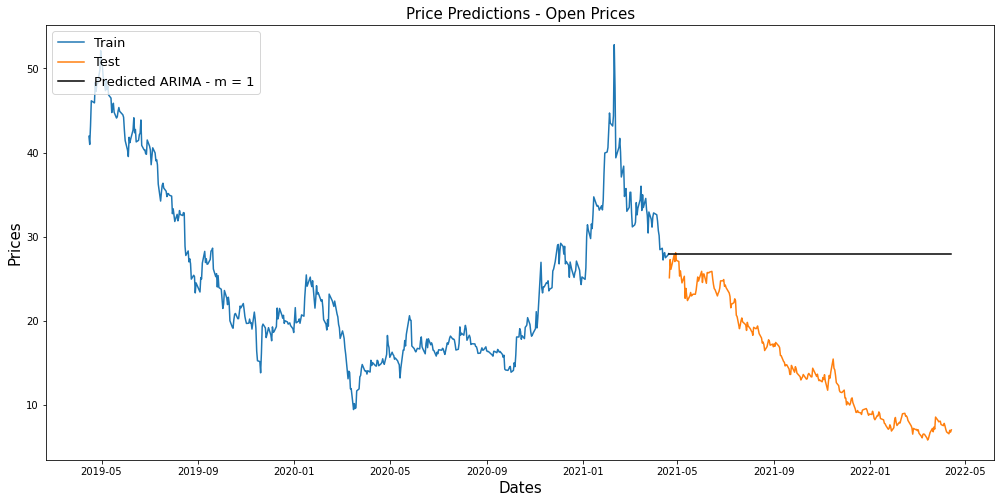

CGC
Evaluation:

  44  from  60

----------------------------------------------------------------------------------------------------
Company:  KO 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1192.506, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1203.290, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1188.482, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1191.141, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1201.581, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1187.096, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1188.961, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1189.067, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1188.546, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1181.678, Time=0.27 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=1170.870, Time=0.14 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1177.577, Time=0.06 sec


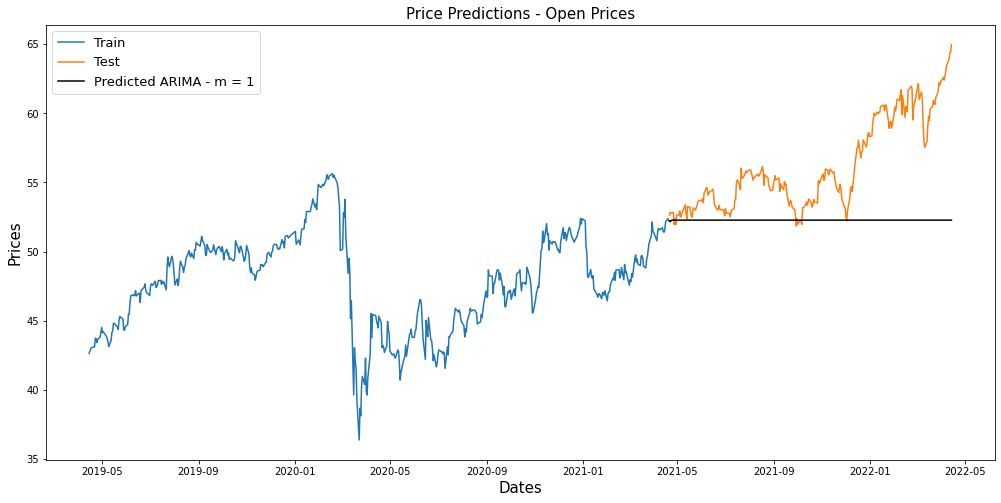

KO
Evaluation:

  45  from  60

----------------------------------------------------------------------------------------------------
Company:  SPCE 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1960.613, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1969.336, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1965.774, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1965.790, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1967.410, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1967.607, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1967.730, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1949.519, Time=0.23 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1969.305, Time=0.20 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1951.261, Time=0.25 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1951.292, Time=0.31 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1955.703, Time=0.10 sec

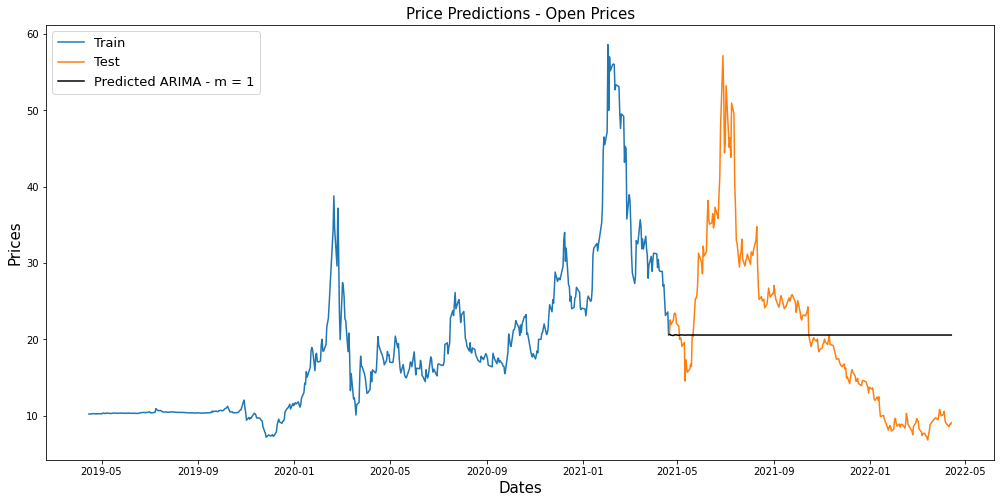

SPCE
Evaluation:

  46  from  60

----------------------------------------------------------------------------------------------------
Company:  FCEL 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1093.329, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1096.984, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1098.641, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1098.546, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1095.116, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1094.849, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1100.102, Time=0.13 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1048.174, Time=0.30 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1089.811, Time=0.09 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1044.149, Time=0.24 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1077.772, Time=0.11 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=1032.460, Time=0.35 s

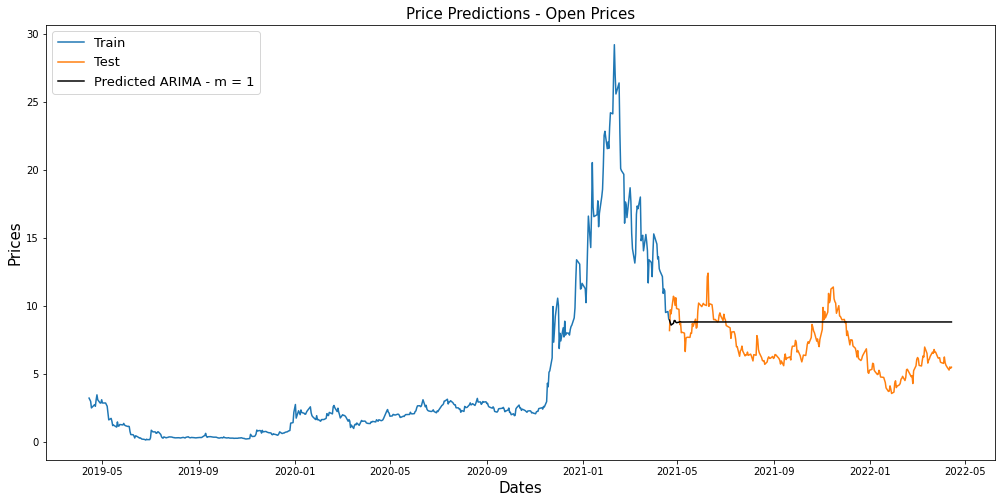

FCEL
Evaluation:

  47  from  60

----------------------------------------------------------------------------------------------------
Company:  GOOGL 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4822.079, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4818.178, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4818.142, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4818.097, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4819.088, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4820.069, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4820.064, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4819.401, Time=0.02 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.384 seconds
----------------------------------------------------------------------------------------------------
Testing data
Evaluation:

RMSE : 209.90411399309872
MAPE : 0.08754588611914933


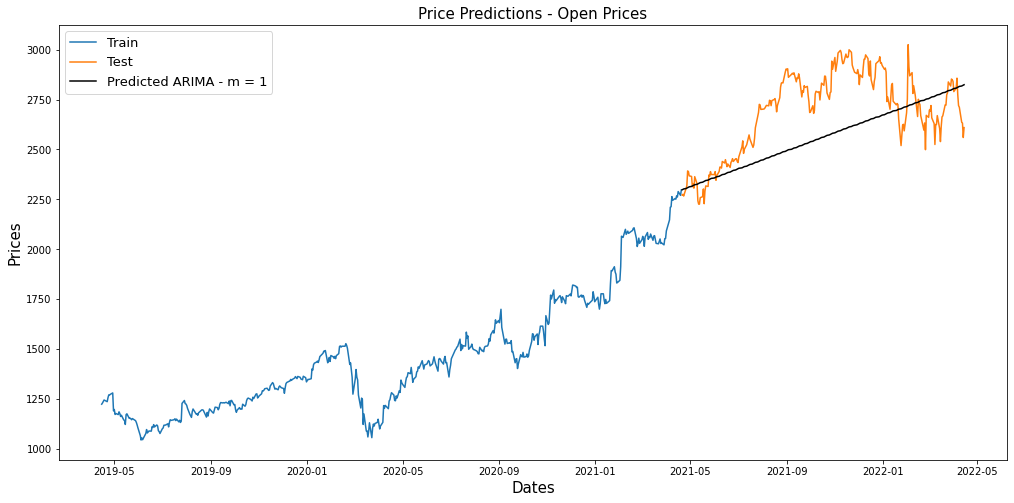

GOOGL
Evaluation:

  48  from  60

----------------------------------------------------------------------------------------------------
Company:  UBER 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1722.205, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1721.336, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1721.165, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1721.457, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1719.573, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1721.819, Time=0.07 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.236 seconds
----------------------------------------------------------------------------------------------------
Testing data
Evaluation:

RMSE : 15.72332392897915
MAPE : 0.37227671255620487


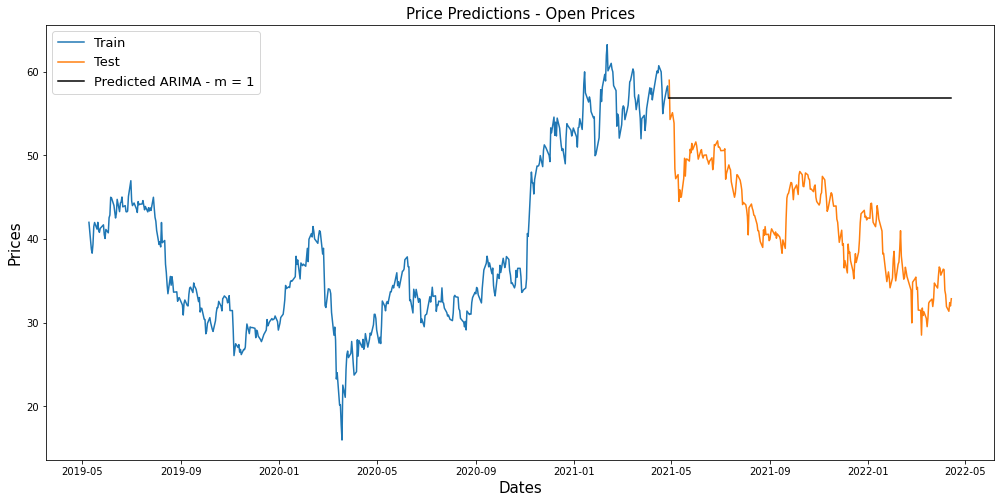

UBER
Evaluation:

  49  from  60

----------------------------------------------------------------------------------------------------
Company:  ZNGA 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-185.784, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-188.350, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-186.363, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-186.364, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-189.101, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-184.364, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.497 seconds
----------------------------------------------------------------------------------------------------
Testing data
Evaluation:

RMSE : 2.3182541400011907
MAPE : 0.24818130332815


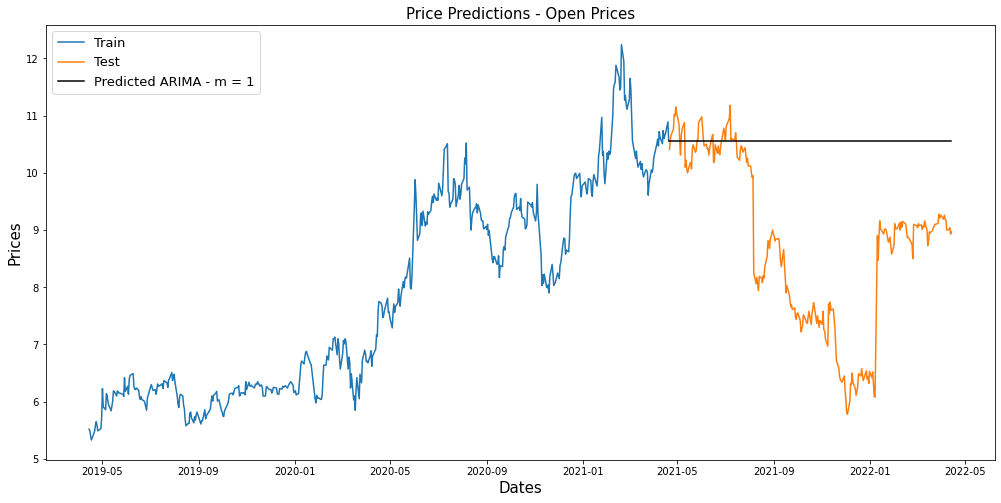

ZNGA
Evaluation:

  50  from  60

----------------------------------------------------------------------------------------------------
Company:  GM 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1430.700, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1426.183, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1428.113, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1428.119, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1424.912, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1430.039, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.315 seconds
----------------------------------------------------------------------------------------------------
Testing data
Evaluation:

RMSE : 6.77281267192348
MAPE : 0.10351212985922355


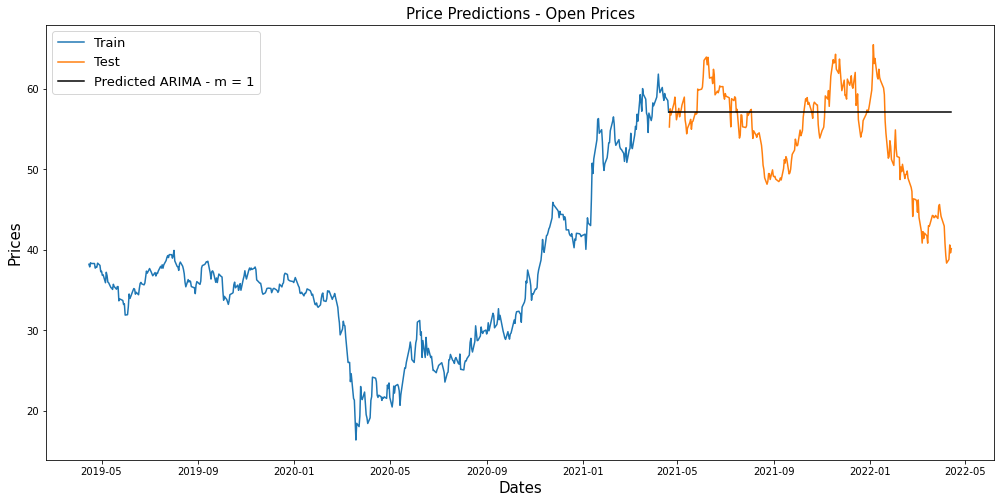

GM
Evaluation:

  51  from  60

----------------------------------------------------------------------------------------------------
Company:  GE 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2338.985, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2334.477, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2335.046, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2335.017, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2332.910, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2336.984, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.364 seconds
----------------------------------------------------------------------------------------------------
Testing data
Evaluation:

RMSE : 8.452460795390097
MAPE : 0.06944171459384452


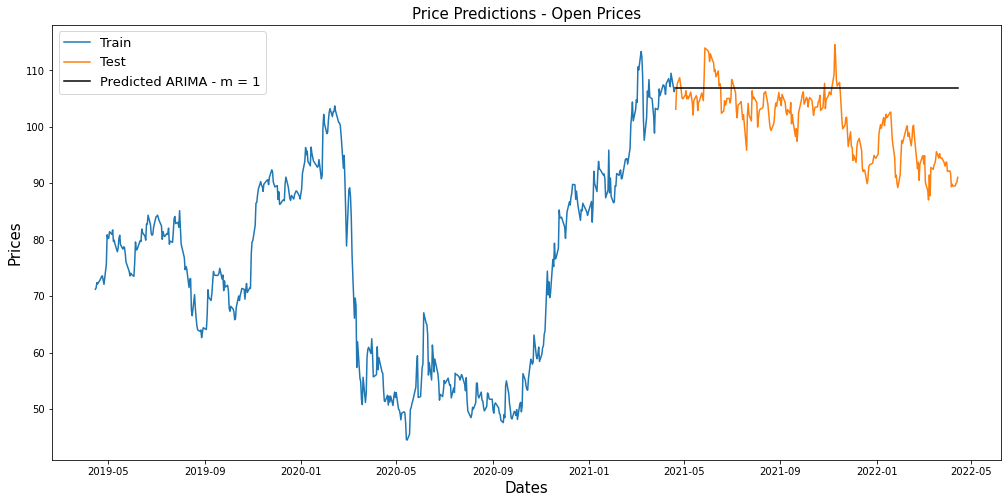

GE
Evaluation:

  52  from  60

----------------------------------------------------------------------------------------------------
Company:  PYPL 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2898.172, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2897.312, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2898.737, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2898.609, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2898.207, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2898.107, Time=0.13 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.312 seconds
----------------------------------------------------------------------------------------------------
Testing data
Evaluation:

RMSE : 125.44481739393932
MAPE : 0.6075213520893974


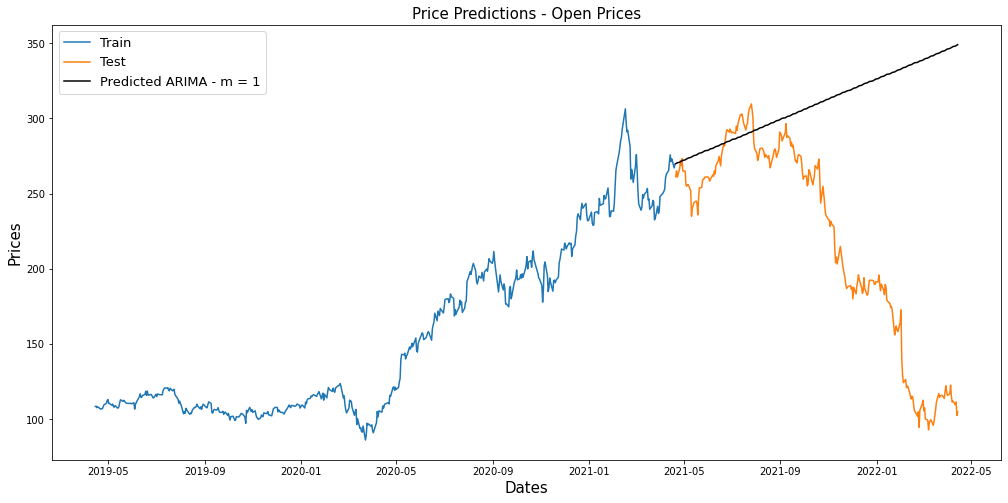

PYPL
Evaluation:

  53  from  60

----------------------------------------------------------------------------------------------------
Company:  ABNB 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1420.653, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1416.904, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1418.899, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1418.898, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1415.038, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.266 seconds
----------------------------------------------------------------------------------------------------
Testing data
Evaluation:

RMSE : 18.07780500437109
MAPE : 0.0935068211949644


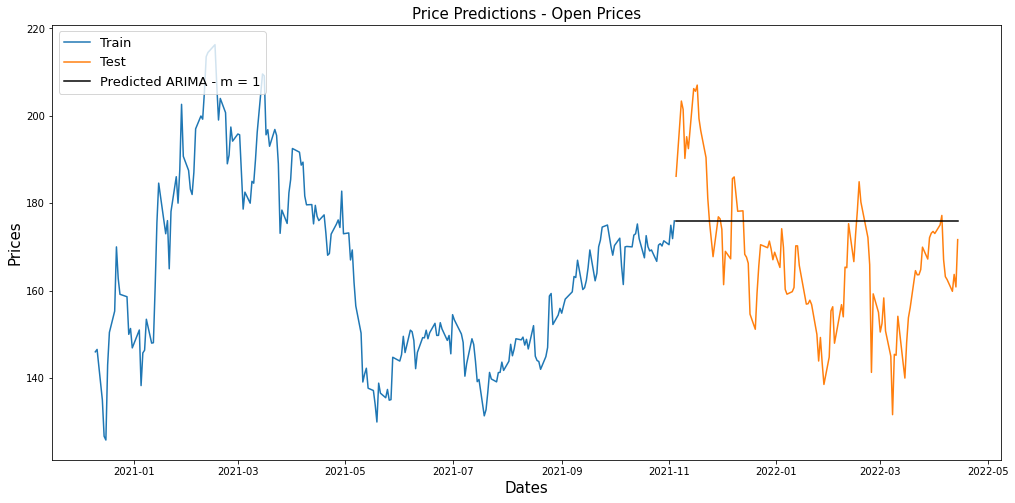

ABNB
Evaluation:

  54  from  60

----------------------------------------------------------------------------------------------------
Company:  UAL 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2173.807, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2170.534, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2172.534, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2172.534, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2169.009, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2174.403, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.255 seconds
----------------------------------------------------------------------------------------------------
Testing data
Evaluation:

RMSE : 7.890173602090199
MAPE : 0.1532780734934922


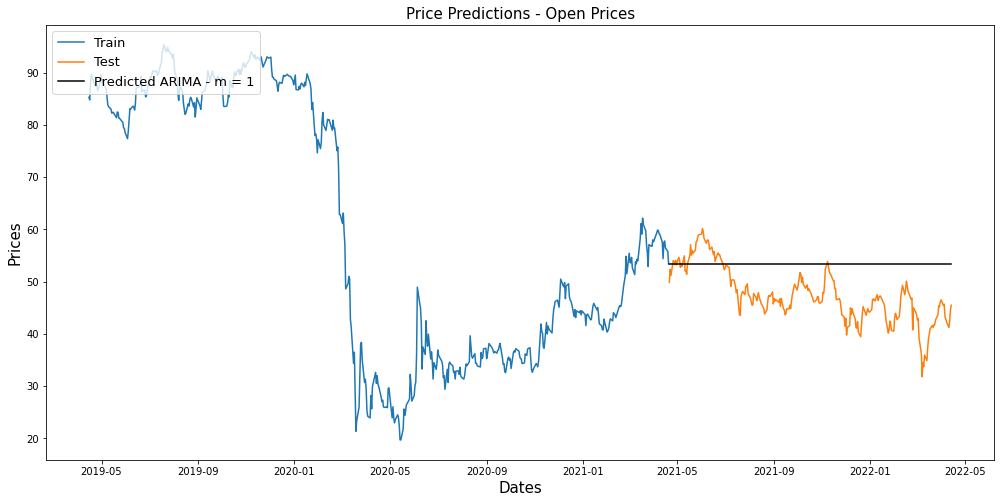

UAL
Evaluation:

  55  from  60

----------------------------------------------------------------------------------------------------
Company:  DKNG 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1872.925, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1875.196, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1869.057, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1869.378, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1873.989, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1871.020, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1871.027, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1872.679, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1868.081, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1870.025, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1870.037, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1868.421, Time=0.02 se

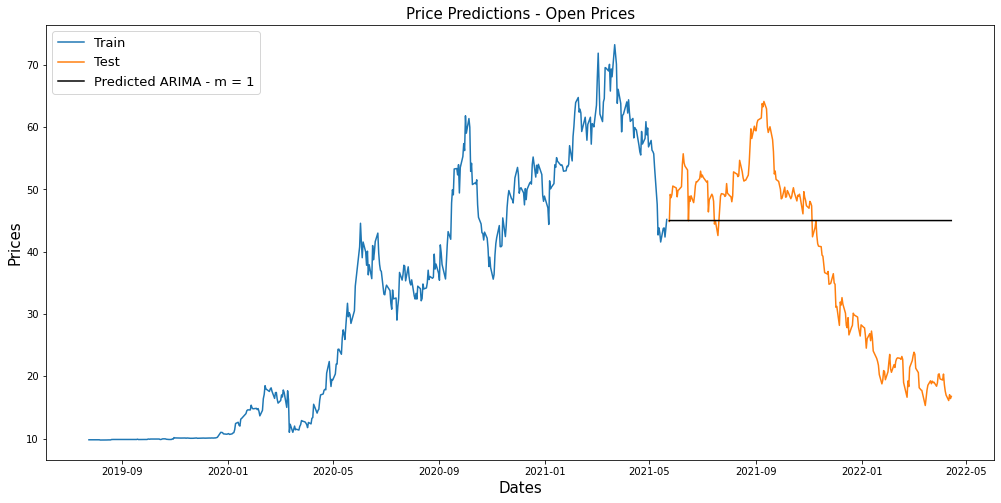

DKNG
Evaluation:

  56  from  60

----------------------------------------------------------------------------------------------------
Company:  JNJ 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2090.120, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2086.721, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2086.980, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2086.978, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2085.266, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2088.535, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.370 seconds
----------------------------------------------------------------------------------------------------
Testing data
Evaluation:

RMSE : 10.811156680636936
MAPE : 0.05431000848911325


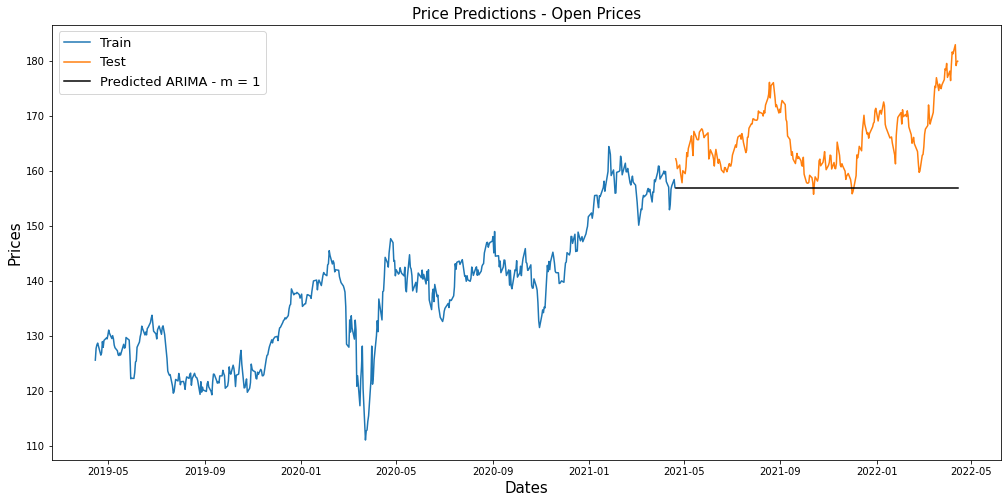

JNJ
Evaluation:

  57  from  60

----------------------------------------------------------------------------------------------------
Company:  LUV 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1694.701, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1691.316, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1692.489, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1692.546, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1689.409, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1693.891, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.270 seconds
----------------------------------------------------------------------------------------------------
Testing data
Evaluation:

RMSE : 13.093346028219306
MAPE : 0.25360203400822084


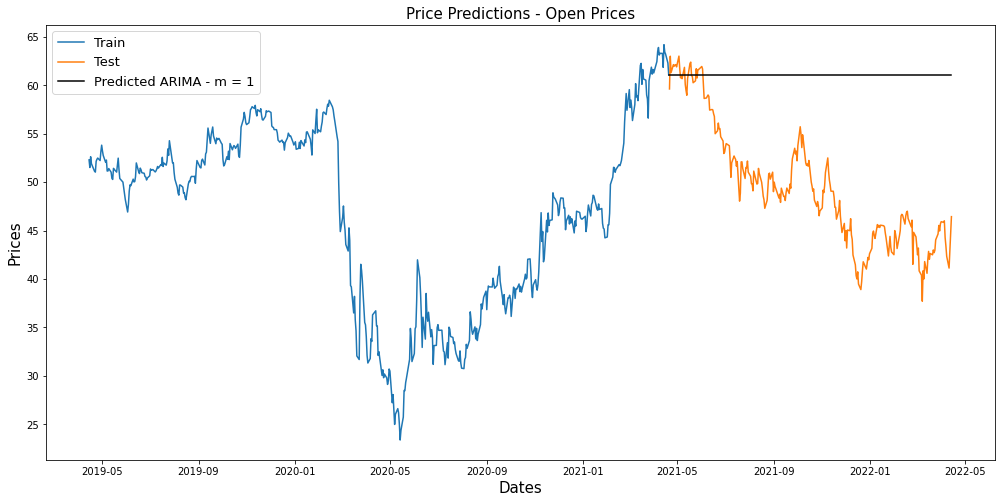

LUV
Evaluation:

  58  from  60

----------------------------------------------------------------------------------------------------
Company:  NKE 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2243.317, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2242.372, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2241.996, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2241.698, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2241.146, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2241.806, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.260 seconds
----------------------------------------------------------------------------------------------------
Testing data
Evaluation:

RMSE : 27.16190231562669
MAPE : 0.14199539962423205


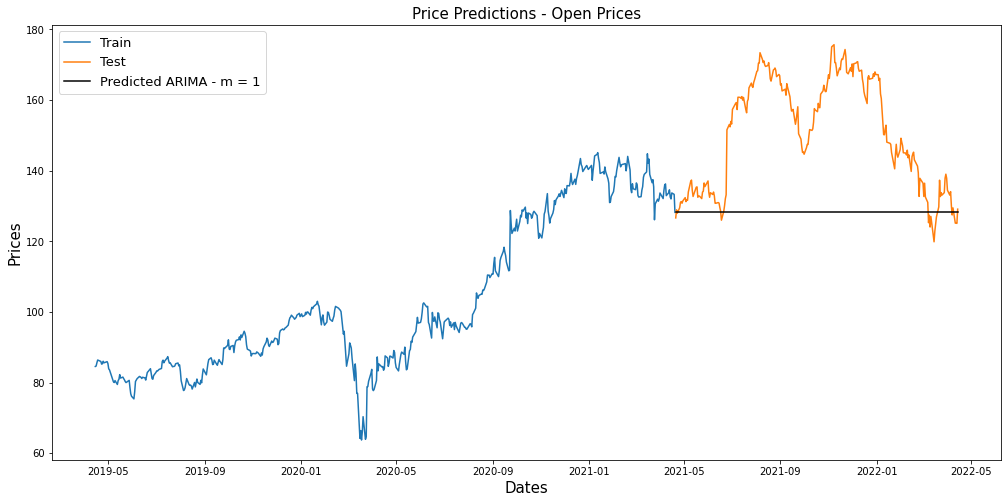

NKE
Evaluation:

  59  from  60

----------------------------------------------------------------------------------------------------
Company:  XOM 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1558.050, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1560.574, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1558.116, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1558.748, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1558.873, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1557.267, Time=0.04 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1556.516, Time=0.05 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1558.516, Time=0.11 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=1558.516, Time=0.07 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=1556.859, Time=0.21 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=1554.852, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1555.567, Time=0.02 sec

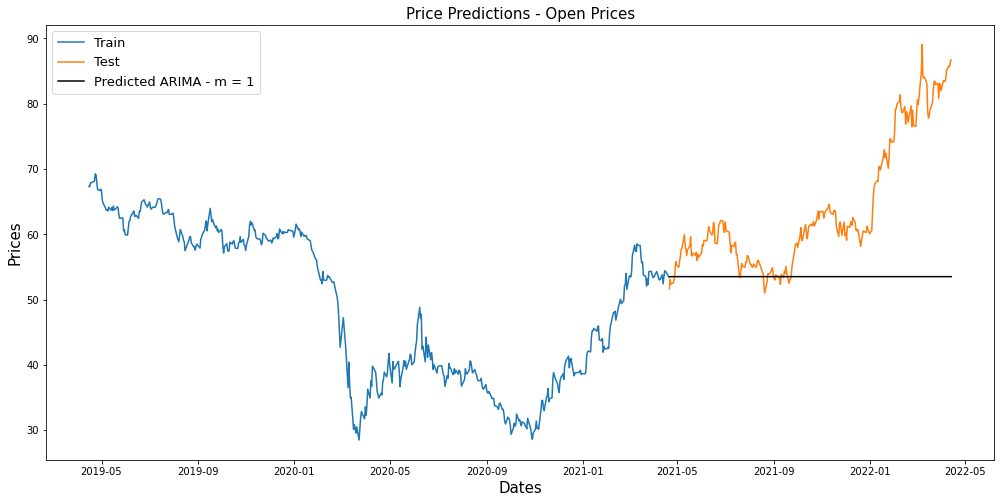

XOM
Evaluation:

  60  from  60

----------------------------------------------------------------------------------------------------
Company:  SONY 

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1724.586, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1719.734, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1721.732, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1721.732, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1722.193, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1723.621, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.265 seconds
----------------------------------------------------------------------------------------------------
Testing data
Evaluation:

RMSE : 20.226383185369883
MAPE : 0.18003404304903356


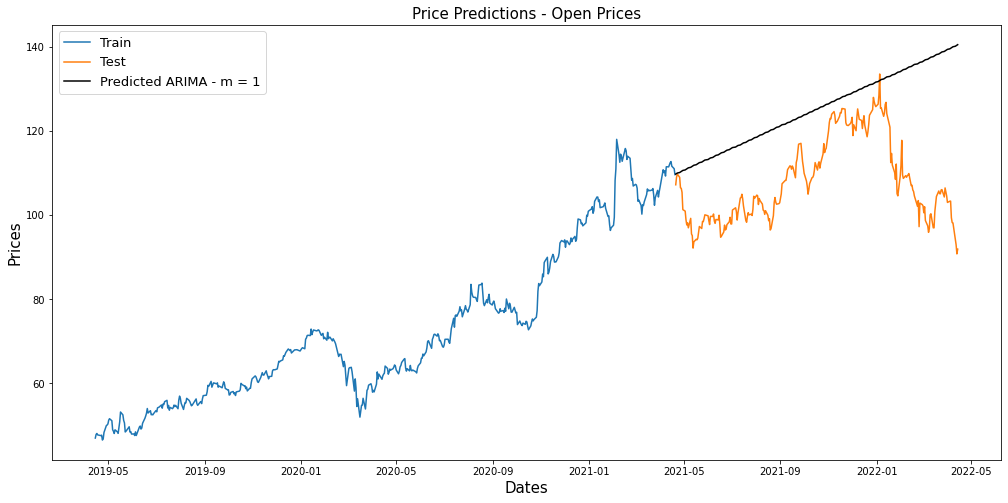

SONY
Evaluation:

Average rmse  36.50019740527286
Average mape  0.337749038614432


In [149]:

#testing data
eval_rmse, eval_mape = eval_multiple_comp_arima()

rmse = find_average(eval_rmse)
print("Average rmse ", rmse)
mape = find_average(eval_mape)
print("Average mape ", mape)
